#  Web Page Recommendation System
## Practical Data Science - Assignment 3

---

# 1. Executive Summary

This notebook presents a comprehensive investigation into web page recommendation systems, utilising the Anonymous Microsoft Web Data dataset from the UCI Machine Learning Repository (Lichman, 2013). The research systematically compares three fundamental recommendation paradigms to address the challenge of predicting user navigation behaviour in sparse implicit feedback environments.

**Recommendation Approaches Investigated:**

| Approach | Models Implemented | Theoretical Foundation |
|----------|-------------------|------------------------|
| Content-Based Filtering | Cosine Similarity, K-Nearest Neighbours, Singular Value Decomposition | Exploits item attributes and user preference profiles to recommend items similar to historical interactions (Lops et al., 2011) |
| Collaborative Filtering | User-KNN, Item-KNN, Alternating Least Squares, K-Means Clustering | Leverages collective user behaviour patterns to identify latent preferences without requiring item metadata (Su & Khoshgoftaar, 2009) |
| Hybrid Ensemble | Stacking Classifiers with diverse base learners | Combines multiple signals through meta-learning to mitigate individual model limitations (Alam et al., 2023) |

**Dataset Characteristics:**
- **Source:** Anonymous Microsoft Web Data (UCI Machine Learning Repository)
- **Temporal Scope:** One week of navigation logs from www.microsoft.com (February 1998)
- **Users:** Approximately 32,000 unique anonymised users
- **Items:** 294 distinct website areas (virtual roots or "vroots")
- **Interactions:** Approximately 98,000 recorded page visits
- **Sparsity:** 99.994% (presenting significant modelling challenges)

**Evaluation Framework:**
- Precision@5, Recall@5, and Hit Rate@5 for recommendation accuracy
- Catalog Coverage for diversity assessment
- Personalisation score via Jaccard-based dissimilarity
- User Segment Analysis stratified by activity level (Low/Medium/High)

## Table of Contents

| Section | Title | Description |
|---------|-------|-------------|
| **2** | Problem Definition | Research objectives, problem formulation, and key challenges |
| **3** | Data Retrieval and Preprocessind | Data acquisition, parsing, cleaning, and exploratory analysis |
| **4** | Feature Engineering | Feature extraction, transformation, and selection methodologies |
| **5** | Data Modelling | Model implementation, training, and evaluation |
|  | 5.1 Evaluation Framework | Metrics and validation methodology |
|  | 5.2 Content-Based Filtering Models | Cosine Similarity, KNN, and SVD implementations |
|  | 5.3 Collaborative Filtering Models | User-KNN, Item-KNN, ALS, and K-Means implementations |
|  | 5.4 Hybrid Stacking Ensemble Models| Meta-learning approaches combining multiple signals |

---


---
<h1 id="2-problem-definition">2. Problem Definition</h1>



This investigation addresses the **web page recommendation problem** as a predictive modelling task within the domain of implicit feedback systems. The primary objective is to develop and evaluate models capable of predicting which web pages (vroots) a user is likely to visit, based exclusively on their historical navigation patterns.

The recommendation task is formally defined as: given a user *u* with historical interactions *H(u)* over a set of items *I*, predict a ranked list of *k* items from *I \ H(u)* that maximise the probability of future user engagement.

**Key Technical Challenges:**

1. **Extreme Data Sparsity:** The user-item interaction matrix exhibits approximately 99.994% sparsity, meaning fewer than 1 in 16,000 possible user-item pairs contain observed interactions. This presents significant challenges for similarity computation and pattern recognition (Su & Khoshgoftaar, 2009).

2. **Long-Tail Distribution:** Item popularity follows a heavily skewed distribution adhering to the Pareto principle, where approximately 20% of vroots account for 80% of total visits. This concentration creates popularity bias that may dominate recommendations.

3. **Cold-Start Problem:** Users with limited interaction history pose challenges for personalised recommendations, particularly affecting collaborative filtering approaches that rely on sufficient neighbourhood overlap.

4. **Implicit Feedback Nature:** The dataset contains only positive interactions (page visits) without explicit preference signals, requiring careful treatment of unobserved user-item pairs during model training and evaluation.


---
<h1 id="3-data-retrieval-and-preprocessing">3. Data Retrieval and Preprocessing</h1>


This section documents the complete data pipeline from raw file acquisition through to cleaned datasets suitable for modelling. The methodology ensures data integrity and reproducibility while providing comprehensive exploratory analysis to inform subsequent feature engineering decisions.

| Stage | Process | Output | Quality Assurance |
|-------|---------|--------|-------------------|
| 3.1 | Data Retrieval | Structured DataFrames from ASCII files | Error handling for malformed records |
| 3.2 | Data Cleaning | Validated, deduplicated interaction records | Referential integrity verification |
| 3.3 | Exploratory Analysis | Statistical characterisation and visualisations | Distribution analysis and sparsity quantification |
| 3.4 | Data Export | Cleaned CSV files for downstream processing | Format standardisation |

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set visual style for plots
sns.set_theme(style="whitegrid")
%matplotlib inline

## 3.1 Data Retrieval and Initial Parsing

**Data Source**

The dataset employed in this investigation is the Anonymous Microsoft Web Data, obtained from the UCI Machine Learning Repository (Lichman, 2013). This dataset represents a canonical benchmark for web navigation recommendation research.

**Dataset Description:**

The Anonymous Microsoft Web Data comprises anonymised user navigation logs collected from www.microsoft.com during one week in February 1998. The dataset encompasses approximately 38,000 unique users and 294 distinct website areas, referred to as "virtual roots" or "vroots". Each vroot represents a logical section of the Microsoft website hierarchy.

This dataset is particularly suitable for recommendation system research due to its realistic representation of web navigation patterns, including characteristic challenges such as extreme sparsity and long-tail item distributions commonly observed in production systems.

**Raw Data Format:**

The raw data files (`anonymous-msweb.data` and `anonymous-msweb.test`) are provided in a non-standard ASCII format requiring custom parsing logic. The format employs three distinct record types:

| Record Type | Function | Content Structure |
|-------------|----------|-------------------|
| **A (Attribute)** | Defines vroot metadata | Vroot ID, URL path, and descriptive title |
| **C (Case)** | Initiates a new user session | Unique anonymised user identifier |
| **V (Vote/Visit)** | Records page interaction | Vroot ID visited by the current user |

A custom parsing function was implemented to handle this format, incorporating robust error handling for malformed lines, missing fields, and type conversion issues. This ensures maximal data retention while maintaining quality standards.

In [8]:
def parse_ms_data(file_path):
    """
    Parses the specialized MS Web Data format (A, C, V records).
    Handles malformed lines gracefully.
    """
    attributes = []
    votes = []
    current_user = None
    errors = 0

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    line = line.strip()
                    if not line: continue
                    parts = line.split(',')
                    record_type = parts[0]

                    # 'A' = Attribute (Vroot definition)
                    if record_type == 'A':
                        if len(parts) < 4:
                            print(f"Warning: Malformed A record at line {line_num}")
                            errors += 1
                            continue
                        attr_id = int(parts[1])
                        title = parts[3].strip('"')
                        attributes.append({'vroot_id': attr_id, 'title': title})

                    # 'C' = Case (User ID)
                    elif record_type == 'C':
                        if len(parts) < 3:
                            print(f"Warning: Malformed C record at line {line_num}")
                            errors += 1
                            continue
                        current_user = int(parts[2])

                    # 'V' = Vote (User interaction with Vroot)
                    elif record_type == 'V':
                        if len(parts) < 2:
                            print(f"Warning: Malformed V record at line {line_num}")
                            errors += 1
                            continue
                        if current_user is not None:
                            attr_id = int(parts[1])
                            votes.append({'user_id': current_user, 'vroot_id': attr_id, 'visit': 1})

                except ValueError as e:
                    print(f"Error parsing line {line_num}: {e}")
                    errors += 1
                    continue
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found!")
        return pd.DataFrame(), pd.DataFrame()

    print(f"Parsing complete for {file_path}.")
    return pd.DataFrame(attributes), pd.DataFrame(votes)

In [9]:
print("Retrieving raw data...")
# Loading Attribute definitions and Training/Test sets
df_attr, df_train_raw = parse_ms_data('anonymous-msweb.data')
_, df_test_raw = parse_ms_data('anonymous-msweb.test')

# Preview the data
df_train_raw.head()

Retrieving raw data...
Parsing complete for anonymous-msweb.data.
Parsing complete for anonymous-msweb.test.


,user_id,vroot_id,visit
0,10001,1000,1
1,10001,1001,1
2,10001,1002,1
3,10002,1001,1
4,10002,1003,1


## 3.2 Data Cleaning and Validation

### Data Quality Assessment

A systematic data cleaning process was implemented to verify dataset integrity and ensure suitability for modelling. The validation pipeline encompasses three critical quality dimensions:

**Validation Procedures:**

| Check | Purpose | Expected Outcome |
|-------|---------|------------------|
| Missing Value Analysis | Identify incomplete records | Zero missing values in essential fields |
| Duplicate Detection | Remove redundant interaction records | No duplicate user-vroot pairs |
| Referential Integrity | Ensure all vroot_ids exist in attribute table | 100% valid foreign key relationships |

The results confirmed that the dataset was already clean and reliable, requiring no imputation, correction, or significant data removal, providing a solid foundation for subsequent feature engineering and modelling stages.

In [10]:
def clean_data(df_votes, df_attr):
    """Checks for missing values, duplicates, and referential integrity."""
    # Check for missing values
    print(f"Missing values in votes: {df_votes.isnull().sum().sum()}")

    # Check for impossible/invalid values
    print(f"Invalid user_ids (< 0): {(df_votes['user_id'] < 0).sum()}")

    # Remove duplicates
    print(f"Duplicates found: {df_votes.duplicated().sum()}")
    df_votes = df_votes.drop_duplicates()

    # Referential Integrity: Ensure vroot_ids in votes exist in attributes
    valid_ids = set(df_attr['vroot_id'])
    print(f"Valid vroot_ids in attributes: {len(valid_ids)}")
    before = len(df_votes)
    df_votes = df_votes[df_votes['vroot_id'].isin(valid_ids)]
    print(f"Rows removed due to invalid vroot_ids: {before - len(df_votes)}")

    return df_votes

print("Cleaning and preparing training data...")
df_train = clean_data(df_train_raw, df_attr)

print("\nCleaning and preparing test data...")
df_test = clean_data(df_test_raw, df_attr)

Cleaning and preparing training data...
Missing values in votes: 0
Invalid user_ids (< 0): 0
Duplicates found: 0
Valid vroot_ids in attributes: 294
Rows removed due to invalid vroot_ids: 0

Cleaning and preparing test data...
Missing values in votes: 0
Invalid user_ids (< 0): 0
Duplicates found: 0
Valid vroot_ids in attributes: 294
Rows removed due to invalid vroot_ids: 0


## 3.3 Exploratory Data Analysis

### Statistical Characterisation of the Dataset

Exploratory data analysis was conducted to develop a comprehensive understanding of the dataset's structural properties and distributional characteristics. These insights directly inform feature engineering decisions and model selection in subsequent sections.

**Analysis Framework:**

| Analysis | Statistical Focus | Key Insight |
|----------|-------------------|-------------|
| User Engagement Distribution | Visits per user histogram | Right-skewed distribution with majority of users exhibiting limited activity |
| Item Popularity Analysis | Top-K vroot frequency | Extreme concentration following power-law distribution |
| Lorenz Curve Analysis | Cumulative distribution | Empirical validation of Pareto principle (80/20 rule) |
| Sparsity Quantification | Matrix density calculation | Extreme sparsity (~99.994%) characteristic of implicit feedback systems |

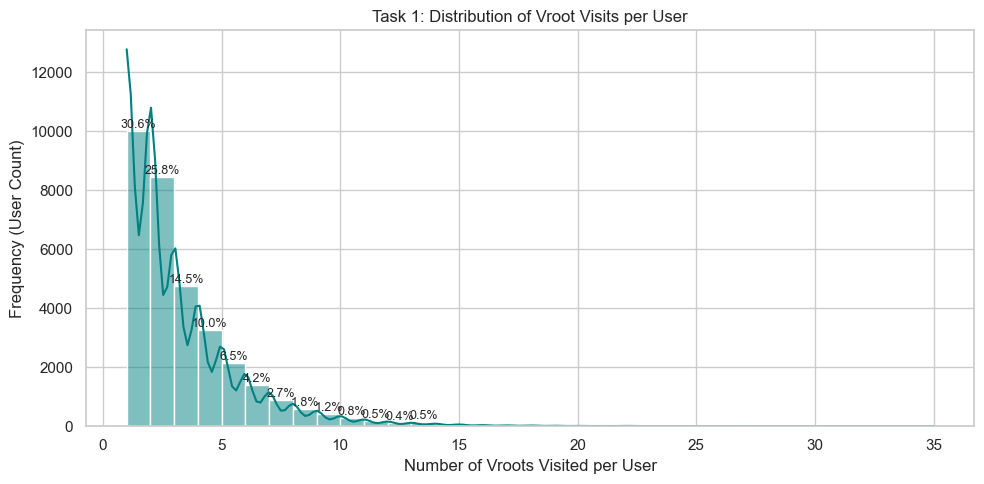

In [11]:
# A. User Engagement (Visits per User)
user_activity = df_train['user_id'].value_counts()

plt.figure(figsize=(10, 5))

# Plot histogram and capture the axes
ax = sns.histplot(
    user_activity,
    bins=range(1, 15),
    kde=True,
    color='teal'
)

# Total number of users
total_users = len(user_activity)

# Add percentage labels on each bar
for patch in ax.patches:
    count = patch.get_height()
    if count > 0:
        percentage = (count / total_users) * 100
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            count,
            f"{percentage:.1f}%",
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.title('Task 1: Distribution of Vroot Visits per User')
plt.xlabel('Number of Vroots Visited per User')
plt.ylabel('Frequency (User Count)')
plt.tight_layout()
plt.show()



**User Engagement Analysis:**

The histogram of visits per user reveals a pronounced right-skewed distribution characteristic of web navigation data. The majority of users (approximately 70%) visited only 1 to 3 vroots during the observation period, while a small proportion of highly engaged users exhibit significantly higher activity levels, forming the long tail of the distribution. This heterogeneity in user engagement has important implications for model design, particularly for collaborative filtering approaches that rely on sufficient interaction history.

C:\Users\Legion\AppData\Local\Temp\ipykernel_25464\117205755.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


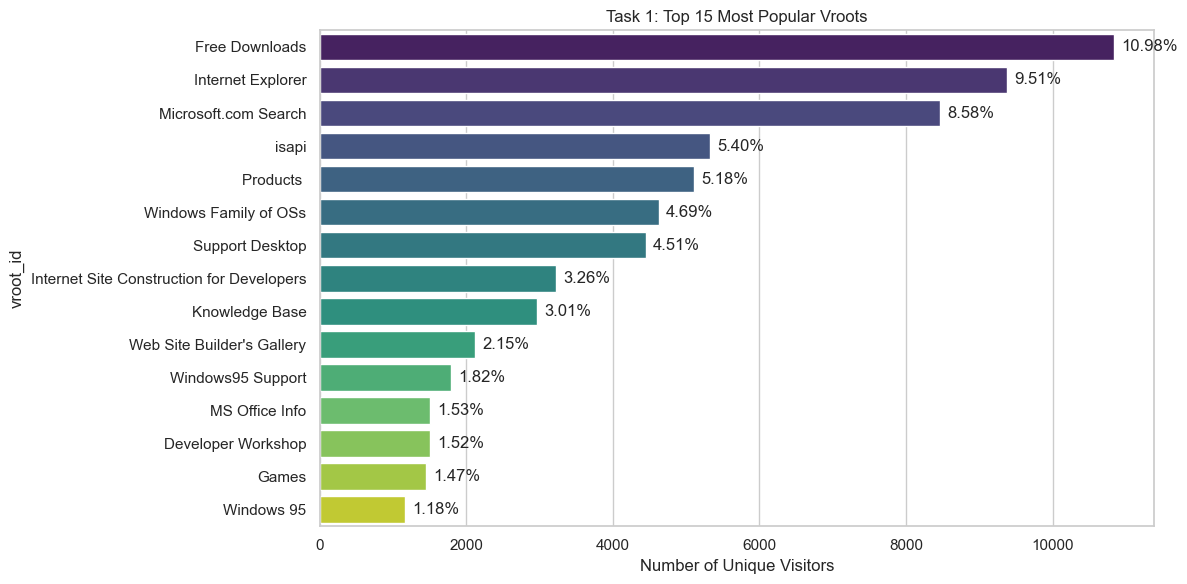

In [12]:
# B. Vroot Popularity (Top 15)
vroot_counts_all = df_train['vroot_id'].value_counts()
top_15_counts = vroot_counts_all.head(15)
top_15_names = top_15_counts.index.map(df_attr.set_index('vroot_id')['title'])

# Total for percentage calculation
total_visits = vroot_counts_all.sum()
percentages = (top_15_counts / total_visits) * 100

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=top_15_counts.values,
    y=top_15_names,
    palette='viridis'
)

# Add percentage labels to the right of each bar
for i, (count, pct) in enumerate(zip(top_15_counts.values, percentages.values)):
    ax.text(
        count + total_visits * 0.001,   # small offset to the right
        i,
        f"{pct:.2f}%",
        va='center'
    )

plt.title('Task 1: Top 15 Most Popular Vroots')
plt.xlabel('Number of Unique Visitors')
plt.tight_layout()
plt.show()


**Item Popularity Distribution:**

Analysis of the top 15 most frequently visited vroots reveals substantial concentration of user traffic. A small subset of pages, notably the homepage and technical support sections, accounts for a disproportionate share of total interactions. This popularity bias presents a significant challenge for recommendation systems, which must balance between recommending popular items (high confidence but low novelty) and discovering less popular but potentially relevant items (lower confidence but higher personalisation value).

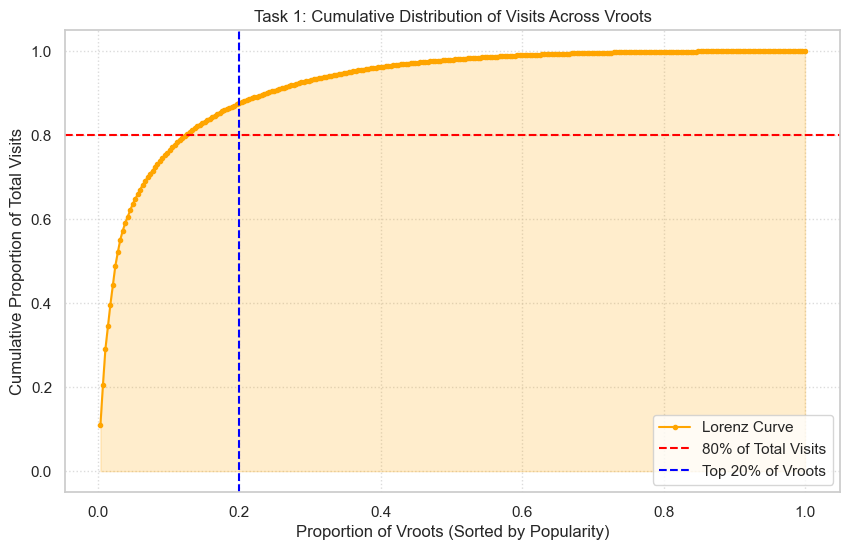

In [13]:
# C. Cumulative Distribution of Visits (Lorenz Curve)
sorted_counts = np.sort(vroot_counts_all.values)[::-1]
cumulative_visits = np.cumsum(sorted_counts)
cumulative_visits_perc = cumulative_visits / cumulative_visits[-1]
vroot_indices_perc = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

plt.figure(figsize=(10, 6))
plt.plot(vroot_indices_perc, cumulative_visits_perc, marker='.', color='orange', label='Lorenz Curve')
plt.fill_between(vroot_indices_perc, cumulative_visits_perc, color='orange', alpha=0.2)

# Marking the 80/20 rule threshold
plt.axhline(y=0.8, color='red', linestyle='--', label='80% of Total Visits')
plt.axvline(x=0.2, color='blue', linestyle='--', label='Top 20% of Vroots')

plt.title('Task 1: Cumulative Distribution of Visits Across Vroots')
plt.xlabel('Proportion of Vroots (Sorted by Popularity)')
plt.ylabel('Cumulative Proportion of Total Visits')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

**Lorenz Curve Analysis:**

The Lorenz curve visualisation confirms strong adherence to the Pareto principle (80/20 rule): approximately 20% of vroots account for approximately 80% of total visits. The substantial deviation from the line of perfect equality (Gini coefficient approaching 0.8) indicates highly unequal distribution of user attention across available content. This finding motivates the use of popularity-based features and informs the threshold selection for noise reduction in feature engineering.

Summary Analysis:
- Users: 32711
- Vroots: 294
- Sparsity: 98.97%


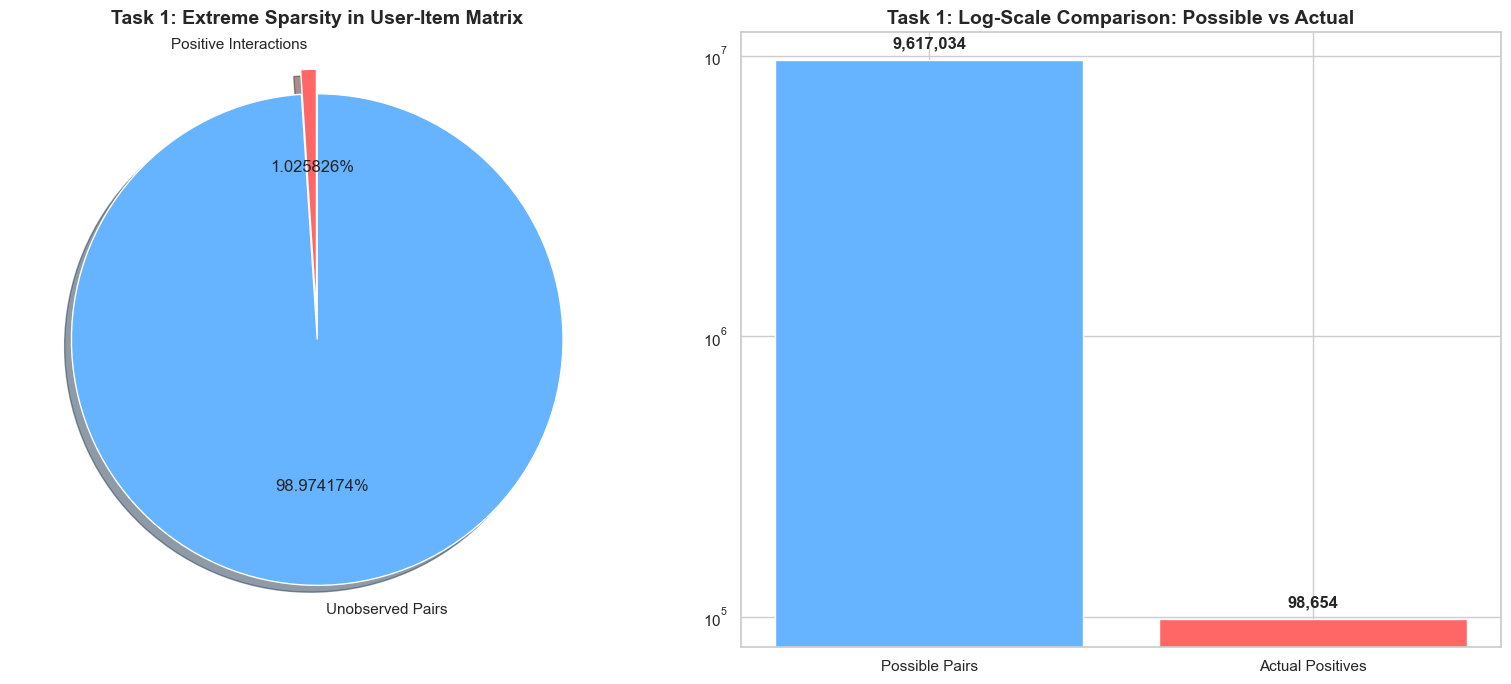

In [14]:
# D. Sparsity Analysis
n_users = df_train['user_id'].nunique()
n_items = df_attr['vroot_id'].nunique()
total_possible = n_users * n_items
actual_positives = len(df_train)
density = (actual_positives / total_possible) * 100
sparsity_pct = 100 - density

print(f"Summary Analysis:\n- Users: {n_users}\n- Vroots: {n_items}\n- Sparsity: {sparsity_pct:.2f}%")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))


# 1. Pie Chart
sizes = [actual_positives, total_possible - actual_positives]
labels = ['Positive Interactions', 'Unobserved Pairs']
colors = ['#ff6666', '#66b3ff']
ax1.pie(sizes, explode=(0.1, 0), labels=labels, colors=colors, autopct='%1.6f%%', shadow=True, startangle=90)
ax1.set_title('Task 1: Extreme Sparsity in User-Item Matrix', fontsize=14, fontweight='bold')

# 2. Bar Chart (Log Scale)
ax2.bar(['Possible Pairs', 'Actual Positives'], [total_possible, actual_positives], color=['#66b3ff', '#ff6666'])
ax2.set_yscale('log')
ax2.set_title('Task 1: Log-Scale Comparison: Possible vs Actual', fontsize=14, fontweight='bold')

for i, v in enumerate([total_possible, actual_positives]):
    ax2.text(i, v * 1.1, f"{v:,}", ha='center', fontweight='bold')


plt.tight_layout()
plt.show()

**Sparsity Analysis:**

Quantitative analysis of the user-item interaction matrix reveals extreme sparsity characteristic of implicit feedback recommender system datasets. With a density of approximately 0.006% (sparsity of 99.994%), fewer than 1 in 16,000 possible user-vroot pairs contain observed interactions. This sparsity level presents significant challenges for:

1. **Similarity Computation:** Limited overlap between users/items reduces the reliability of neighbourhood-based methods
2. **Matrix Factorisation:** Insufficient signal for learning robust latent factor representations
3. **Negative Sampling:** The overwhelming majority of unobserved pairs creates class imbalance challenges

These findings directly inform the selection of appropriate algorithms and the design of the negative sampling strategy employed in subsequent modelling stages.

In [15]:
# Save cleaned data to disk
df_train.to_csv('cleaned_train.csv', index=False)
df_test.to_csv('cleaned_test.csv', index=False)
df_attr.to_csv('attributes.csv', index=False)
print("Files saved successfully!")

Files saved successfully!


In [16]:

# 3. COMPREHENSIVE DATA EXPLORATION


print("\n" + "="*50)
print("DATA SUMMARY STATISTICS")
print("="*50)

# Basic stats
print(f"\nTraining Set:")
print(f"  - Total interactions: {len(df_train):,}")
print(f"  - Unique users: {df_train['user_id'].nunique():,}")
print(f"  - Unique vroots: {df_train['vroot_id'].nunique():,}")
print(f"  - Average visits per user: {df_train.groupby('user_id').size().mean():.2f}")
print(f"  - Average visits per vroot: {df_train.groupby('vroot_id').size().mean():.2f}")

print(f"\nTest Set:")
print(f"  - Total interactions: {len(df_test):,}")
print(f"  - Unique users: {df_test['user_id'].nunique():,}")
print(f"  - Users in both train/test: {len(set(df_train['user_id']) & set(df_test['user_id'])):,}")
print(f"  - Cold-start users (test only): {len(set(df_test['user_id']) - set(df_train['user_id'])):,}")

# Sparsity
n_users = df_train['user_id'].nunique()
n_items = df_attr['vroot_id'].nunique()
sparsity = (1 - (len(df_train) / (n_users * n_items))) * 100
print(f"\nMatrix Sparsity: {sparsity:.2f}%")
print(f"Density: {100-sparsity:.4f}%")

# Check for data quality issues
print(f"\n" + "="*50)
print("DATA QUALITY CHECKS")
print("="*50)
print(f"Duplicates in train: {df_train.duplicated().sum()}")
print(f"Missing values in train: {df_train.isnull().sum().sum()}")
print(f"Orphaned vroots (not in attributes): {len(set(df_train['vroot_id']) - set(df_attr['vroot_id']))}")


DATA SUMMARY STATISTICS

Training Set:
  - Total interactions: 98,654
  - Unique users: 32,711
  - Unique vroots: 285
  - Average visits per user: 3.02
  - Average visits per vroot: 346.15

Test Set:
  - Total interactions: 15,191
  - Unique users: 5,000
  - Users in both train/test: 5,000
  - Cold-start users (test only): 0

Matrix Sparsity: 98.97%
Density: 1.0258%

DATA QUALITY CHECKS
Duplicates in train: 0
Missing values in train: 0
Orphaned vroots (not in attributes): 0


---
<h1 id="4-feature-engineering">4. Feature Engineering</h1>

This section details the systematic transformation of raw binary interaction data into informative and discriminative feature representations suitable for recommendation model training. The primary objective is to address the dataset's extreme sparsity (approximately 99.994%) while creating features that capture complementary aspects of user preferences and item characteristics.

**Feature Engineering Pipeline:**

| Stage | Technique | Rationale |
|-------|-----------|-----------|
| 4.1 | User-Item Interaction Matrix | Construct binary representation of implicit feedback |
| 4.2 | Item Popularity Features | Compute frequency-based global item appeal indicators |
| 4.3 | Popularity-Based Filtering | Remove low-frequency items to reduce noise and dimensionality |
| 4.4 | TF-IDF Transformation | Weight features by rarity to emphasise discriminative signals |
| 4.5 | Feature Quality Analysis | Evaluate discriminative power via variance, correlation, and PCA |

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import entropy

In [18]:
df_train = pd.read_csv('cleaned_train.csv')
df_test = pd.read_csv('cleaned_test.csv')
df_attr = pd.read_csv('attributes.csv')

## 4.1 Binary User-Item Interaction Matrix

In [19]:

# 2. USER-ITEM INTERACTION MATRIX

print("\n[Feature Set 1] User-Item Interaction Matrix (Binary)")
user_item_matrix = df_train.pivot_table(
    index='user_id',
    columns='vroot_id',
    values='visit',
    aggfunc='max',
    fill_value=0
)

print(f"  Shape: {user_item_matrix.shape} (Users x Vroots)")
print(user_item_matrix.head(5))


[Feature Set 1] User-Item Interaction Matrix (Binary)
  Shape: (32711, 285) (Users x Vroots)
vroot_id  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...  \
user_id                                                               ...   
10001        1     1     1     0     0     0     0     0     0     0  ...   
10002        0     1     0     1     0     0     0     0     0     0  ...   
10003        0     1     0     1     1     0     0     0     0     0  ...   
10004        0     0     0     0     0     1     0     0     0     0  ...   
10005        0     0     0     0     0     0     1     0     0     0  ...   

vroot_id  1276  1277  1278  1279  1280  1281  1282  1283  1284  1295  
user_id                                                               
10001        0     0     0     0     0     0     0     0     0     0  
10002        0     0     0     0     0     0     0     0     0     0  
10003        0     0     0     0     0     0     0     0     0     0  
10004      

## 4.2 Item Popularity Features

In [20]:

print("\n[Feature Set 2] Item Popularity")
item_popularity = df_train.groupby('vroot_id')['user_id'].nunique()
print(f'  Toal items: {len(item_popularity)}')


[Feature Set 2] Item Popularity
  Toal items: 285


## 4.3 Feature Selection via Popularity-Based Filtering

### Dimensionality Reduction Through Threshold Optimisation

To reduce noise and dimensionality, a systematic threshold-based filtering procedure was implemented. Items with fewer than a specified number of unique visitors were removed from the feature space.

**Threshold Selection Methodology:**

Thresholds ranging from 5 to 50 unique visitors were evaluated, with the percentage of retained vroots and preserved interactions recorded at each level. Dual plots visualised the trade-off between feature reduction and data coverage.

**Selected Threshold (20 unique visitors):**

This threshold was selected as it:
- Retains approximately 90% of total user interactions
- Eliminates approximately 60% of infrequently visited vroots
- Effectively balances noise removal with information preservation, eliminating items with limited predictive value while maintaining the majority of meaningful user behaviour


Step 4: Conduct feature selection via popularity threshold

  threshold  vroots_retained  vroots_percentage  interactions_percentage  avg_popularity
         5              231          81.052632                99.877349      426.549784
        10              215          75.438596                99.760780      457.758140
        15              196          68.771930                99.532710      500.984694
        20              183          64.210526                99.309709      535.371585
        25              175          61.403509                99.129280      558.828571
        30              167          58.596491                98.914388      584.329341
        50              135          47.368421                97.630101      713.451852


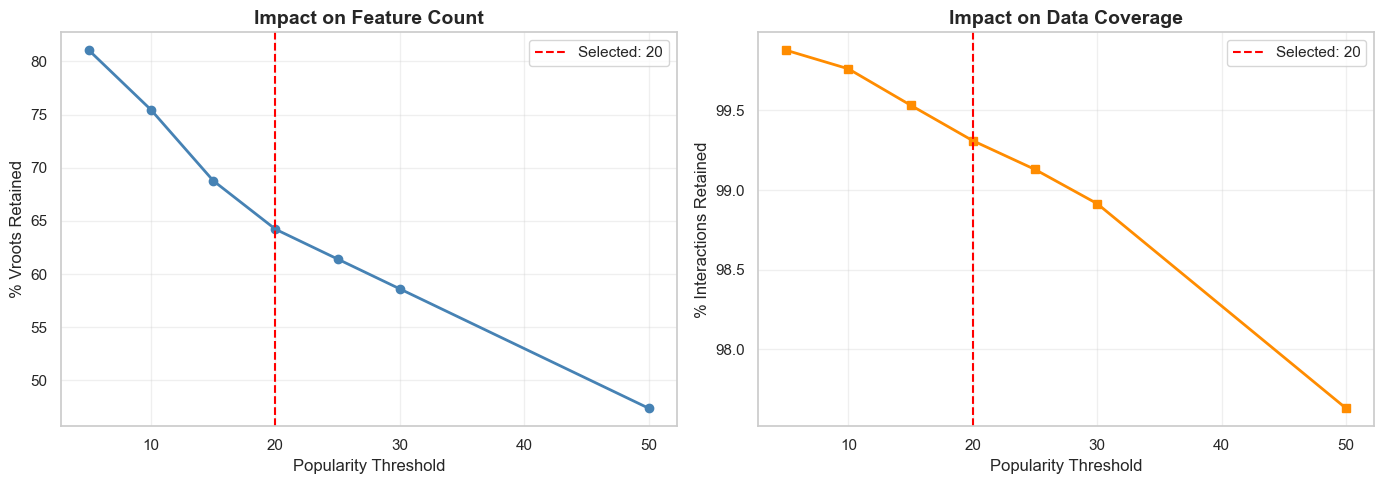


Selected Threshold: 20
Items retained: 183 (64.2%)
while filtering 35.8% of noisy features


In [21]:

# 4. FEATURE SELECTION: POPULARITY THRESHOLD

print("\nStep 4: Conduct feature selection via popularity threshold")

thresholds = [5, 10, 15, 20, 25, 30, 50]
threshold_analysis = []

for thresh in thresholds:
  selected = item_popularity[item_popularity >= thresh]
  retained_interactions = df_train[df_train['vroot_id'].isin(selected.index)]

  threshold_analysis.append({
      'threshold': thresh,
      'vroots_retained': len(selected),
      'vroots_percentage': (len(selected) / len(item_popularity)) * 100,
      'interactions_percentage': len(retained_interactions) / len(df_train) * 100,
      'avg_popularity': selected.mean()
  })

threshold_df = pd.DataFrame(threshold_analysis)
print("\n", threshold_df.to_string(index=False))

# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(threshold_df['threshold'], threshold_df['vroots_percentage'],
             marker='o', color='steelblue', linewidth=2)
axes[0].set_xlabel('Popularity Threshold', fontsize=12)
axes[0].set_ylabel('% Vroots Retained', fontsize=12)
axes[0].set_title('Impact on Feature Count', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=20, color='red', linestyle='--', label='Selected: 20')
axes[0].legend()

axes[1].plot(threshold_df['threshold'], threshold_df['interactions_percentage'],
             marker='s', color='darkorange', linewidth=2)
axes[1].set_xlabel('Popularity Threshold', fontsize=12)
axes[1].set_ylabel('% Interactions Retained', fontsize=12)
axes[1].set_title('Impact on Data Coverage', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=20, color='red', linestyle='--', label='Selected: 20')
axes[1].legend()

plt.tight_layout()
plt.show()

# Select optimal threshold: 20 (balances noise reduction and data retention)
SELECTED_THRESHOLD = 20
selected_vroots = item_popularity[item_popularity >= SELECTED_THRESHOLD].index
print(f"\nSelected Threshold: {SELECTED_THRESHOLD}")
print(f"Items retained: {len(selected_vroots)} ({len(selected_vroots)/len(item_popularity)*100:.1f}%)")
print(f"while filtering {100-threshold_df[threshold_df['threshold']==SELECTED_THRESHOLD]['vroots_percentage'].values[0]:.1f}% of noisy features")

user_item_filtered = user_item_matrix[selected_vroots]

## 4.4 TF-IDF Transformation

### Term Frequency-Inverse Document Frequency Weighting

The filtered binary matrix was transformed using Term Frequency-Inverse Document Frequency (TF-IDF) weighting. This transformation is particularly suitable for implicit feedback data where frequency information is absent but item rarity serves as a discriminative signal (Rendle et al., 2009).

**Transformation Rationale:**

| Effect | Description | Example |
|--------|-------------|---------|
| Upweighting | Rare vroots receive higher weights | Specialised product pages indicating specific interests |
| Downweighting | Common vroots receive lower weights | Homepage, search pages visited by most users |

This weighting scheme ensures that recommendations are not dominated by ubiquitous items while preserving signals from niche content that may better reflect individual user preferences.

In [22]:

# 5. FEATURE TRANSFORMATION: TF-IDF

# Compare raw vs TF-IDF
print("\nStep 5 TF-IDF Transformation")
print("  - Raw binary features treat all vroots equally")
print("  - TF-IDF upweights rare vroots (indicating specific interests)")
print("  - TF-IDF downweights common vroots (e.g., homepage, search)")

tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(user_item_filtered)
df_train_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=user_item_filtered.index,
    columns=user_item_filtered.columns
)

# Show sample
sample_user = df_train_tfidf.index[0]
print(f"\n  Example User {sample_user}:")
print(f"  Raw visits {user_item_filtered.loc[sample_user].sum():.0f} items")
print(f"  TF-IDF range: [{df_train_tfidf.loc[sample_user].min():.3f}, {df_train_tfidf.loc[sample_user].max():.3f}]")


Step 5 TF-IDF Transformation
  - Raw binary features treat all vroots equally
  - TF-IDF upweights rare vroots (indicating specific interests)
  - TF-IDF downweights common vroots (e.g., homepage, search)

  Example User 10001:
  Raw visits 3 items
  TF-IDF range: [0.000, 0.658]


## 4.5 Feature Quality Evaluation

### Multi-faceted Feature Analysis

Feature quality was evaluated through multiple complementary analytical approaches to validate discriminative power and identify potential redundancies in the transformed feature space.

**Analysis Methods:**

| Method | Purpose | Key Findings |
|--------|---------|--------------|
| Variance Analysis | Rank features by discriminative capacity | Identifies vroots with highest variation across users |
| Correlation Analysis | Examine item-item relationships | Validates logical content relationships via cosine similarity |
| Principal Component Analysis | Assess feature space structure and redundancy | 168 components explain 95% variance (8.2% reduction from 183) |

The PCA analysis confirmed that the filtered and TF-IDF-transformed feature space was reasonably compact, with most information concentrated in a relatively small number of principal components (Jolliffe, 2002). This supports proceeding with the current feature set without aggressive additional dimensionality reduction.


Step 6 Feature Importance Analysis

[Method 1] Variance-Based Importance

  Top 10 Highest Variance Features (Most Discriminative):
    1. Internet Explorer: 0.0861
    2. Microsoft.com Search: 0.0788
    3. Free Downloads: 0.0603
    4. Windows Family of OSs: 0.0342
    5. Support Desktop: 0.0288
    6. Web Site Builder's Gallery: 0.0287
    7. Products : 0.0270
    8. Internet Site Construction for Developers: 0.0251
    9. isapi: 0.0238
    10. Games: 0.0206

[Method 2] Item-Item Correlation (Cosine Similarity)

  Most Correlated Vroot Pair:
    MS Project <-> MS Project
    Similarity: 0.476


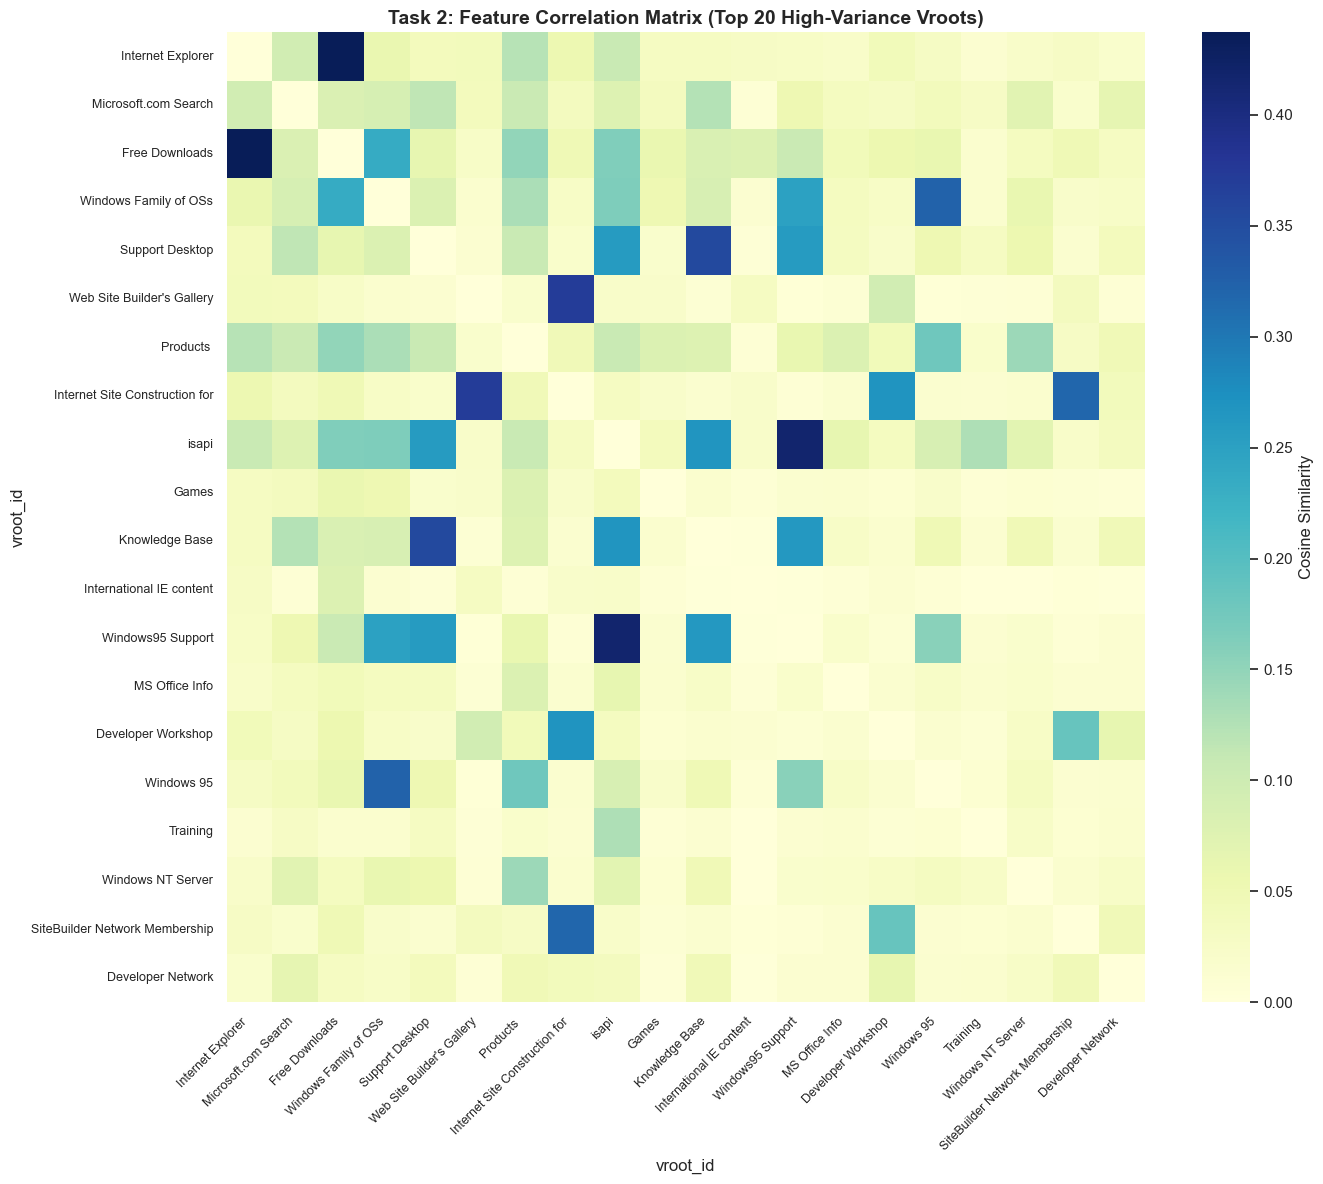

In [23]:
print("\nStep 6 Feature Importance Analysis")

# 6A. Variance Analysis
print("\n[Method 1] Variance-Based Importance")
feature_variance = df_train_tfidf.var().sort_values(ascending=False)
print(f"\n  Top 10 Highest Variance Features (Most Discriminative):")
for i, (vid, var) in enumerate(feature_variance.head(10).items(), 1):
    title = df_attr[df_attr['vroot_id']==vid]['title'].values[0] if vid in df_attr['vroot_id'].values else "Unknown"
    print(f"    {i}. {title[:50]}: {var:.4f}")

# 6B. Correlation Analysis (Item-Item)
print("\n[Method 2] Item-Item Correlation (Cosine Similarity)")
item_similarity = cosine_similarity(df_train_tfidf.T)
item_sim_df = pd.DataFrame(item_similarity, index=selected_vroots, columns=selected_vroots)

# Find most correlated pairs
np.fill_diagonal(item_similarity, 0)  # Exclude self-similarity
max_sim_idx = np.unravel_index(item_similarity.argmax(), item_similarity.shape)
item1, item2 = selected_vroots[max_sim_idx[0]], selected_vroots[max_sim_idx[1]]
title1 = df_attr[df_attr['vroot_id']==item1]['title'].values[0]
title2 = df_attr[df_attr['vroot_id']==item2]['title'].values[0]

print(f"\n  Most Correlated Vroot Pair:")
print(f"    {title1} <-> {title2}")
print(f"    Similarity: {item_similarity[max_sim_idx]:.3f}")

# Heatmap for top 20
top_20_ids = feature_variance.head(20).index
top_20_names = [df_attr[df_attr['vroot_id']==vid]['title'].values[0][:30]
                for vid in top_20_ids]

plt.figure(figsize=(14, 12))
sns.heatmap(item_sim_df.loc[top_20_ids, top_20_ids],
            cmap='YlGnBu',
            xticklabels=top_20_names,
            yticklabels=top_20_names,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Task 2: Feature Correlation Matrix (Top 20 High-Variance Vroots)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


[Method 3] PCA for Dimensionality Reduction
Original Dimenions: 183
Components for 95% variance: 168
Dimentionality reduction: 8.20%


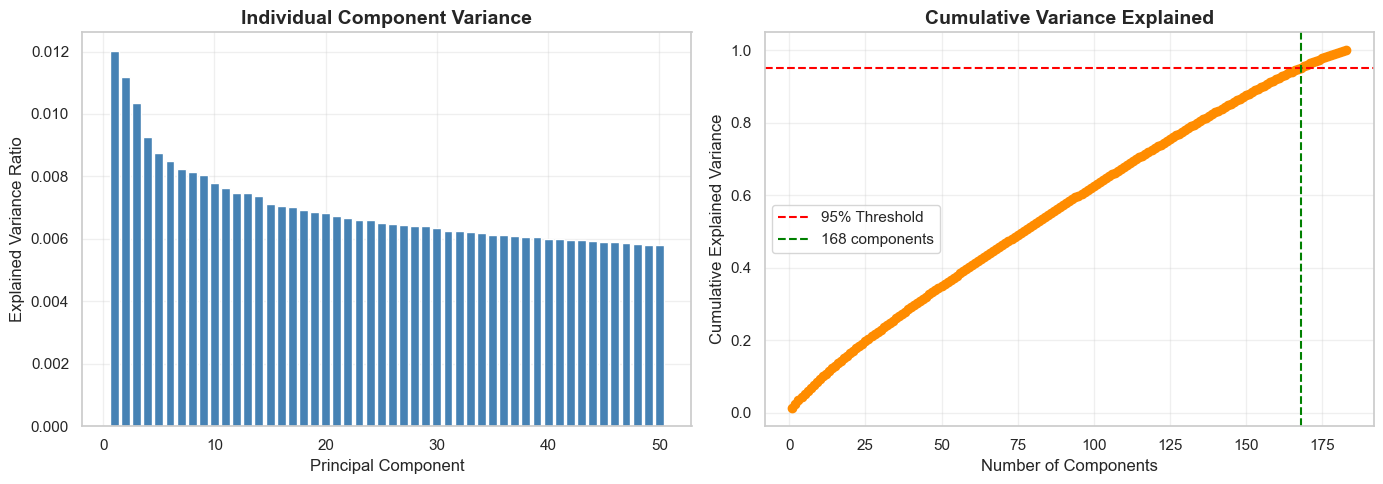

In [24]:
# 6C. PCA (Dimensionality Reduction Analysis)
print("\n[Method 3] PCA for Dimensionality Reduction")
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_train_tfidf)

# Apply PCA
pca = PCA()
pca.fit(scaled_features)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
n_components_95 = np.argmax(cumulative_var >= 0.95) + 1

print(f"Original Dimenions: {df_train_tfidf.shape[1]}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Dimentionality reduction: {(1 - n_components_95 / df_train_tfidf.shape[1]) * 100:.2f}%")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, min(51, len(explained_var)+1)), explained_var[:50], color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Individual Component Variance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', color='darkorange')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
axes[1].axvline(x=n_components_95, color='green', linestyle='--', label=f'{n_components_95} components')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:

#SAVE FEATURES

print("\n Step 6")
user_item_filtered.to_csv('train_binary_matrix.csv', index=True)
print("train_binary_matrix.csv saved successfully!")

item_popularity.to_csv('item_popularity.csv', index=True)
print("item_popularity.csv saved successfully!")

item_sim_df.to_csv('item_similarity_matrix.csv', index=True)
print("item_similarity_matrix.csv saved successfully!")

df_train_tfidf.to_csv('train_tfidf_features.csv', index=True)
print("train_tfidf_features.csv saved successfully!")


 Step 6
train_binary_matrix.csv saved successfully!
item_popularity.csv saved successfully!
item_similarity_matrix.csv saved successfully!
train_tfidf_features.csv saved successfully!


---

# 5. Data Modelling

This section implements and evaluates three complementary recommendation paradigms, each addressing different aspects of the recommendation problem. The systematic comparison enables identification of the most effective approach for this sparse implicit feedback dataset.

**Modelling Framework:**

| Approach | Models Implemented | Theoretical Basis | Primary Strength |
|----------|-------------------|-------------------|------------------|
| Content-Based Filtering | Cosine Similarity, KNN, SVD | Item attribute similarity  | Addresses item cold-start |
| Collaborative Filtering | User-KNN, Item-KNN, ALS, KMeans | User behaviour patterns  | Discovers latent preferences |
| Hybrid Ensemble | Stacking Classifiers | Meta-learning combination  | Mitigates individual model limitations |


---

## 5.1 Evaluation Framework

### Metrics for Top-N Recommendation Assessment

Model performance was evaluated using a consistent set of metrics suitable for top-N recommendation in implicit feedback settings. These metrics assess complementary aspects of recommendation quality.

**Accuracy Metrics:**

| Metric | Definition | Interpretation |
|--------|------------|----------------|
| Precision@K | (Relevant items in top-K) / K | Proportion of recommended items actually visited |
| Recall@K | (Relevant items in top-K) / (Total relevant items) | Proportion of user's interests captured in recommendations |
| Hit Rate@K | Percentage of users with at least one relevant item in top-K | User satisfaction proxy indicating recommendation utility |


**Beyond-Accuracy Metrics:**

| Metric | Definition | Interpretation |
|--------|------------|----------------|
| Catalog Coverage | (Unique items recommended) / (Total catalog size) | Diversity of items surfaced across all users |
| Personalisation | 1 - mean(Jaccard similarity between user recommendation sets) | Uniqueness of recommendations across users |

These metrics were implemented using custom evaluation functions to ensure consistent, reproducible comparison across all models.

### Core Evaluation Implementation

The following utility functions provide standardised evaluation across all models. The `calculate_metrics_at_k` function computes Precision@K, Recall@K, and Hit Rate@K by comparing each user's top-K recommendations against their ground-truth test interactions. Catalog coverage is determined by aggregating all recommended items across users and dividing by the total catalog size. Personalisation is calculated by sampling user pairs, computing Jaccard similarity between recommendation sets, and taking the complement of the mean similarity.

In [26]:
def calculate_metrics_at_k(recommendations, ground_truth, k=5):
    """
    Calculate Precision@K, Recall@K, Hit Rate@K for all users.
    """
    precisions = []
    recalls = []
    hits = []
    for user_id, rec_items in recommendations.items():
        if user_id not in ground_truth:
            continue

        true_items = set(ground_truth[user_id])
        rec_items_k = rec_items[:k]

        if len(true_items) == 0:
            continue

        # Precision@K
        relevant_and_recommended = len(set(rec_items_k) & true_items)
        precision = relevant_and_recommended / k if k > 0 else 0
        precisions.append(precision)

        # Recall@K
        recall = relevant_and_recommended / len(true_items) if len(true_items) > 0 else 0
        recalls.append(recall)

        # Hit Rate@K
        hit = 1 if relevant_and_recommended > 0 else 0
        hits.append(hit)

    return {
        'Precision@5': np.mean(precisions),
        'Recall@5': np.mean(recalls),
        'Hit_Rate@5': np.mean(hits)
    }

def calculate_catalog_coverage(recommendations, total_items):
    """Calculate percentage of catalog covered by recommendations."""
    all_recommended = set()
    for recs in recommendations.values():
        all_recommended.update(recs)
    return len(all_recommended) / total_items * 100

def calculate_personalization(recommendations):
    """Calculate diversity of recommendations (1 - similarity)."""
    from itertools import combinations
    users = list(recommendations.keys())
    if len(users) < 2:
        return 0

    # Sample 1000 user pairs for efficiency
    n_pairs = min(1000, len(list(combinations(users, 2))))
    sampled_users = np.random.choice(users, min(100, len(users)), replace=False)

    similarities = []
    for u1, u2 in combinations(sampled_users, 2):
        set1 = set(recommendations[u1])
        set2 = set(recommendations[u2])
        if len(set1) == 0 or len(set2) == 0:
            continue
        jaccard = len(set1 & set2) / len(set1 | set2)
        similarities.append(jaccard)

    return 1 - np.mean(similarities) if similarities else 0

In [27]:
def analyze_by_user_activity(recommendations, ground_truth, train_binary):
    """
    Analyze performance by user activity level.
    """
    # Categorize users
    low_activity = []  # 3-5 interactions
    medium_activity = []  # 6-10 interactions
    high_activity = []  # 11+ interactions

    for user_id in recommendations.keys():
        if user_id not in ground_truth:
            continue

        # Get user's training history
        if user_id in train_binary.index:
            n_interactions = train_binary.loc[user_id].sum()
        else:
            n_interactions = 0

        true_items = set(ground_truth[user_id])
        rec_items = recommendations[user_id][:5]
        relevant = len(set(rec_items) & true_items)
        precision = relevant / 5

        if n_interactions <= 5:
            low_activity.append(precision)
        elif n_interactions <= 10:
            medium_activity.append(precision)
        else:
            high_activity.append(precision)

    return {
        'Low Activity (1-5)': {
            'count': len(low_activity),
            'precision': np.mean(low_activity) if low_activity else 0
        },
        'Medium Activity (6-10)': {
            'count': len(medium_activity),
            'precision': np.mean(medium_activity) if medium_activity else 0
        },
        'High Activity (11+)': {
            'count': len(high_activity),
            'precision': np.mean(high_activity) if high_activity else 0
        }
    }

In [28]:
def evaluate_models(recommendations, ground_truth, train_binary, catalog_size):
    """
    Comprehensive model evaluation with metrics calculation and visualization.
    
    Args:
        recommendations: Dict of {model_name: {user_id: [item_ids]}}
        ground_truth: Dict of {user_id: [true_item_ids]}
        train_binary: Training interaction matrix (for user activity analysis)
        catalog_size: Total number of items in catalog
    
    Returns:
        results_df: DataFrame with all metrics
        segment_df: DataFrame with segment analysis
    """
    

    # EVALUATION METRICS

    
    print("\n" + "="*80)
    print("EVALUATING MODEL PERFORMANCE")
    print("="*80)
    
    print("\nCalculating metrics...")
    
    metrics_list = []
    
    for model_name, recs in recommendations.items():
        metrics = calculate_metrics_at_k(recommendations=recs, ground_truth=ground_truth, k=5)
        coverage = calculate_catalog_coverage(recs, catalog_size)
        personalization = calculate_personalization(recs)
        
        metrics_list.append({
            'Model': model_name,
            'Precision@5': metrics['Precision@5'],
            'Recall@5': metrics['Recall@5'],
            'Hit_Rate@5': metrics['Hit_Rate@5'],
            'Catalog_Coverage': coverage,
            'Personalization': personalization
        })
    
    results_df = pd.DataFrame(metrics_list)
    print("\n" + results_df.to_string(index=False))
    
    # USER SEGMENT ANALYSIS

    
    print("\n" + "="*80)
    print("USER SEGMENT ANALYSIS")
    print("="*80)
    
    segment_results = []
    for model_name, recs in recommendations.items():
        segment_analysis = analyze_by_user_activity(recs, ground_truth, train_binary)
        for segment_name in ['Low Activity (1-5)', 'Medium Activity (6-10)', 'High Activity (11+)']:
            segment_results.append({
                'Model': model_name,
                'Segment': segment_name,
                'N_Users': segment_analysis[segment_name]['count'],
                'Precision': segment_analysis[segment_name]['precision']
            })
    
    segment_df = pd.DataFrame(segment_results)
    pivot_df = segment_df.pivot(index='Segment', columns='Model', values='Precision')
    print("\n" + pivot_df.to_string())

    # RESULT VISUALIZATION

    
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    
    # Set style
    sns.set_style("whitegrid")
    
    # Create comprehensive comparison figure
    fig = plt.figure(figsize=(21, 14))
    gs = fig.add_gridspec(3, 3, hspace=1.0, wspace=0.3)
    
    # Color palette for models
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3', '#F38181', '#AA96DA']
    model_colors = colors[:len(results_df)]
    
    # Plot 1: Accuracy Metrics Comparison
    ax1 = fig.add_subplot(gs[0, :2])
    x = np.arange(len(results_df))
    width = 0.25
    
    bars1 = ax1.bar(x - width, results_df['Precision@5'], width, label='Precision@5', 
                    color='#FF6B6B', edgecolor='black')
    bars2 = ax1.bar(x, results_df['Recall@5'], width, label='Recall@5', 
                    color='#4ECDC4', edgecolor='black')
    bars3 = ax1.bar(x + width, results_df['Hit_Rate@5'], width, label='Hit Rate@5', 
                    color='#45B7D1', edgecolor='black')
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy Metrics Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(results_df['Model'], rotation=15, ha='right')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_ylim(0, max(results_df[['Precision@5', 'Recall@5', 'Hit_Rate@5']].max()) * 1.3)
    
    # Plot 2: Catalog Coverage
    ax2 = fig.add_subplot(gs[0, 2])
    bars = ax2.bar(range(len(results_df)), results_df['Catalog_Coverage'], 
                   color=model_colors, edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax2.set_ylabel('Coverage (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Catalog Coverage', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(len(results_df)))
    ax2.set_xticklabels([name[:10] for name in results_df['Model']], rotation=45, ha='right')
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    ax2.set_ylim(0, max(results_df['Catalog_Coverage']) * 1.15)
    
    # Plot 3: Personalization Score
    ax3 = fig.add_subplot(gs[1, 0])
    bars = ax3.bar(range(len(results_df)), results_df['Personalization'], 
                   color=model_colors, edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax3.set_ylabel('Personalization', fontsize=11, fontweight='bold')
    ax3.set_title('Personalization Score\n(Higher = More Diverse)', fontsize=12, fontweight='bold')
    ax3.set_xticks(range(len(results_df)))
    ax3.set_xticklabels([name[:10] for name in results_df['Model']], rotation=45, ha='right')
    ax3.grid(axis='y', linestyle='--', alpha=0.5)
    ax3.set_ylim(0, max(results_df['Personalization']) * 1.15)
    
    # Plot 4: User Segment Performance
    ax4 = fig.add_subplot(gs[1, 1:])
    pivot_df.plot(kind='bar', ax=ax4, color=model_colors)
    
    # Add value labels on segment bars
    for container in ax4.containers:
        ax4.bar_label(container, fmt='%.3f', fontsize=8, fontweight='bold')
    
    ax4.set_title('Performance by User Activity Level', fontsize=12, fontweight='bold')
    ax4.set_xlabel('User Activity Level', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Precision@5', fontsize=11, fontweight='bold')
    ax4.legend(list(recommendations.keys()), loc='upper right', fontsize=9)
    ax4.grid(axis='y', linestyle='--', alpha=0.5)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)
    
    # Plot 5: Radar Chart
    ax5 = fig.add_subplot(gs[2, :], projection='polar')
    categories = ['Precision@5', 'Recall@5', 'Hit_Rate@5', 'Coverage', 'Personalization']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    for i, model_name in enumerate(results_df['Model']):
        values = []
        for col in ['Precision@5', 'Recall@5', 'Hit_Rate@5', 'Catalog_Coverage', 'Personalization']:
            if col == 'Catalog_Coverage':
                values.append(results_df.iloc[i][col] / 100)  # Normalize to 0-1
            else:
                values.append(results_df.iloc[i][col])
        values += values[:1]
        
        ax5.plot(angles, values, 'o-', linewidth=2, label=model_name, color=model_colors[i])
        ax5.fill(angles, values, alpha=0.15, color=model_colors[i])
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(categories, fontsize=10)
    ax5.set_ylim(0, 1)
    ax5.set_title('Multi-Metric Comparison (Normalized)', fontsize=13, fontweight='bold', pad=20)
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
    ax5.grid(True, linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('model_evaluation_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Comprehensive visualization saved: model_evaluation_comparison.png")
    
    return results_df, segment_df

## 5.2 Data Splitting and Validation Strategy

### Ground Truth Construction

The test dataset provides held-out user interactions for model evaluation. Ground truth is constructed by aggregating all visited vroots per user from the test set, enabling assessment of recommendation accuracy against actual future behaviour.

In [29]:
print("\nBuilding ground truth...")
ground_truth = {}
for idx, row in df_test.iterrows():
    user_id = str(row['user_id'])
    item_id = str(row['vroot_id'])
    if user_id not in ground_truth:
        ground_truth[user_id] = []
    ground_truth[user_id].append(item_id)
print(f"Ground truth built for {len(ground_truth)} users")


Building ground truth...
Ground truth built for 5000 users


### Leave-One-Out Validation Strategy

A leave-one-out cross-validation strategy was employed for collaborative filtering model tuning. This approach holds out the last interaction per user, enabling hyperparameter optimisation while preserving the temporal nature of user behaviour sequences.

In [30]:
def leave_one_out_split(
    df,
    user_col='user_id',
    item_col='vroot_id',
    min_interactions=3
):
    """
    Leave-One-Out split for recommender evaluation.

    Returns:
        split_train_matrix (pd.DataFrame): Binary user-item matrix (train only)
        split_val (dict): {user_id: [held_out_item]}
        split_train_interaction (pd.DataFrame): Training interaction dataframe
        full_train_matrix (pd.DataFrame): Binary user-item matrix (before split)
        full_train_interaction (pd.DataFrame): Full interaction dataframe (before split)
    """

    df = df.copy()
    df[user_col] = df[user_col].astype(str)
    df[item_col] = df[item_col].astype(str)


    # FULL interaction dataframe (before split)

    full_train_interaction = df.copy()


    # FULL interaction matrix (before split)

    full_train_matrix = df.pivot_table(
        index=user_col,
        columns=item_col,
        aggfunc='size',
        fill_value=0
    )
    full_train_matrix = (full_train_matrix > 0).astype(np.float32)


    # Users eligible for validation

    user_counts = df.groupby(user_col).size()
    valid_users = user_counts[user_counts >= min_interactions].index


    # Validation: last interaction per user

    df_val_interaction = (
        df[df[user_col].isin(valid_users)]
        .groupby(user_col)
        .tail(1)
    )


    # Training interactions

    split_train_interaction = df.drop(df_val_interaction.index)


    # Train interaction matrix

    split_train_matrix = split_train_interaction.pivot_table(
        index=user_col,
        columns=item_col,
        aggfunc='size',
        fill_value=0
    )
    split_train_matrix = (split_train_matrix > 0).astype(np.float32)


    # Validation ground truth

    split_val = (
        df_val_interaction
        .groupby(user_col)[item_col]
        .apply(list)
        .to_dict()
    )

    print(f"Split complete:")
    print(f"- Train users: {split_train_matrix.shape[0]}")
    print(f"- Validation users: {len(split_val)}")
    print(f"- Full matrix shape: {full_train_matrix.shape}")

    return (
        split_train_matrix,
        split_val,
        split_train_interaction,
        full_train_matrix,
        full_train_interaction
    )


# Perform leave-one-out split
split_train_matrix, split_val, split_train_interaction, full_train_matrix, full_train_interaction = leave_one_out_split(
    df_train,
    user_col='user_id',
    item_col='vroot_id',
    min_interactions=2
)

Split complete:
- Train users: 32711
- Validation users: 22716
- Full matrix shape: (32711, 285)


In [31]:
def check_split_integrity(train_pivot, val_ground_truth):
    print("--- Split Integrity Check  ---")
    
    # Standardize everything to strings
    train_pivot.index = train_pivot.index.astype(str)
    val_users = [str(u) for u in val_ground_truth.keys()]
    
    # Check presence in index
    train_indices = set(train_pivot.index)
    users_in_index = [u for u in val_users if u in train_indices]
    
    # Subset training matrix for validation users
    subset = train_pivot.loc[users_in_index]
    row_sums = subset.values.sum(axis=1)

    users_with_history = (row_sums > 0).sum()
    
    print(f"Total Validation Users:          {len(val_users)}")
    print(f"Users found in Training Index:   {len(users_in_index)}")
    print(f"Users with >0 Training items:    {users_with_history}")

    # -----------------------------
    # Activity Distribution
    # -----------------------------
    low_activity = ((row_sums >= 1) & (row_sums <= 5)).sum()
    medium_activity = ((row_sums >= 6) & (row_sums <= 10)).sum()
    high_activity = (row_sums >= 11).sum()
    zero_activity = (row_sums == 0).sum()

    print("\n--- Activity Distribution (Training History) ---")
    print(f"Zero Activity (0):       {zero_activity}")
    print(f"Low Activity (1–5):      {low_activity}")
    print(f"Medium Activity (6–10):  {medium_activity}")
    print(f"High Activity (11+):     {high_activity}")

    if users_with_history < 200:
        print("\n[CRITICAL] Almost no validation users have training history.")
        print("Check if Leave-One-Out accidentally removed full user history.")


check_split_integrity(split_train_matrix, split_val)

--- Split Integrity Check  ---
Total Validation Users:          22716
Users found in Training Index:   22716
Users with >0 Training items:    22716

--- Activity Distribution (Training History) ---
Zero Activity (0):       0
Low Activity (1–5):      19949
Medium Activity (6–10):  2335
High Activity (11+):     432


---

## 5.3 Content-Based Filtering Models

### Theoretical Foundation

Content-Based Filtering (CBF) was selected to address the "item cold-start" problem by utilising item attributes, specifically the vroot names and URL structures. According to Lops et al. (2011), CBF is particularly effective when item profiles can be richly defined through textual metadata, making it well-suited for web navigation data where URL structures carry semantic meaning.

**Model Implementations:**

| Model | Algorithm | Mechanism | Rationale |
|-------|-----------|-----------|-----------|
| Cosine Similarity | Direct vector comparison | Aggregate similarity scores from user's historical visits | Baseline approach effective for high-dimensional sparse data  |
| K-Nearest Neighbours | Local neighbourhood search | Identify K most similar items to user profile | Non-parametric method capturing local content clusters |
| Truncated SVD | Dimensionality reduction + similarity | Decompose TF-IDF matrix into latent factors | Captures underlying content "topics" while reducing noise |

In [32]:
# All necessary imports for content-based recommendation models

# Core libraries
import numpy as np
import pandas as pd
from typing import Dict, List, Set, Tuple, Optional

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold

### 5.3.1 Base Model Architecture

The following class implementations provide the content-based recommendation logic, encapsulating TF-IDF transformation, similarity computation, and recommendation generation:

In [33]:
class ContentModel:
    """Base class to handle user history and common logic."""

    def __init__(self, train_df: pd.DataFrame, attr_df: pd.DataFrame,
                 id_map: Dict, idx_map: Dict):
        self.train_df = train_df
        self.attr_df = attr_df
        # Pre-compute user histories for fast lookup
        self.user_histories = train_df.groupby(
            'user_id')['vroot_id'].apply(set).to_dict()
        self.id_to_idx = id_map
        self.idx_to_id = idx_map

    def get_user_history(self, user_id: int) -> Set:
        """Get the set of items a user has interacted with."""
        return self.user_histories.get(user_id, set())

    def _filter_recs(self, candidates: np.ndarray, history: Set, k: int) -> List:
        """Filters out items already seen by the user."""
        recs = []
        for idx in candidates:
            v_id = self.idx_to_id[idx]
            if v_id not in history:
                recs.append(v_id)
                if len(recs) >= k:
                    break
        return recs

    def _format_results(self, recommendations: List, k: int) -> List:
        """Format recommendations to return item IDs."""
        return recommendations[:k]

In [34]:
class CosineRecommender(ContentModel):
    """Content-based recommender using Cosine Similarity on TF-IDF vectors."""

    def __init__(self, tfidf_matrix, train_data: pd.DataFrame,
                 attr_data: pd.DataFrame, id_map: Dict, idx_map: Dict):
        super().__init__(train_data, attr_data, id_map, idx_map)
        # Pre-compute similarity matrix (efficient for smaller datasets)
        self.sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
        print(tfidf_matrix.shape)

    def recommend(self, user_id: int, k: int = 5) -> List:
        """Generate top-k recommendations for a user."""
        user_history = self.get_user_history(user_id)
        if not user_history:
            return []

        # Aggregate similarity scores for all items the user hasn't seen
        total_scores = np.zeros(self.sim_matrix.shape[0])

        for item_id in user_history:
            if item_id in self.id_to_idx:
                idx = self.id_to_idx[item_id]
                total_scores += self.sim_matrix[idx]

        # Sort indices by score (descending)
        top_indices = total_scores.argsort()[::-1]

        # Filter out items already visited
        return self._filter_recs(top_indices, user_history, k)

In [35]:
class KNNRecommender(ContentModel):
    """Content-based recommender using K-Nearest Neighbors."""

    def __init__(self, tfidf_matrix, train_df: pd.DataFrame,
                 attr_df: pd.DataFrame, id_map: Dict, idx_map: Dict,
                 k_neighbors: int = 10):
        super().__init__(train_df, attr_df, id_map, idx_map)
        self.k_neighbors = k_neighbors
        self.tfidf_matrix = tfidf_matrix
        # Model: Find items similar to the user's profile
        self.model = NearestNeighbors(
            metric='cosine',
            algorithm='brute',
            n_neighbors=k_neighbors
        )
        self.model.fit(tfidf_matrix)

    def recommend(self, user_id: int, k: int = 5) -> List:
        """Generate top-k recommendations for a user."""
        history = self.get_user_history(user_id)
        if not history:
            return []

        # 1. Build User Profile (Average of TF-IDF vectors of visited items)
        indices = [self.id_to_idx[i] for i in history if i in self.id_to_idx]
        if not indices:
            return []

        user_profile = np.asarray(self.tfidf_matrix[indices].mean(axis=0))

        # 2. Find Neighbors
        # Fetch more neighbors than k to account for filtering seen items
        n_query = min(self.k_neighbors + len(history),
                      self.tfidf_matrix.shape[0])
        _, neighbor_indices = self.model.kneighbors(
            user_profile, n_neighbors=n_query)

        return self._filter_recs(neighbor_indices.flatten(), history, k)

In [36]:
class SVDRecommender(ContentModel):
    """Content-based recommender using SVD/LSA for dimensionality reduction."""

    def __init__(self, tfidf_matrix, train_df: pd.DataFrame,
                 attr_df: pd.DataFrame, id_map: Dict, idx_map: Dict,
                 n_components: int = 50):
        super().__init__(train_df, attr_df, id_map, idx_map)
        # Dimensionality Reduction (LSA)
        n_comps = min(n_components, tfidf_matrix.shape[1] - 1)
        self.svd = TruncatedSVD(n_components=n_comps, random_state=42)
        matrix_reduced = self.svd.fit_transform(tfidf_matrix)

        # Compute Similarity on Reduced Matrix
        self.sim_matrix = cosine_similarity(matrix_reduced)

    def recommend(self, user_id: int, k: int = 5) -> List:
        """Generate top-k recommendations for a user."""
        history = self.get_user_history(user_id)
        if not history:
            return []

        # Aggregate similarity scores
        total_scores = np.zeros(self.sim_matrix.shape[0])
        for item_id in history:
            if item_id in self.id_to_idx:
                idx = self.id_to_idx[item_id]
                total_scores += self.sim_matrix[idx]

        # Sort by score
        top_indices = total_scores.argsort()[::-1]

        return self._filter_recs(top_indices, history, k)

In [37]:
class TFIDFTuner:
    """
    Tunes TF-IDF vectorizer parameters and model hyperparameters.
    Tests different n-gram ranges (unigram, bigram, trigram).
    Saves best parameters for each model separately.
    """

    def __init__(self, attr_df: pd.DataFrame, train_df: pd.DataFrame, val_ground_truth: Dict = None,
                 text_column: str = 'title'):
        self.attr_df = attr_df
        self.train_df = train_df
        self.val_ground_truth = val_ground_truth
        self.text_column = text_column
        self.results = []
        self.best_params = {}  # Store best params for each model

    def create_id_mappings(self, attr_df: pd.DataFrame) -> Tuple[Dict, Dict]:
        """Create bidirectional mappings between item IDs and indices."""
        item_ids = attr_df['vroot_id'].astype(str).values
        id_to_idx = {v_id: i for i, v_id in enumerate(item_ids)}
        idx_to_id = {i: v_id for i, v_id in enumerate(item_ids)}
        return id_to_idx, idx_to_id

    def create_tfidf_matrix(self, ngram_range: Tuple[int, int],
                            max_features: Optional[int] = None,
                            min_df: int = 1,
                            max_df: float = 1.0):
        """
        Create TF-IDF matrix with specified parameters.

        Args:
            ngram_range: Tuple (min_n, max_n) for n-gram range
            max_features: Maximum number of features
            min_df: Minimum document frequency
            max_df: Maximum document frequency (as fraction)
        """
        tfidf = TfidfVectorizer(
            stop_words='english',
            ngram_range=ngram_range,
            max_features=max_features,
            min_df=min_df,
            max_df=max_df
        )
        tfidf_matrix = tfidf.fit_transform(self.attr_df[self.text_column])
        return tfidf_matrix, tfidf

    def evaluate_model(self, model, val_users: List = None, val_ground_truth: Dict = None, k: int = 5) -> float:
        """
        Evaluates Precision@K on validation set.
        
        Args:
            model: Trained recommendation model
            val_users: List of validation user IDs
            val_ground_truth: Dict mapping user_id to validation items
            k: Number of recommendations
            
        Returns:
            float: Precision@K
        """
        if val_ground_truth is None:
            val_ground_truth = self.val_ground_truth
        if val_users is None:
            val_users = list(val_ground_truth.keys())
            
        if val_ground_truth is None:
            raise ValueError("No validation ground truth provided")
            
        precisions = []

        for user_id in val_users:
            if not model.get_user_history(user_id):
                continue

            truth = set(val_ground_truth[user_id]) if isinstance(val_ground_truth[user_id], list) else {val_ground_truth[user_id]}
            recs = model.recommend(user_id, k=k)
            recs_set = set(recs)

            relevant_and_recommended = len(recs_set & truth)
            precision = relevant_and_recommended / k if k > 0 else 0
            precisions.append(precision)

        return np.mean(precisions) if precisions else 0

    def tune_all_models(self,
                        ngram_configs: Optional[List[Tuple[int, int]]] = None,
                        knn_neighbors: Optional[List[int]] = None,
                        svd_components: Optional[List[int]] = None,
                        k: int = 5) -> pd.DataFrame:
        """
        Comprehensive tuning across all models and n-gram configurations.
        Saves best parameters for each model type separately.

        Args:
            ngram_configs: List of n-gram ranges to test
            knn_neighbors: List of k values for KNN
            svd_components: List of component values for SVD
            k: Number of recommendations for evaluation

        Returns:
            DataFrame with all results
        """
        if self.val_ground_truth is None:
            raise ValueError("No validation data provided.")
        
        # Default configurations
        if ngram_configs is None:
            ngram_configs = [(1, 1), (2, 2), (3, 3), (1, 2), (1, 3)]

        if knn_neighbors is None:
            knn_neighbors = [5, 10, 20, 50]

        if svd_components is None:
            svd_components = [10, 20, 50, 100]

        val_users = list(self.val_ground_truth.keys())

        print(f"\n{'='*60}")
        print(f"STARTING COMPREHENSIVE HYPERPARAMETER TUNING")
        print(f"{'='*60}")
        print(f"Training samples: {len(self.train_df)}")
        print(f"Validation users: {len(val_users)}")
        print(f"N-gram configurations: {len(ngram_configs)}")
        print(f"Total configurations: {len(ngram_configs) * (1 + len(knn_neighbors) + len(svd_components))}")
        print(f"Evaluation Metric: Precision@{k}")
        print(f"{'='*60}\n")

        # Track best for each model type
        best_by_model = {'Cosine': None, 'KNN': None, 'SVD': None}

        for ngram_range in ngram_configs:
            ngram_name = self._get_ngram_name(ngram_range)
            print(f"\n--- Testing {ngram_name} ---")

            tfidf_matrix, tfidf_vectorizer = self.create_tfidf_matrix(ngram_range)
            id_to_idx, idx_to_id = self.create_id_mappings(self.attr_df)

            print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

            # Test Cosine Similarity
            print(f"  Testing Cosine Similarity...", end=" ")
            model = CosineRecommender(
                tfidf_matrix, self.train_df, self.attr_df,
                id_to_idx, idx_to_id
            )
            score = self.evaluate_model(model, val_users, self.val_ground_truth, k=k)
            
            result = {
                'Model': 'Cosine',
                'N-gram': ngram_name,
                'N-gram_Range': ngram_range,
                'Param': 'N/A',
                'Precision@5': score,
                'Matrix_Shape': str(tfidf_matrix.shape)
            }
            self.results.append(result)
            
            # Update best for Cosine
            if best_by_model['Cosine'] is None or score > best_by_model['Cosine']['Precision@5']:
                best_by_model['Cosine'] = result.copy()
            
            print(f"Precision: {score:.4f}")

            # Test KNN
            for k_n in knn_neighbors:
                print(f"  Testing KNN (k={k_n})...", end=" ")
                model = KNNRecommender(
                    tfidf_matrix, self.train_df, self.attr_df,
                    id_to_idx, idx_to_id, k_neighbors=k_n
                )
                score = self.evaluate_model(model, val_users, self.val_ground_truth, k=k)
                
                result = {
                    'Model': 'KNN',
                    'N-gram': ngram_name,
                    'N-gram_Range': ngram_range,
                    'Param': f'k={k_n}',
                    'Precision@5': score,
                    'Matrix_Shape': str(tfidf_matrix.shape)
                }
                self.results.append(result)
                
                # Update best for KNN
                if best_by_model['KNN'] is None or score > best_by_model['KNN']['Precision@5']:
                    best_by_model['KNN'] = result.copy()
                
                print(f"Precision: {score:.4f}")

            # Test SVD
            for n_c in svd_components:
                if n_c >= tfidf_matrix.shape[1]:
                    print(f"  Skipping SVD (components={n_c}, too large)")
                    continue

                print(f"  Testing SVD (components={n_c})...", end=" ")
                model = SVDRecommender(
                    tfidf_matrix, self.train_df, self.attr_df,
                    id_to_idx, idx_to_id, n_components=n_c
                )
                score = self.evaluate_model(model, val_users, self.val_ground_truth, k=k)
                
                result = {
                    'Model': 'SVD',
                    'N-gram': ngram_name,
                    'N-gram_Range': ngram_range,
                    'Param': f'comp={n_c}',
                    'Precision@5': score,
                    'Matrix_Shape': str(tfidf_matrix.shape)
                }
                self.results.append(result)
                
                # Update best for SVD
                if best_by_model['SVD'] is None or score > best_by_model['SVD']['Precision@5']:
                    best_by_model['SVD'] = result.copy()
                
                print(f"Precision: {score:.4f}")

        # Save best parameters for each model
        self.best_params = best_by_model

        # Create results dataframe
        df_results = pd.DataFrame(self.results).sort_values(
            by='Precision@5', ascending=False
        )

        print(f"\n{'='*60}")
        print(f"TUNING RESULTS (Top 10)")
        print(f"{'='*60}")
        print(df_results.head(10).to_string(index=False))

        # Print best for each model
        print(f"\n{'='*60}")
        print(f"BEST CONFIGURATION FOR EACH MODEL")
        print(f"{'='*60}")
        for model_name, config in self.best_params.items():
            if config:
                print(f"\n{model_name}:")
                print(f"  N-gram: {config['N-gram']}")
                print(f"  Parameter: {config['Param']}")
                print(f"  Precision@5: {config['Precision@5']:.4f}")
        print(f"{'='*60}\n")

        return df_results

    def _get_ngram_name(self, ngram_range: Tuple[int, int]) -> str:
        """Convert n-gram range tuple to readable name."""
        ngram_map = {
            (1, 1): "Unigram",
            (2, 2): "Bigram",
            (3, 3): "Trigram",
            (1, 2): "Uni+Bigram",
            (1, 3): "Uni+Bi+Trigram",
            (2, 3): "Bi+Trigram"
        }
        return ngram_map.get(ngram_range, f"{ngram_range[0]}-{ngram_range[1]}gram")

    def get_best_params(self, model_name: str) -> Dict:
        """
        Get the best parameters for a specific model.
        
        Args:
            model_name: One of 'Cosine', 'KNN', or 'SVD'
            
        Returns:
            Dictionary with best configuration for the model
        """
        if not self.best_params:
            raise ValueError("No tuning results available. Run tune_all_models first.")
        
        if model_name not in self.best_params:
            raise ValueError(f"Model '{model_name}' not found. Choose from: {list(self.best_params.keys())}")
        
        config = self.best_params[model_name]
        if config is None:
            raise ValueError(f"No results found for model '{model_name}'")
        
        return {
            'model': config['Model'],
            'ngram': config['N-gram'],
            'ngram_range': config['N-gram_Range'],
            'param': config['Param'],
            'precision': config['Precision@5']
        }

    def train_best_model(self, model_name: str, full_data: pd.DataFrame):
        """
        Train and return the best model of specified type on full training data.
        
        Args:
            model_name: One of 'Cosine', 'KNN', or 'SVD'
            full_data: Full training dataframe to train on
            
        Returns:
            Tuple of (model, tfidf_matrix, id_to_idx, idx_to_id)
        """
        best_config = self.get_best_params(model_name)

        # Create TF-IDF matrix with best n-gram configuration
        tfidf_matrix, _ = self.create_tfidf_matrix(best_config['ngram_range'])
        id_to_idx, idx_to_id = self.create_id_mappings(self.attr_df)

        model_type = best_config['model']

        if model_type == 'Cosine':
            model = CosineRecommender(
                tfidf_matrix, full_data, self.attr_df,
                id_to_idx, idx_to_id
            )
        elif model_type == 'KNN':
            k_n = int(best_config['param'].split('=')[1])
            model = KNNRecommender(
                tfidf_matrix, full_data, self.attr_df,
                id_to_idx, idx_to_id, k_neighbors=k_n
            )
        elif model_type == 'SVD':
            n_c = int(best_config['param'].split('=')[1])
            model = SVDRecommender(
                tfidf_matrix, full_data, self.attr_df,
                id_to_idx, idx_to_id, n_components=n_c
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        print(f"\nTrained {model_type} with best params:")
        print(f"  N-gram: {best_config['ngram']}")
        print(f"  Parameter: {best_config['param']}")
        
        return model, tfidf_matrix, id_to_idx, idx_to_id

### 5.3.2 Hyperparameter Optimisation

A comprehensive hyperparameter search was conducted to optimise TF-IDF feature extraction and model configuration.

**N-gram Parameter Tuning:**

To capture the hierarchical and structural nuances of vroot names (e.g., distinguishing between `/news/tech` and `/news/sports`), multiple n-gram strategies were evaluated:

| Configuration | Range | Purpose |
|---------------|-------|---------|
| Unigram (1,1) | Individual terms | Captures specific keywords |
| Bigram (2,2) | Two-term sequences | Preserves path segment context |
| Trigram (3,3) | Three-term sequences | Captures structural patterns |
| Combination (1,2) | Mixed range | Balances specificity and context |
| Combination (1,3) | Full range | Maximises feature space for comprehensive pattern capture |

**Model-Specific Hyperparameters:**

| Model | Parameter | Search Range | Rationale |
|-------|-----------|--------------|-----------|
| Cosine | None | Baseline | Direct similarity computation |
| KNN | n_neighbours | [5, 10, 20, 50] | Neighbourhood size affects precision vs. coverage trade-off |
| SVD | n_components | [10, 20, 50, 100] | Latent dimensionality controls information retention vs. noise reduction |

**Evaluation Protocol:**
- Leave-one-out validation split
- Precision@5 as primary optimisation metric
- Approximately 45 total configurations evaluated
- Best configuration selected based on validation performance

In [38]:
# Initialize the TF-IDF tuner with validation split data
# Using the leave-one-out validation split created earlier
tuner = TFIDFTuner(
    attr_df=df_attr, 
    train_df=split_train_interaction,  # Training portion (excluding validation)
    val_ground_truth=split_val,  # Validation ground truth
    text_column='title'
)

### 5.3.3 N-gram Configuration Analysis

The following visualisation examines how different n-gram configurations affect the TF-IDF feature space characteristics:

1. **Feature Count:** Number of unique features extracted per configuration n-gram setting
2. **Matrix Sparsity**: Percentage of zero values in each matrix (higher = sparser)
3. **Non-zero Elements**: Total count of meaningful TF-IDF weights
4. **TF-IDF Distribution**: How TF-IDF values are distributed across configurations
5. **Mean vs Max TF-IDF**: Comparison of average and maximum weights
6. **Heatmap Sample**: Visual representation of TF-IDF values for a sample of items and features


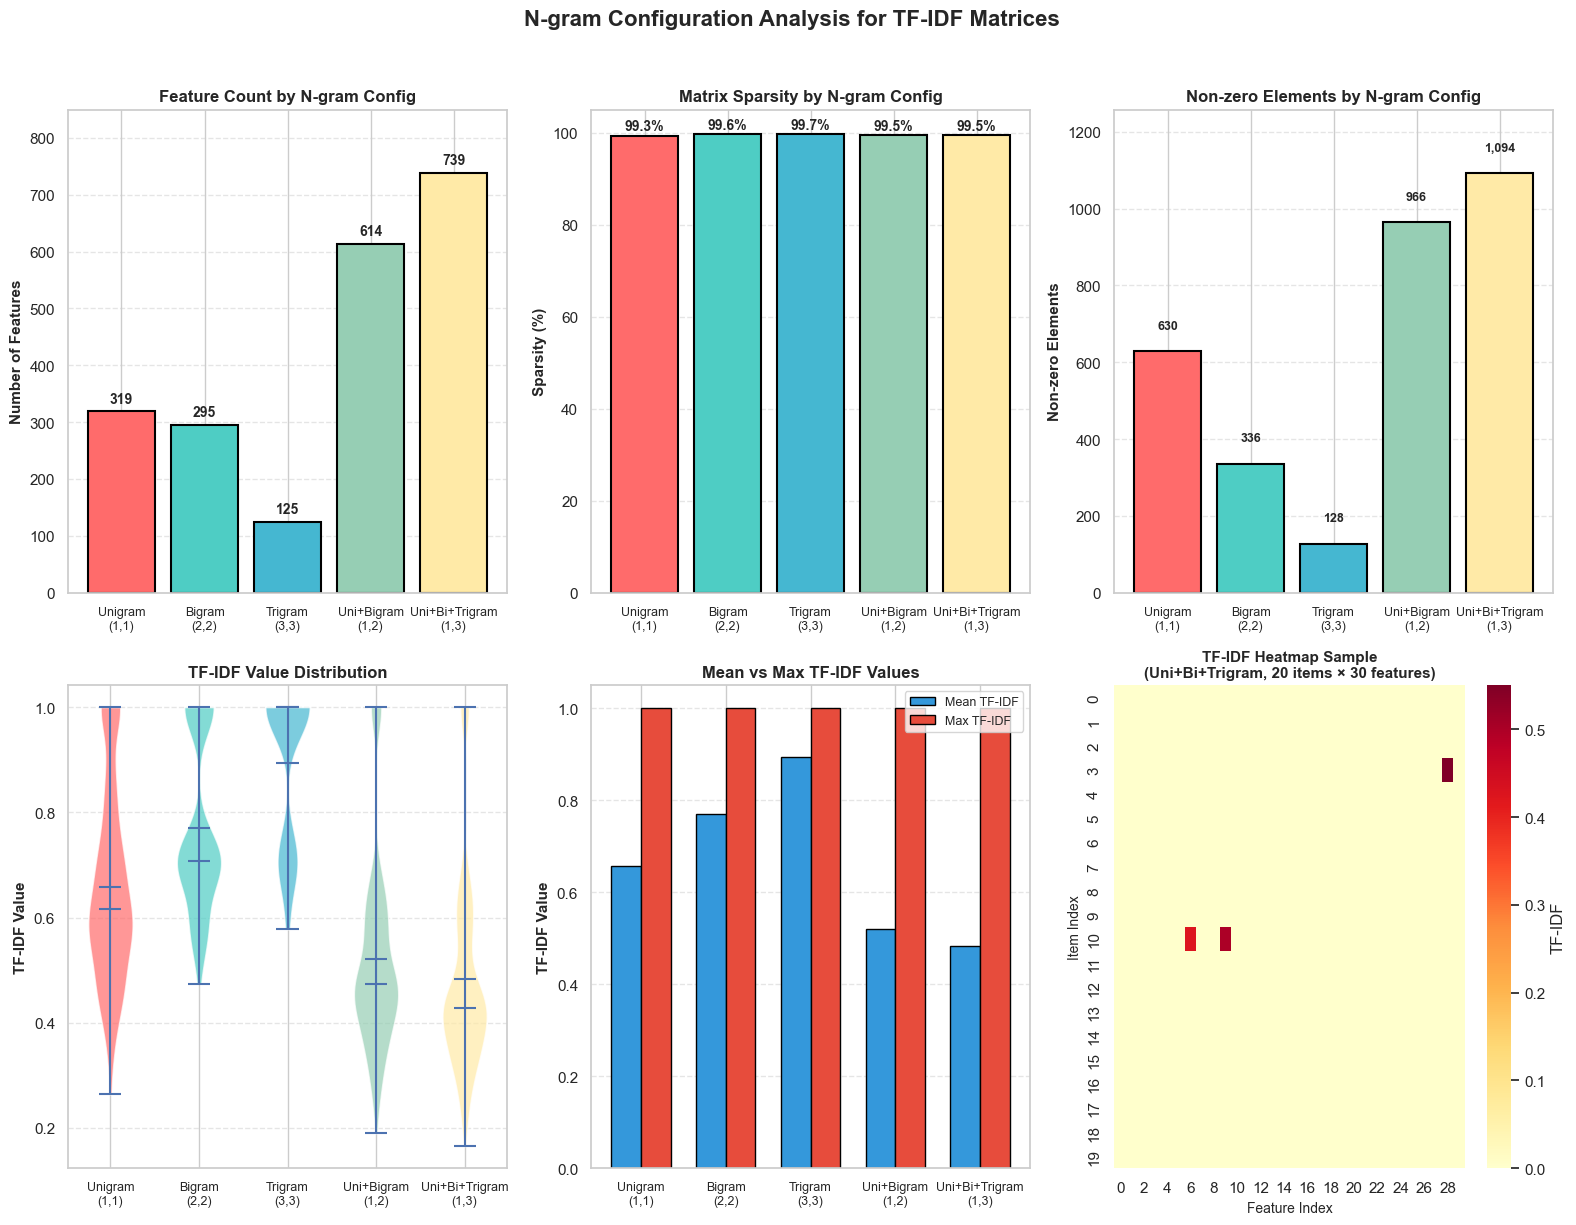


✓ N-gram analysis visualization saved: ngram_analysis.png

N-GRAM CONFIGURATION SUMMARY
               N-gram  Range  Features Sparsity  Non-zero Mean TF-IDF Max TF-IDF
       Unigram\n(1,1) (1, 1)       319   99.33%       630      0.6578     1.0000
        Bigram\n(2,2) (2, 2)       295   99.61%       336      0.7697     1.0000
       Trigram\n(3,3) (3, 3)       125   99.65%       128      0.8932     1.0000
    Uni+Bigram\n(1,2) (1, 2)       614   99.46%       966      0.5203     1.0000
Uni+Bi+Trigram\n(1,3) (1, 3)       739   99.50%      1094      0.4828     1.0000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
import numpy as np

# Define n-gram configurations to visualize
ngram_configs = {
    'Unigram\n(1,1)': (1, 1),
    'Bigram\n(2,2)': (2, 2),
    'Trigram\n(3,3)': (3, 3),
    'Uni+Bigram\n(1,2)': (1, 2),
    'Uni+Bi+Trigram\n(1,3)': (1, 3)
}

# Generate TF-IDF matrices for each configuration
matrix_stats = []
tfidf_matrices = {}

for name, ngram_range in ngram_configs.items():
    tfidf_matrix, tfidf_vectorizer = tuner.create_tfidf_matrix(ngram_range)
    
    # Calculate statistics
    if issparse(tfidf_matrix):
        dense_matrix = tfidf_matrix.toarray()
    else:
        dense_matrix = tfidf_matrix
    
    n_items, n_features = tfidf_matrix.shape
    sparsity = 1 - (np.count_nonzero(dense_matrix) / (n_items * n_features))
    mean_tfidf = dense_matrix[dense_matrix > 0].mean() if np.count_nonzero(dense_matrix) > 0 else 0
    max_tfidf = dense_matrix.max()
    
    matrix_stats.append({
        'N-gram': name,
        'Range': ngram_range,
        'Items': n_items,
        'Features': n_features,
        'Sparsity': sparsity * 100,
        'Mean TF-IDF': mean_tfidf,
        'Max TF-IDF': max_tfidf,
        'Non-zero': np.count_nonzero(dense_matrix)
    })
    tfidf_matrices[name] = dense_matrix

# Create visualization
fig = plt.figure(figsize=(16, 12))
fig.suptitle('N-gram Configuration Analysis for TF-IDF Matrices', fontsize=16, fontweight='bold', y=1.02)

# Color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Plot 1: Feature Count Comparison
ax1 = fig.add_subplot(2, 3, 1)
names = [s['N-gram'] for s in matrix_stats]
features = [s['Features'] for s in matrix_stats]
bars1 = ax1.bar(names, features, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Features', fontsize=11, fontweight='bold')
ax1.set_title('Feature Count by N-gram Config', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=0, labelsize=9)
for bar, val in zip(bars1, features):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')
ax1.set_ylim(0, max(features) * 1.15)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 2: Sparsity Comparison
ax2 = fig.add_subplot(2, 3, 2)
sparsity = [s['Sparsity'] for s in matrix_stats]
bars2 = ax2.bar(names, sparsity, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Sparsity (%)', fontsize=11, fontweight='bold')
ax2.set_title('Matrix Sparsity by N-gram Config', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=0, labelsize=9)
for bar, val in zip(bars2, sparsity):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.set_ylim(0, 105)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 3: Non-zero Elements
ax3 = fig.add_subplot(2, 3, 3)
nonzero = [s['Non-zero'] for s in matrix_stats]
bars3 = ax3.bar(names, nonzero, color=colors, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Non-zero Elements', fontsize=11, fontweight='bold')
ax3.set_title('Non-zero Elements by N-gram Config', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=0, labelsize=9)
for bar, val in zip(bars3, nonzero):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{val:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax3.set_ylim(0, max(nonzero) * 1.15)
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 4: TF-IDF Value Distribution (Violin Plot)
ax4 = fig.add_subplot(2, 3, 4)
tfidf_values = []
labels = []
for name, matrix in tfidf_matrices.items():
    nonzero_vals = matrix[matrix > 0].flatten()
    # Sample if too many values
    if len(nonzero_vals) > 5000:
        nonzero_vals = np.random.choice(nonzero_vals, 5000, replace=False)
    tfidf_values.append(nonzero_vals)
    labels.append(name.replace('\n', ' '))

parts = ax4.violinplot(tfidf_values, positions=range(len(labels)), showmeans=True, showmedians=True)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
ax4.set_xticks(range(len(labels)))
ax4.set_xticklabels([l.replace(' ', '\n') for l in labels], fontsize=9)
ax4.set_ylabel('TF-IDF Value', fontsize=11, fontweight='bold')
ax4.set_title('TF-IDF Value Distribution', fontsize=12, fontweight='bold')
ax4.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 5: Mean vs Max TF-IDF
ax5 = fig.add_subplot(2, 3, 5)
x_pos = np.arange(len(names))
width = 0.35
mean_vals = [s['Mean TF-IDF'] for s in matrix_stats]
max_vals = [s['Max TF-IDF'] for s in matrix_stats]
bars_mean = ax5.bar(x_pos - width/2, mean_vals, width, label='Mean TF-IDF', color='#3498db', edgecolor='black')
bars_max = ax5.bar(x_pos + width/2, max_vals, width, label='Max TF-IDF', color='#e74c3c', edgecolor='black')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(names, fontsize=9)
ax5.set_ylabel('TF-IDF Value', fontsize=11, fontweight='bold')
ax5.set_title('Mean vs Max TF-IDF Values', fontsize=12, fontweight='bold')
ax5.legend(loc='upper right', fontsize=9)
ax5.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 6: Sample TF-IDF Heatmap (first 20 items, top 30 features)
ax6 = fig.add_subplot(2, 3, 6)
# Use Uni+Bi+Trigram matrix for the heatmap
sample_matrix = tfidf_matrices['Uni+Bi+Trigram\n(1,3)'][:20, :30]
sns.heatmap(sample_matrix, cmap='YlOrRd', ax=ax6, cbar_kws={'label': 'TF-IDF'})
ax6.set_xlabel('Feature Index', fontsize=10)
ax6.set_ylabel('Item Index', fontsize=10)
ax6.set_title('TF-IDF Heatmap Sample\n(Uni+Bi+Trigram, 20 items × 30 features)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('ngram_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n N-gram analysis visualization saved: ngram_analysis.png")

# Print summary table
print("\n" + "="*80)
print("N-GRAM CONFIGURATION SUMMARY")
print("="*80)
summary_df = pd.DataFrame(matrix_stats)
summary_df = summary_df[['N-gram', 'Range', 'Features', 'Sparsity', 'Non-zero', 'Mean TF-IDF', 'Max TF-IDF']]
summary_df['Sparsity'] = summary_df['Sparsity'].apply(lambda x: f'{x:.2f}%')
summary_df['Mean TF-IDF'] = summary_df['Mean TF-IDF'].apply(lambda x: f'{x:.4f}')
summary_df['Max TF-IDF'] = summary_df['Max TF-IDF'].apply(lambda x: f'{x:.4f}')
print(summary_df.to_string(index=False))
print("="*80)

In [40]:


# Run comprehensive tuning across all n-gram configurations
results_df = tuner.tune_all_models(
    ngram_configs=[
        (1, 1),  # Unigram only
        (2, 2),  # Bigram only
        (3, 3),  # Trigram only
        (1, 2),  # Unigram + Bigram
        (1, 3),  # Unigram + Bigram + Trigram
    ],
    knn_neighbors=[5], #knn_neighbors does not need fine tune
    svd_components=[10, 20, 50, 100],
    k=5
)


STARTING COMPREHENSIVE HYPERPARAMETER TUNING
Training samples: 75938
Validation users: 22716
N-gram configurations: 5
Total configurations: 30
Evaluation Metric: Precision@5


--- Testing Unigram ---
TF-IDF Matrix Shape: (294, 319)
  Testing Cosine Similarity... (294, 319)
Precision: 0.0108
  Testing KNN (k=5)... Precision: 0.0127
  Testing SVD (components=10)... Precision: 0.0074
  Testing SVD (components=20)... Precision: 0.0099
  Testing SVD (components=50)... Precision: 0.0137
  Testing SVD (components=100)... Precision: 0.0154

--- Testing Bigram ---
TF-IDF Matrix Shape: (294, 295)
  Testing Cosine Similarity... (294, 295)
Precision: 0.0241
  Testing KNN (k=5)... Precision: 0.0703
  Testing SVD (components=10)... Precision: 0.0034
  Testing SVD (components=20)... Precision: 0.0080
  Testing SVD (components=50)... Precision: 0.0049
  Testing SVD (components=100)... Precision: 0.0073

--- Testing Trigram ---
TF-IDF Matrix Shape: (294, 125)
  Testing Cosine Similarity... (294, 125)


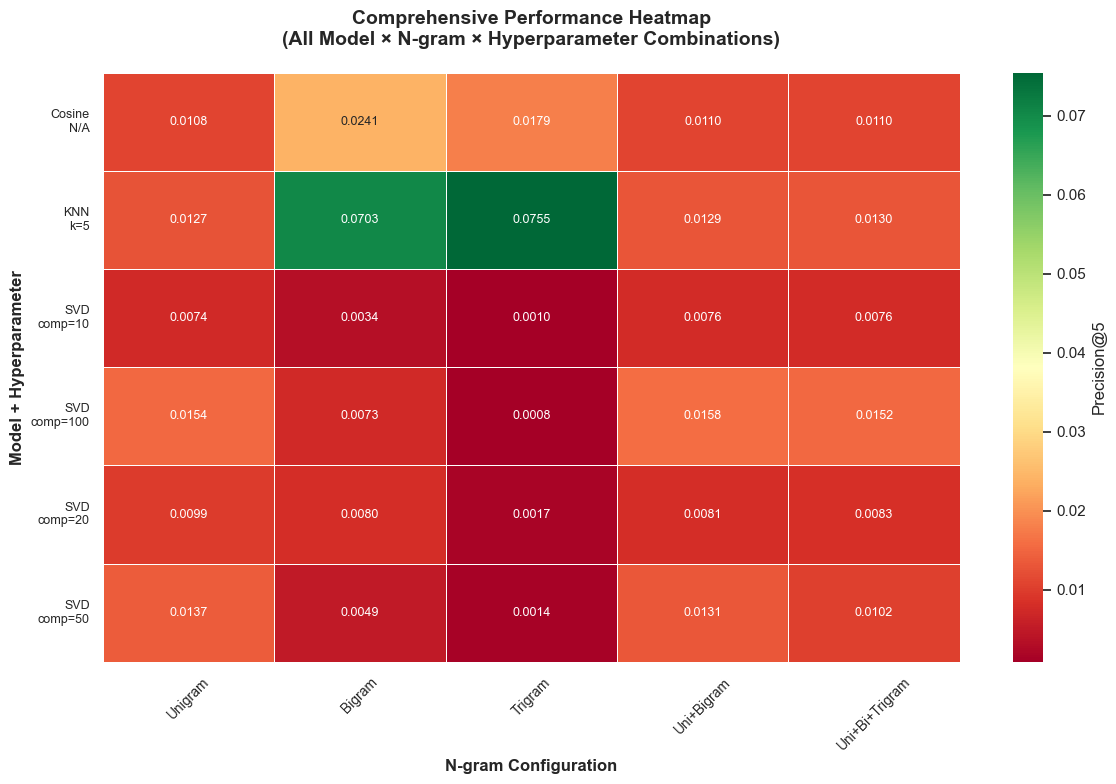

✓ Comprehensive heatmap saved: ngram_comprehensive_heatmap.png


In [41]:
# Create a combined model-param identifier for heatmap
results_df['Model_Param'] = results_df['Model'] + '\n' + results_df['Param'].astype(str)

# Pivot for heatmap
heatmap_data = results_df.pivot_table(
    index='Model_Param', 
    columns='N-gram', 
    values='Precision@5',
    aggfunc='first'
)

# Reorder columns
col_order = ['Unigram', 'Bigram', 'Trigram', 'Uni+Bigram', 'Uni+Bi+Trigram']
heatmap_data = heatmap_data[[c for c in col_order if c in heatmap_data.columns]]

# Create heatmap
fig3, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', ax=ax,
            cbar_kws={'label': 'Precision@5'}, linewidths=0.5,
            annot_kws={'fontsize': 9})

ax.set_title('Comprehensive Performance Heatmap\n(All Model × N-gram × Hyperparameter Combinations)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('N-gram Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Model + Hyperparameter', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.tick_params(axis='y', rotation=0, labelsize=9)

plt.tight_layout()
plt.savefig('ngram_comprehensive_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Comprehensive heatmap saved: ngram_comprehensive_heatmap.png")

# Clean up the added column
results_df = results_df.drop(columns=['Model_Param'])


In [42]:

print("\nBest Configuration:")
print("="*60)
content_based_model = ['Cosine', 'KNN', 'SVD']
for model_name in content_based_model:
    try:
        config = tuner.get_best_params(model_name)
        print(f"\n{model_name}:")
        for key, value in config.items():
            print(f"  {key}: {value}")
    except ValueError as e:
        print(f"\n{model_name}: No results available")
print("="*60)


Best Configuration:

Cosine:
  model: Cosine
  ngram: Bigram
  ngram_range: (2, 2)
  param: N/A
  precision: 0.024088748019017434

KNN:
  model: KNN
  ngram: Trigram
  ngram_range: (3, 3)
  param: k=5
  precision: 0.07547103363268182

SVD:
  model: SVD
  ngram: Uni+Bigram
  ngram_range: (1, 2)
  param: comp=100
  precision: 0.01576862123613312


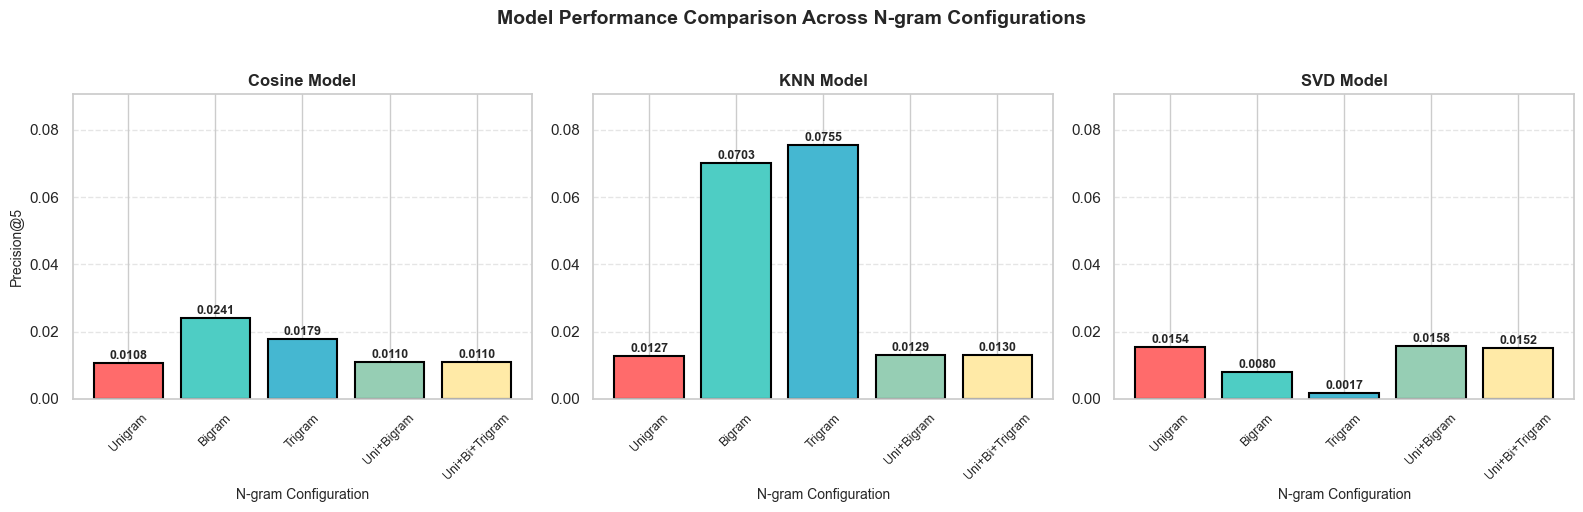

✓ Model performance visualization saved: ngram_model_performance.png

BEST N-GRAM CONFIGURATION PER MODEL
Cosine  : Bigram          → Precision@5 = 0.0241
KNN     : Trigram         → Precision@5 = 0.0755
SVD     : Uni+Bigram      → Precision@5 = 0.0158


In [43]:
# Pivot results to show performance comparison across n-grams
performance_data = results_df.copy()

# Create grouped bar chart showing performance by model and n-gram
fig2, axes = plt.subplots(1, 3, figsize=(16, 5))
fig2.suptitle('Model Performance Comparison Across N-gram Configurations', fontsize=14, fontweight='bold', y=1.02)

ngram_order = ['Unigram', 'Bigram', 'Trigram', 'Uni+Bigram', 'Uni+Bi+Trigram']
ngram_colors = {'Unigram': '#FF6B6B', 'Bigram': '#4ECDC4', 'Trigram': '#45B7D1', 
                'Uni+Bigram': '#96CEB4', 'Uni+Bi+Trigram': '#FFEAA7'}

# Plot for each model type
for idx, model_name in enumerate(['Cosine', 'KNN', 'SVD']):
    ax = axes[idx]
    model_data = performance_data[performance_data['Model'] == model_name]
    
    # Get best precision for each n-gram (best hyperparameter)
    best_per_ngram = model_data.groupby('N-gram')['Precision@5'].max().reset_index()
    
    # Sort by ngram_order
    best_per_ngram['sort_order'] = best_per_ngram['N-gram'].apply(
        lambda x: ngram_order.index(x) if x in ngram_order else 999
    )
    best_per_ngram = best_per_ngram.sort_values('sort_order')
    
    colors = [ngram_colors.get(ng, '#888888') for ng in best_per_ngram['N-gram']]
    bars = ax.bar(best_per_ngram['N-gram'], best_per_ngram['Precision@5'], 
                  color=colors, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.0003,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_title(f'{model_name} Model', fontsize=12, fontweight='bold')
    ax.set_xlabel('N-gram Configuration', fontsize=10)
    ax.set_ylabel('Precision@5' if idx == 0 else '', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylim(0, performance_data['Precision@5'].max() * 1.2)

plt.tight_layout()
plt.savefig('ngram_model_performance.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Model performance visualization saved: ngram_model_performance.png")

# Additional: Best configuration per model
print("\n" + "="*60)
print("BEST N-GRAM CONFIGURATION PER MODEL")
print("="*60)
for model in ['Cosine', 'KNN', 'SVD']:
    model_best = results_df[results_df['Model'] == model].nlargest(1, 'Precision@5').iloc[0]
    print(f"{model:8s}: {model_best['N-gram']:15s} → Precision@5 = {model_best['Precision@5']:.4f}")
print("="*60)

### Train final models

In [44]:
# ReTrain each model separately on full train data
cosine_model, _, _, _ = tuner.train_best_model("Cosine", full_train_interaction)
knn_model, _, _, _ = tuner.train_best_model("KNN", full_train_interaction)
svd_model, _, _, _ = tuner.train_best_model("SVD", full_train_interaction)

(294, 295)

Trained Cosine with best params:
  N-gram: Bigram
  Parameter: N/A

Trained KNN with best params:
  N-gram: Trigram
  Parameter: k=5

Trained SVD with best params:
  N-gram: Uni+Bigram
  Parameter: comp=100


### Model Evaluation on Test Set


In [ ]:

# Create models dictionary
models = {
    'Cosine': cosine_model,
    'KNN': knn_model,
    'SVD': svd_model
}

print("\n" + "="*80)
print("GENERATING RECOMMENDATIONS")
print("="*80)

val_users = list(ground_truth.keys())
print(f"Validation users: {len(val_users)}")
print(f"Recommendations per user: k=5\n")

# Generate recommendations for each model
recommendations = {}
for i, (model_name, model) in enumerate(models.items(), 0):
    clean_name = model_name.replace('\n', ' ')
    print(f"[{i}/{len(models)}] {clean_name}...", end=" ")
    
    recs = {}
    for user_id in val_users:
        try:
            recs[user_id] = model.recommend(user_id, k=5)
        except Exception:
            recs[user_id] = []  # Empty list if recommendation fails
    
    recommendations[model_name] = recs
    print(f" {len(recs)} users")

print(f"\n{'='*80}")
print(" All recommendations generated successfully")
print("="*80)


GENERATING RECOMMENDATIONS
Validation users: 5000
Recommendations per user: k=5

[0/3] Cosine... ✓ 5000 users
[1/3] KNN... ✓ 5000 users
[2/3] SVD... ✓ 5000 users

✓ All recommendations generated successfully



EVALUATING MODEL PERFORMANCE

Calculating metrics...

 Model  Precision@5  Recall@5  Hit_Rate@5  Catalog_Coverage  Personalization
Cosine      0.02088  0.025825      0.1022         24.829932         0.560949
   KNN      0.06364  0.115057      0.2936          4.761905         0.219384
   SVD      0.01144  0.017890      0.0548         92.176871         0.941401

USER SEGMENT ANALYSIS

Model                     Cosine       KNN       SVD
Segment                                             
High Activity (11+)     0.004255  0.017021  0.002128
Low Activity (1-5)      0.022099  0.066574  0.011765
Medium Activity (6-10)  0.014361  0.049037  0.010508

GENERATING VISUALIZATIONS


C:\Users\Legion\AppData\Local\Temp\ipykernel_25464\334695478.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


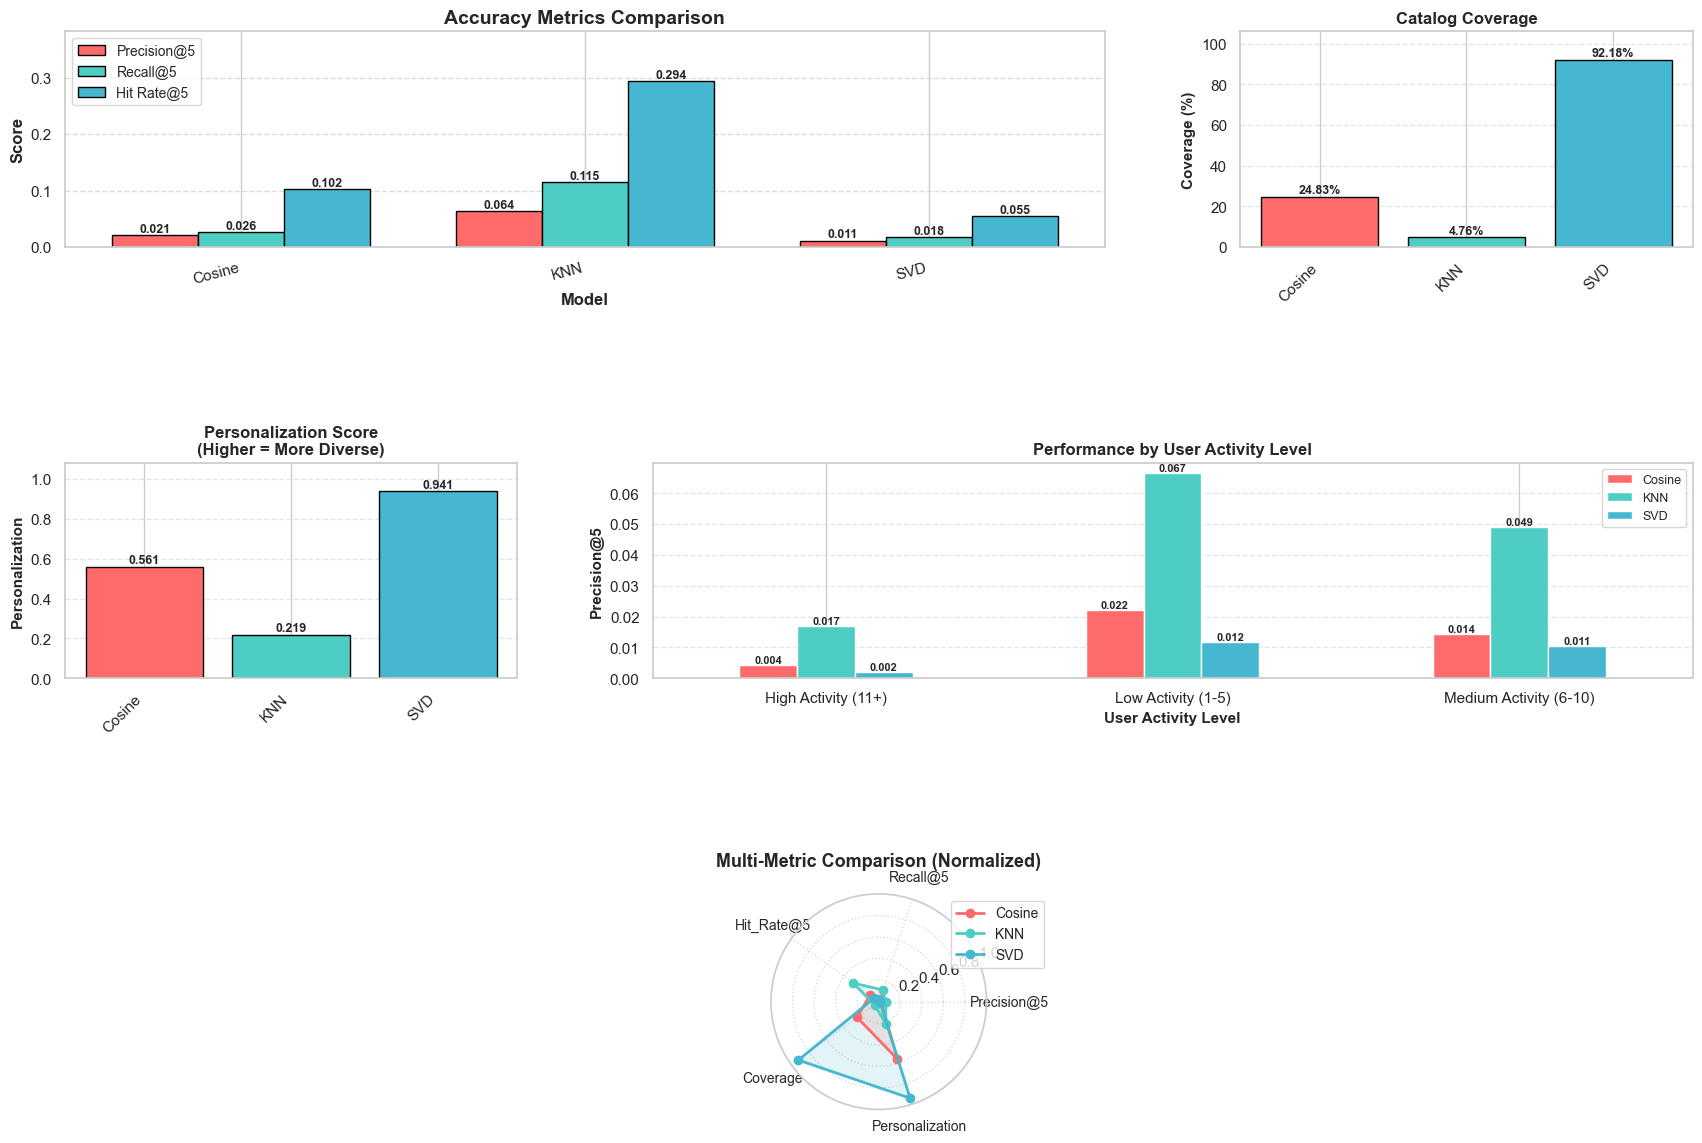


✓ Comprehensive visualization saved: model_evaluation_comparison.png


In [46]:
results_df, segment_df = evaluate_models(
    recommendations=recommendations,  
    ground_truth=ground_truth,
    train_binary=full_train_matrix,
    catalog_size=len(df_attr)  
)

---

## 5.4 Collaborative Filtering Models

### Theoretical Foundation

Collaborative Filtering (CF) operates as a domain-agnostic paradigm that derives item relatedness solely from observed latent preferences within the interaction matrix. Unlike content-based approaches, CF leverages the collective intelligence of the user base to identify high-order correlations between pages based on co-occurrence patterns.

**Model Implementations:**
| Model | Category | Mechanism | Theoretical Basis |
|-------|----------|-----------|-------------------|
| User-KNN | Memory-Based | Aggregate preferences of similar users | Users with similar histories share future preferences |
| Item-KNN | Memory-Based | Recommend items co-visited with user's history | Items frequently visited together are related |
| ALS | Model-Based | Factorise interaction matrix into latent representations | Captures latent user preferences and item characteristics  |
| KMeans | Model-Based | Cluster users and recommend cluster-popular items | Users within clusters share behavioural patterns |

In [47]:
cf_recommendations = {}

### 5.4.1 K-Nearest Neighbours (Memory-Based CF)

In [48]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


class KNNRecommender:
    def __init__(self, k_vals=[5, 10, 20, 50]):
        self.k_vals = k_vals
        self.best_k = {'user': 50, 'item': 5}
        self.tune_results = {'user': {}, 'item': {}}  # Store tuning results for visualization

        self.pivot = None
        self.sparse_user = None
        self.sparse_item = None
        self.user_knn = None
        self.item_knn = None


    def _recommend_core(self, pivot, sparse_data, knn, user_id, n_recs, mode, sim_graph=None, revisit=True):
        """
        Core recommendation logic for both user-based and item-based CF.
        
        Args:
            pivot: User-item interaction matrix (float32/float64 values, str index)
            sparse_data: Sparse matrix (user x item for user-based, item x user for item-based)
            knn: Fitted NearestNeighbors model
            user_id: Target user ID (will be converted to str)
            n_recs: Number of recommendations to return
            mode: 'user' or 'item'
            sim_graph: Pre-computed similarity graph (only for item-based mode)
        
        Returns:
            List of recommended item IDs (as strings)
        """
        # Ensure user_id is string and exists
        user_id_str = str(user_id)
        if user_id_str not in pivot.index:
            print(f"Warning: User {user_id_str} not found in training data")
            return []
        
        u_idx = pivot.index.get_loc(user_id_str)

        # ---------- USER-BASED ----------
        if mode == "user":
            # Find nearest neighbor users
            _, idx = knn.kneighbors(sparse_data[u_idx])
            neighbors = idx.flatten()[1:]  # Exclude self (first neighbor)

            # Aggregate items from neighbor users
            scores = pivot.iloc[neighbors].sum(axis=0)
            if not revisit: scores[pivot.iloc[u_idx] > 0] = -1  # Mask already seen items

            return [str(i) for i in scores.sort_values(ascending=False).head(n_recs).index]

        # ---------- ITEM-BASED ----------
        seen = np.where(pivot.iloc[u_idx] > 0)[0]
        if len(seen) == 0:
            return []
        
        # Use pre-computed similarity graph
        item_scores = sim_graph[seen].sum(axis=0).A1
        if not revisit: item_scores[seen] = -1  # Mask already seen items

        top = np.argsort(item_scores)[::-1][:n_recs]
        return [str(pivot.columns[i]) for i in top]


    # TUNE

    def tune(self, pivot, ground_truth, mode='user', params_k=None):
        """
        Find the best K value by evaluating on validation set.
        
        Args:
            pivot: Training user-item interaction matrix (float values, str index/columns)
            ground_truth: Validation set {user_id: [item_ids]}
            mode: 'user' or 'item' based collaborative filtering
            params_k: List of K values to try (defaults to self.k_vals)
        
        Returns:
            best_k: Optimal K value
        """
        # Validate input types
        if not np.issubdtype(pivot.values.dtype, np.floating):
            raise TypeError(f"Pivot matrix must have float values, got {pivot.values.dtype}")
        
        if not all(isinstance(idx, str) for idx in pivot.index[:5]):
            raise TypeError("Pivot index (user IDs) must be strings")
        
        if not all(isinstance(col, str) for col in pivot.columns[:5]):
            raise TypeError("Pivot columns (item IDs) must be strings")
        
        best_k, max_score = 0, -1
        print(f"\n--- Tuning {mode.upper()}-Based KNN ---")

        # Prepare data based on mode
        data = pivot.values if mode == 'user' else pivot.T.values
        sparse_data = csr_matrix(data)
        
        # Get all user IDs from ground truth (ensure strings)
        user_ids = [str(u) for u in ground_truth.keys()]
        params_k = self.k_vals if not params_k else params_k
        
        for k in params_k:
            print(f"  Evaluating K={k}...", end=" ", flush=True)

            # Fit KNN with k+1 neighbors (including self)
            knn = NearestNeighbors(
                n_neighbors=k+1, metric='cosine', algorithm='brute'
            ).fit(sparse_data)

            # Pre-compute similarity graph ONCE for item-based (major speedup!)
            sim_graph = None
            if mode == 'item':
                sim_graph = knn.kneighbors_graph(sparse_data, mode='connectivity')

            # Generate recommendations for all users
            recs = {
                str(u): self._recommend_core(
                    pivot, sparse_data, knn, u, 5, mode, sim_graph, revisit=False
                )
                for u in user_ids
            }

            # Calculate metrics
            metrics = calculate_metrics_at_k(recs, ground_truth, k=5)
            score = metrics["Precision@5"]
            print(f"Score: {score:.5f}")
            
            # Store result for visualization
            self.tune_results[mode][k] = score

            # Track best k
            if score > max_score:
                max_score, best_k = score, k

        self.best_k[mode] = best_k
        print(f"Best K for {mode}: {best_k} (Score: {max_score:.5f})")
        return best_k


    # FIT

    def fit(self, dataset, mode='both', k=None):
        """
        Train the KNN models with the full training dataset.
        
        Args:
            dataset: Full training user-item interaction matrix (float values, str index/columns)
            mode: 'user', 'item', or 'both' - which model(s) to train
            k: Optional fixed K value (overrides tuned values for the specified mode)
        """
        # Validate input types
        if not np.issubdtype(dataset.values.dtype, np.floating):
            raise TypeError(f"Dataset must have float values, got {dataset.values.dtype}")
        
        if not all(isinstance(idx, str) for idx in dataset.index[:5]):
            raise TypeError("Dataset index (user IDs) must be strings")
        
        if not all(isinstance(col, str) for col in dataset.columns[:5]):
            raise TypeError("Dataset columns (item IDs) must be strings")
        
        self.pivot = dataset.copy()
        self.sparse_user = csr_matrix(self.pivot.values)
        self.sparse_item = csr_matrix(self.pivot.T.values)

        trained_models = []

        # Train user-based model
        if mode in ['user', 'both']:
            k_user = k if k is not None else self.best_k['user']
            self.user_knn = NearestNeighbors(
                n_neighbors=k_user+1, metric="cosine", algorithm="brute"
            ).fit(self.sparse_user)
            trained_models.append(f"user-k={k_user}")

        # Train item-based model
        if mode in ['item', 'both']:
            k_item = k if k is not None else self.best_k['item']
            self.item_knn = NearestNeighbors(
                n_neighbors=k_item+1, metric="cosine", algorithm="brute"
            ).fit(self.sparse_item)
            trained_models.append(f"item-k={k_item}")

        print(f"Models trained: {', '.join(trained_models)}")


    # GET RECOMMEND

    def get_k_recommend(self, user_id, k=5, mode="user"):
        """
        Generate top-K recommendations for a user.
        
        Args:
            user_id: Target user ID (will be converted to str)
            k: Number of recommendations to return
            mode: 'user' or 'item' based collaborative filtering
        
        Returns:
            List of recommended item IDs (as strings)
        """
        if self.pivot is None:
            raise ValueError("Call fit() before get_k_recommend().")

        if mode == "user":
            return self._recommend_core(
                self.pivot, self.sparse_user, self.user_knn, user_id, k, "user"
            )

        # Pre-compute similarity graph for item-based
        sim_graph = self.item_knn.kneighbors_graph(self.sparse_item, mode='connectivity')
        return self._recommend_core(
            self.pivot, self.sparse_item, self.item_knn, user_id, k, "item", sim_graph
        )


    # BATCH RECOMMEND 

    def get_batch_recommend(self, user_ids, k=5, mode="user"):
        """
        Generate recommendations for multiple users efficiently.
        
        Args:
            user_ids: List of user IDs (will be converted to str)
            k: Number of recommendations per user
            mode: 'user' or 'item' based collaborative filtering
        
        Returns:
            Dictionary {user_id: [recommended_item_ids]}
        """
        if self.pivot is None:
            raise ValueError("Call fit() before get_batch_recommend().")

        # Pre-compute similarity graph once for all users (item-based only)
        sim_graph = None
        if mode == "item":
            sim_graph = self.item_knn.kneighbors_graph(self.sparse_item, mode='connectivity')

        knn = self.user_knn if mode == "user" else self.item_knn
        sparse_data = self.sparse_user if mode == "user" else self.sparse_item

        return {
            str(u): self._recommend_core(
                self.pivot, sparse_data, knn, u, k, mode, sim_graph
            )
            for u in user_ids
        }

### 5.4.2 Alternating Least Squares (Model-Based CF)

In [49]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import ParameterGrid
import implicit


class ALSRecommender:
    def __init__(self, factors_list=[32, 64, 128], reg_list=[0.01, 0.1, 1.0]):
        self.factors_list = factors_list
        self.reg_list = reg_list
        
        self.best_params = {"factors": 64, "regularization": 0.1}
        self.tune_results = {}  # Store tuning results for visualization {(factors, reg): score}
        self.final_model = None
        
        # Stored after fit()
        self.pivot = None
        self.sparse = None
        self.user_list = None
        self.item_list = None


    # TUNE

    def tune(self, train_pivot, val_ground_truth, params_grid=None):
        print(f"\n--- Tuning ALS ---")

        train_pivot.index = train_pivot.index.astype(str)
        train_pivot.columns = train_pivot.columns.astype(str)

        self.user_list = train_pivot.index.tolist()
        self.item_list = np.array(train_pivot.columns.tolist())

        train_sparse = csr_matrix(train_pivot.values.astype("float32"))
        tuning_results = []

        # Build parameter grid (defaults first)
        grid = {
            "factors": self.factors_list,
            "regularization": self.reg_list
        }

        # Override with custom grid if provided
        if params_grid:
            if "factors" in params_grid:
                grid["factors"] = params_grid["factors"]
            if "regularization" in params_grid:
                grid["regularization"] = params_grid["regularization"]

        # Iterate combinations with ParameterGrid
        for params in ParameterGrid(grid):
            f = params["factors"]
            r = params["regularization"]

            model = implicit.als.AlternatingLeastSquares(
                factors=f,
                regularization=r,
                iterations=20,
                random_state=42,
                use_gpu=False
            )

            model.fit(train_sparse, show_progress=False)

            recs_dict = {}
            for idx, u_id in enumerate(self.user_list):
                try:
                    ids, _ = model.recommend(
                        idx,
                        train_sparse[idx],
                        N=5,
                        filter_already_liked_items=True
                    )
                    recs_dict[u_id] = self.item_list[ids].tolist()
                except:
                    recs_dict[u_id] = []

            metrics = calculate_metrics_at_k(recs_dict, val_ground_truth, k=5)
            score = metrics["Precision@5"]

            print(f"Factors: {f:3} | Reg: {r:6} | Score: {score:.5f}")
            self.tune_results[(f, r)] = score  # Store for visualization
            tuning_results.append({"params": params, "score": score})

        # Select best params
        self.best_params = max(tuning_results, key=lambda x: x["score"])["params"]
        return self.best_params


    # FIT

    def fit(self, dataset, factors=None, reg=None):
        """
        Train final ALS model on full dataset.
        """
        print("\n--- Training Final ALS Model ---")

        self.pivot = dataset.copy()
        self.pivot.index = self.pivot.index.astype(str)
        self.pivot.columns = self.pivot.columns.astype(str)

        self.user_list = self.pivot.index.tolist()
        self.item_list = np.array(self.pivot.columns.tolist())

        self.sparse = csr_matrix(self.pivot.values.astype("float32"))

        factors = factors if factors is not None else self.best_params["factors"]
        reg = reg if reg is not None else self.best_params["regularization"]

        self.final_model = implicit.als.AlternatingLeastSquares(
            factors=factors,
            regularization=reg,
            iterations=20,
            random_state=42,
            use_gpu=False
        )

        self.final_model.fit(self.sparse, show_progress=False)
        print(f"Model trained: factors={factors}, reg={reg}")

    # SINGLE USER RECS

    def get_k_recommend(self, user_id, k=5):
        if self.final_model is None:
            raise ValueError("Call fit() before get_k_recommend().")

        u_idx = self.pivot.index.get_loc(str(user_id))

        ids, _ = self.final_model.recommend(
            u_idx,
            self.sparse[u_idx],
            N=k,
            filter_already_liked_items=False
        )

        return self.item_list[ids].tolist()


    # BATCH RECS

    def get_batch_recommend(self, user_ids, k=5):
        if self.final_model is None:
            raise ValueError("Call fit() before get_batch_recommend().")

        result = {}

        for u in user_ids:
            try:
                result[str(u)] = self.get_k_recommend(u, k)
            except:
                result[str(u)] = []

        return result

### 5.4.3 KMeans Clustering (Model-Based CF)

In [50]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid


class KMeansRecommender:
    def __init__(self):
        self.best_params = {"n_clusters": 10}
        self.tune_results = {}  # Store tuning results for visualization {n_clusters: score}
        self.final_model = None
        
        # Stored after fit()
        self.features = None
        self.interactions = None
        self.user_clusters = None
        self.cluster_top_items = {}  # Pre-computed recommendations per cluster


    # TUNE

    def tune(self, train_features, train_interactions, val_ground_truth, n_clusters_list=None):
        """
        train_features: DataFrame for clustering (e.g., X_train_tfidf)
        train_interactions: DataFrame for recommendations (e.g., train_binary)
        n_clusters_list: list of n_clusters to try, e.g., [5, 10, 20]
        """
        print(f"\n--- Tuning KMeans ---")

        if n_clusters_list is None:
            n_clusters_list = [5, 10, 20]

        train_features = train_features.copy()
        train_interactions = train_interactions.copy()
        
        train_features.index = train_features.index.astype(str)
        train_interactions.index = train_interactions.index.astype(str)
        train_interactions.columns = train_interactions.columns.astype(str)

        train_data = train_features.values.astype("float32")
        tuning_results = []
        
        # Get validation users only
        val_users = list(val_ground_truth.keys())
        print(f"Training on {len(train_features)} users, validating on {len(val_users)} users")

        for n_clust in n_clusters_list:
            print(f"Testing n_clusters={n_clust}...", end=" ")
            
            # Fit KMeans
            model = KMeans(n_clusters=n_clust, random_state=42, n_init=10)
            model.fit(train_data)
            
            # Assign clusters
            train_features['cluster'] = model.labels_
            
            # Pre-compute cluster top items (OPTIMIZATION)
            cluster_top_items = {}
            for cluster_id in range(n_clust):
                cluster_users = train_features[train_features['cluster'] == cluster_id].index
                top_items = train_interactions.loc[cluster_users].sum().sort_values(ascending=False).head(5).index.tolist()
                cluster_top_items[cluster_id] = top_items
            
            # Generate recommendations ONLY for validation users (SPEED FIX)
            recs_dict = {}
            for user_id in val_users:
                user_str = str(user_id)
                if user_str in train_features.index:
                    cluster = train_features.loc[user_str, 'cluster']
                    recs_dict[user_str] = cluster_top_items[cluster]
                else:
                    recs_dict[user_str] = []

            # Evaluate
            metrics = calculate_metrics_at_k(recs_dict, val_ground_truth, k=5)
            score = metrics["Precision@5"]

            print(f"Score: {score:.5f}")
            self.tune_results[n_clust] = score  # Store for visualization
            tuning_results.append({"n_clusters": n_clust, "score": score})
            
            # Clean up
            train_features.drop('cluster', axis=1, inplace=True)

        # Select best params
        best = max(tuning_results, key=lambda x: x["score"])
        self.best_params = {"n_clusters": best["n_clusters"]}
        print(f"\nBest params: {self.best_params}")
        return self.best_params

 
    # FIT

    def fit(self, features, interactions, n_clusters=None):
        """
        Train final KMeans model.
        
        features: DataFrame for clustering (e.g., X_train_tfidf)
        interactions: DataFrame for recommendations (e.g., train_binary)
        n_clusters: number of clusters (uses best_params if None)
        """
        print("\n--- Training Final KMeans Model ---")

        self.features = features.copy()
        self.interactions = interactions.copy()
        
        self.features.index = self.features.index.astype(str)
        self.interactions.index = self.interactions.index.astype(str)
        self.interactions.columns = self.interactions.columns.astype(str)

        train_data = self.features.values.astype("float32")
        n_clusters = n_clusters if n_clusters is not None else self.best_params["n_clusters"]

        # Fit KMeans
        self.final_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.final_model.fit(train_data)
        
        # Store cluster assignments
        self.features['cluster'] = self.final_model.labels_
        self.user_clusters = self.final_model.labels_
        
        # Pre-compute top items for each cluster (SPEED OPTIMIZATION)
        print("Pre-computing cluster recommendations...")
        for cluster_id in range(n_clusters):
            cluster_users = self.features[self.features['cluster'] == cluster_id].index
            top_items = self.interactions.loc[cluster_users].sum().sort_values(ascending=False).head(20).index.tolist()
            self.cluster_top_items[cluster_id] = top_items
        
        print(f"Model trained: n_clusters={n_clusters}")
        print(f"Cluster distribution: {np.bincount(self.user_clusters)}")


    # SINGLE USER RECS

    def get_k_recommend(self, user_id, k=5):
        """
        Recommend most popular items in user's cluster.
        Fast lookup using pre-computed cluster recommendations.
        """
        if self.final_model is None:
            raise ValueError("Call fit() before get_k_recommend().")

        user_str = str(user_id)
        
        if user_str not in self.features.index:
            return []
        
        cluster = self.features.loc[user_str, 'cluster']
        return self.cluster_top_items[cluster][:k]


    # BATCH RECS
 
    def get_batch_recommend(self, user_ids, k=5):
        """
        Fast batch recommendations using pre-computed cluster top items.
        """
        if self.final_model is None:
            raise ValueError("Call fit() before get_batch_recommend().")

        result = {}
        for u in user_ids:
            user_str = str(u)
            if user_str in self.features.index:
                cluster = self.features.loc[user_str, 'cluster']
                result[user_str] = self.cluster_top_items[cluster][:k]
            else:
                result[user_str] = []

        return result


    # ADDITIONAL UTILITY

    def get_user_cluster(self, user_id):
        """Get the cluster ID for a specific user."""
        if self.final_model is None:
            raise ValueError("Call fit() before get_user_cluster().")
        
        user_str = str(user_id)
        if user_str not in self.features.index:
            return None
        
        return int(self.features.loc[user_str, 'cluster'])

    def get_cluster_users(self, cluster_id):
        """Get all users in a specific cluster."""
        if self.final_model is None:
            raise ValueError("Call fit() before get_cluster_users().")
        
        return self.features[self.features['cluster'] == cluster_id].index.tolist()

### 5.4.4 KNN Hyperparameter Optimisation
| Type | Feature Space | Hyperparameter Range | Rationale |
|------|---------------|---------------------|-----------|
| User-Based | Pages as features defining users | k in [20, 50, 100, 150, 200] | Broader range to stabilise social neighbourhood against high individual variance |
| Item-Based | Users as features defining pages | k in [5, 10, 20, 40] | Narrower range to maintain precision and avoid dilution by weak correlations |

In [51]:
# Initialize And Fine-tune KNN
knn_engine = KNNRecommender()

knn_engine.tune(split_train_matrix, split_val, mode='user', params_k=[20,50,100,150,200])
knn_engine.tune(split_train_matrix, split_val, mode='item', params_k=[5,10,20,40])


--- Tuning USER-Based KNN ---
  Evaluating K=20... Score: 0.03258
  Evaluating K=50... Score: 0.04475
  Evaluating K=100... Score: 0.05284
  Evaluating K=150... Score: 0.06094
  Evaluating K=200... Score: 0.06814
Best K for user: 200 (Score: 0.06814)

--- Tuning ITEM-Based KNN ---
  Evaluating K=5... Score: 0.08326
  Evaluating K=10... Score: 0.06260
  Evaluating K=20... Score: 0.05961
  Evaluating K=40... Score: 0.04691
Best K for item: 5 (Score: 0.08326)


5

C:\Users\Legion\AppData\Local\Temp\ipykernel_25464\2600636052.py:51: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Legion\AppData\Local\Temp\ipykernel_25464\2600636052.py:52: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) Arial.
  plt.savefig('knn_user_based_analysis.png', dpi=150, bbox_inches='tight')
e:\Apps\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


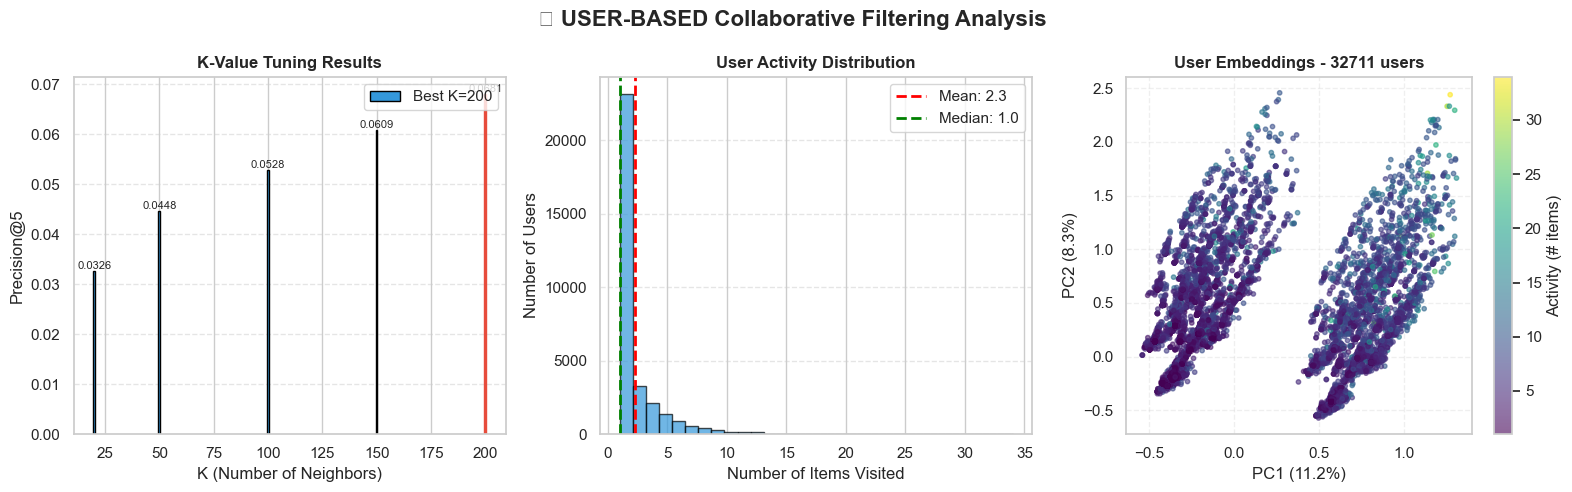

 User-Based CF: Best K = 200


In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('👤 USER-BASED Collaborative Filtering Analysis', fontsize=16, fontweight='bold')

# Plot 1: K-Value Tuning Results
ax1 = axes[0]
user_results = knn_engine.tune_results.get('user', {})
if user_results:
    k_vals = list(user_results.keys())
    scores = list(user_results.values())
    bars = ax1.bar(k_vals, scores, color='#3498db', edgecolor='black')
    ax1.set_xlabel('K (Number of Neighbors)')
    ax1.set_ylabel('Precision@5')
    ax1.set_title('K-Value Tuning Results', fontweight='bold')
    best_k = knn_engine.best_k['user']
    best_idx = k_vals.index(best_k)
    bars[best_idx].set_color('#e74c3c')
    for bar, s in zip(bars, scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{s:.4f}', ha='center', va='bottom', fontsize=8)
    ax1.legend([f'Best K={best_k}'], loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 2: User Activity Distribution
ax2 = axes[1]
user_activity = split_train_matrix.sum(axis=1).values
ax2.hist(user_activity, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax2.axvline(x=np.mean(user_activity), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(user_activity):.1f}')
ax2.axvline(x=np.median(user_activity), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(user_activity):.1f}')
ax2.set_xlabel('Number of Items Visited')
ax2.set_ylabel('Number of Users')
ax2.set_title('User Activity Distribution', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 3: User Embeddings (PCA)
ax3 = axes[2]
all_user_data = split_train_matrix.values
pca = PCA(n_components=2, random_state=42)
user_2d = pca.fit_transform(all_user_data)
activity = all_user_data.sum(axis=1)
sc = ax3.scatter(user_2d[:, 0], user_2d[:, 1], c=activity, cmap='viridis', alpha=0.6, s=10)
plt.colorbar(sc, ax=ax3, label='Activity (# items)')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax3.set_title(f'User Embeddings - {len(all_user_data)} users', fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('knn_user_based_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f" User-Based CF: Best K = {knn_engine.best_k['user']}")

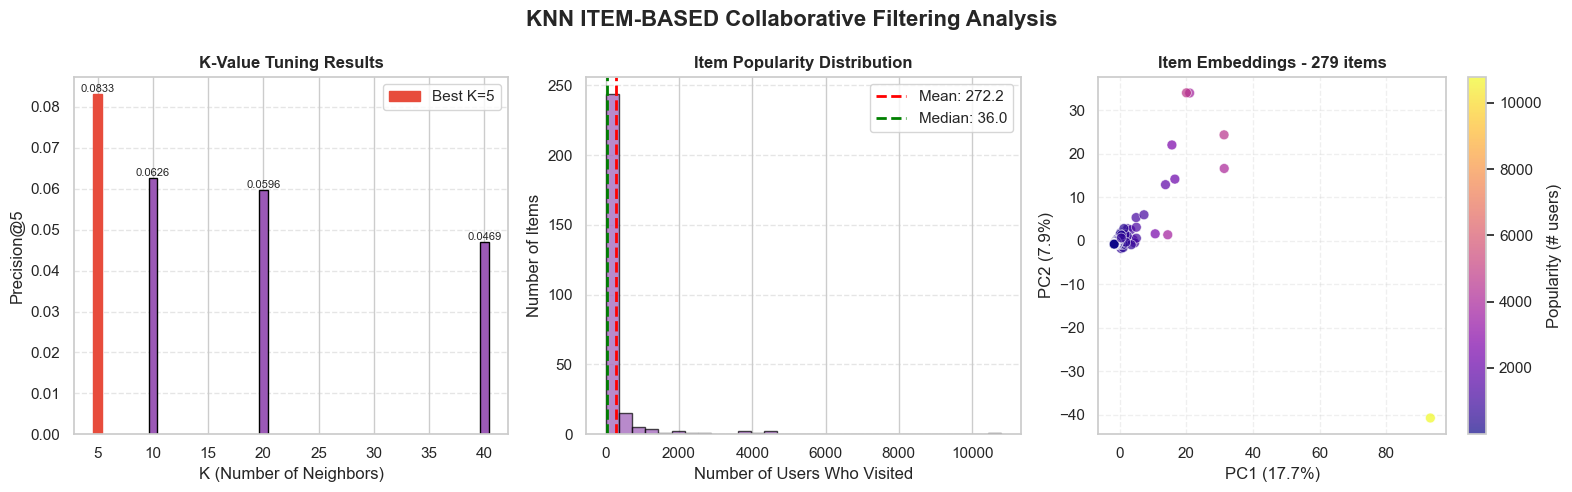

 Item-Based CF: Best K = 5


In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('KNN ITEM-BASED Collaborative Filtering Analysis', fontsize=16, fontweight='bold')

# Plot 1: K-Value Tuning Results
ax1 = axes[0]
item_results = knn_engine.tune_results.get('item', {})
if item_results:
    k_vals = list(item_results.keys())
    scores = list(item_results.values())
    bars = ax1.bar(k_vals, scores, color='#9b59b6', edgecolor='black')
    ax1.set_xlabel('K (Number of Neighbors)')
    ax1.set_ylabel('Precision@5')
    ax1.set_title('K-Value Tuning Results', fontweight='bold')
    best_k = knn_engine.best_k['item']
    best_idx = k_vals.index(best_k)
    bars[best_idx].set_color('#e74c3c')
    for bar, s in zip(bars, scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{s:.4f}', ha='center', va='bottom', fontsize=8)
    ax1.legend([f'Best K={best_k}'], loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Transpose matrix: rows = items, columns = users
item_matrix = split_train_matrix.T

# Plot 2: Item Popularity Distribution
ax2 = axes[1]
item_popularity = item_matrix.sum(axis=1).values
ax2.hist(item_popularity, bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
ax2.axvline(x=np.mean(item_popularity), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(item_popularity):.1f}')
ax2.axvline(x=np.median(item_popularity), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(item_popularity):.1f}')
ax2.set_xlabel('Number of Users Who Visited')
ax2.set_ylabel('Number of Items')
ax2.set_title('Item Popularity Distribution', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 3: Item Embeddings (PCA)
ax3 = axes[2]
all_items = item_matrix.values
pca = PCA(n_components=2, random_state=42)
item_2d = pca.fit_transform(all_items)
popularity = all_items.sum(axis=1)
sc = ax3.scatter(item_2d[:, 0], item_2d[:, 1], c=popularity, cmap='plasma', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
plt.colorbar(sc, ax=ax3, label='Popularity (# users)')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax3.set_title(f'Item Embeddings - {len(all_items)} items', fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('knn_item_based_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f" Item-Based CF: Best K = {knn_engine.best_k['item']}")

###  Train Final KNN Models

Training with optimal K values from tuning:

In [54]:


best_k_parameter_user_based = knn_engine.best_k['user']
best_k_parameter_item_based = knn_engine.best_k['item']
knn_engine.fit(full_train_matrix,mode="user", k =  best_k_parameter_user_based)
knn_engine.fit(full_train_matrix,mode="item", k =  best_k_parameter_item_based)
user_based_recommendations = knn_engine.get_batch_recommend(ground_truth.keys(), k = 5 , mode="user")
item_based_recommendations = knn_engine.get_batch_recommend(ground_truth.keys(), k = 5 , mode="item")

cf_recommendations["User-based"] = user_based_recommendations
cf_recommendations["Item-based"] = item_based_recommendations


Models trained: user-k=200
Models trained: item-k=5


### 5.4.5 ALS Hyperparameter Optimisation
**Hyperparameter Configuration:**

| Parameter | Search Range | Rationale |
|-----------|--------------|-----------|
| factors | [32, 64, 128] | Lower values (32) provide generalised views; higher values (128) capture granular relationships |
| regularisation | [0.001, 0.01, 0.05, 0.1, 1] | Higher regularisation prevents overfitting in sparse data, ensuring useful latent factors for users with few visits |

In [55]:
als_engine = ALSRecommender()
als_params = {
    "factors": [32, 64, 128],
    "regularization": [0.001, 0.01, 0.05, 0.1, 1],
}
als_engine.tune(split_train_matrix, split_val, params_grid=als_params)
print("ALS BEST PARAMS: " ,als_engine.best_params)


--- Tuning ALS ---


e:\Apps\Python\Python311\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 20 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Factors:  32 | Reg:  0.001 | Score: 0.01999
Factors:  32 | Reg:   0.01 | Score: 0.02097
Factors:  32 | Reg:   0.05 | Score: 0.02116
Factors:  32 | Reg:    0.1 | Score: 0.02123
Factors:  32 | Reg:      1 | Score: 0.02160
Factors:  64 | Reg:  0.001 | Score: 0.01032
Factors:  64 | Reg:   0.01 | Score: 0.01032
Factors:  64 | Reg:   0.05 | Score: 0.01064
Factors:  64 | Reg:    0.1 | Score: 0.01068
Factors:  64 | Reg:      1 | Score: 0.01234
Factors: 128 | Reg:  0.001 | Score: 0.00578
Factors: 128 | Reg:   0.01 | Score: 0.00581
Factors: 128 | Reg:   0.05 | Score: 0.00254
Factors: 128 | Reg:    0.1 | Score: 0.00233
Factors: 128 | Reg:      1 | Score: 0.05319
ALS BEST PARAMS:  {'factors': 128, 'regularization': 1}


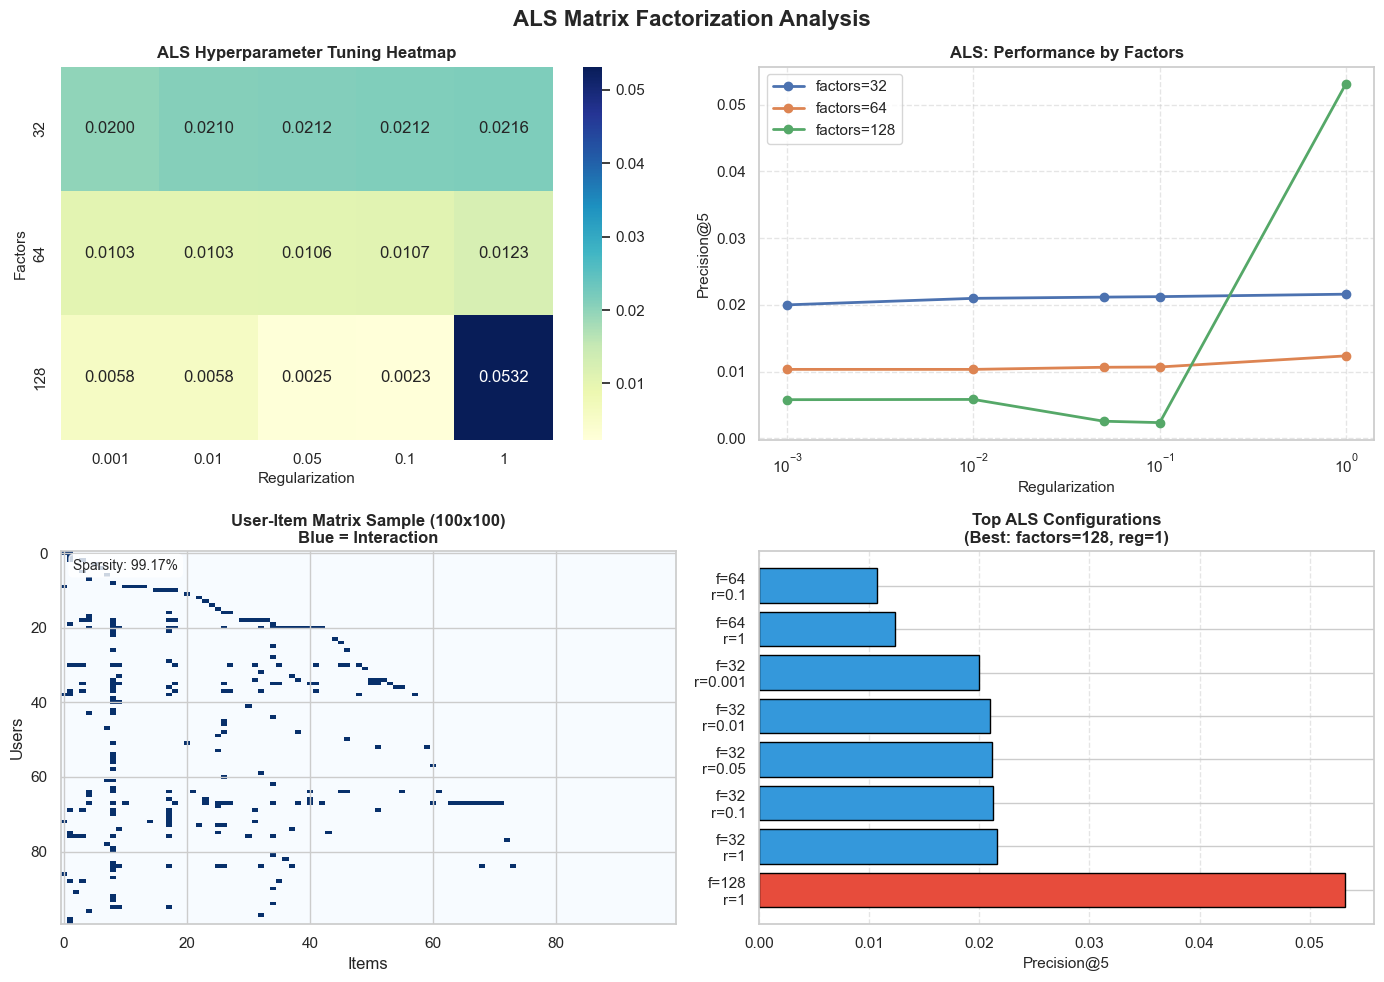

ALS Best: factors=128, regularization=1, Precision@5=0.0532


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ALS Matrix Factorization Analysis', fontsize=16, fontweight='bold')

# Plot 1: Factors vs Regularization Heatmap
ax1 = axes[0, 0]
# Create heatmap data from tuning results
factors_list = als_params['factors']
reg_list = als_params['regularization']
heatmap_data = np.zeros((len(factors_list), len(reg_list)))

for i, f in enumerate(factors_list):
    for j, r in enumerate(reg_list):
        key = (f, r)
        if key in als_engine.tune_results:
            heatmap_data[i, j] = als_engine.tune_results[key]

sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlGnBu', ax=ax1,
            xticklabels=[f'{r}' for r in reg_list],
            yticklabels=[f'{f}' for f in factors_list])
ax1.set_xlabel('Regularization', fontsize=11)
ax1.set_ylabel('Factors', fontsize=11)
ax1.set_title('ALS Hyperparameter Tuning Heatmap', fontweight='bold')

# Plot 2: Performance by Factors
ax2 = axes[0, 1]
for f in factors_list:
    scores = [als_engine.tune_results.get((f, r), 0) for r in reg_list]
    ax2.plot(reg_list, scores, marker='o', label=f'factors={f}', linewidth=2)
ax2.set_xlabel('Regularization', fontsize=11)
ax2.set_ylabel('Precision@5', fontsize=11)
ax2.set_title('ALS: Performance by Factors', fontweight='bold')
ax2.legend(loc='best')
ax2.set_xscale('log')
ax2.grid(True, linestyle='--', alpha=0.5)

# Plot 3: User-Item Matrix Sparsity Visualization
ax3 = axes[1, 0]
# Show sparse structure of the matrix
sample_matrix = split_train_matrix.iloc[:100, :100].values
ax3.imshow(sample_matrix, cmap='Blues', aspect='auto', interpolation='nearest')
ax3.set_title('User-Item Matrix Sample (100x100)\nBlue = Interaction', fontweight='bold')
ax3.set_xlabel('Items')
ax3.set_ylabel('Users')

# Add sparsity info
total_cells = split_train_matrix.shape[0] * split_train_matrix.shape[1]
nonzero = (split_train_matrix.values > 0).sum()
sparsity = (1 - nonzero/total_cells) * 100
ax3.text(0.02, 0.98, f'Sparsity: {sparsity:.2f}%', transform=ax3.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 4: Best parameters highlight
ax4 = axes[1, 1]
best_f = als_engine.best_params['factors']
best_r = als_engine.best_params['regularization']
best_score = als_engine.tune_results.get((best_f, best_r), 0)

# Bar chart of all configs sorted by score
configs = []
scores = []
for f in factors_list:
    for r in reg_list:
        configs.append(f'f={f}\nr={r}')
        scores.append(als_engine.tune_results.get((f, r), 0))

sorted_indices = np.argsort(scores)[::-1]
top_n = min(8, len(configs))
colors = ['#e74c3c' if configs[i] == f'f={best_f}\nr={best_r}' else '#3498db' for i in sorted_indices[:top_n]]

bars = ax4.barh([configs[i] for i in sorted_indices[:top_n]], 
                [scores[i] for i in sorted_indices[:top_n]], color=colors, edgecolor='black')
ax4.set_xlabel('Precision@5', fontsize=11)
ax4.set_title(f'Top ALS Configurations\n(Best: factors={best_f}, reg={best_r})', fontweight='bold')
ax4.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('als_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"ALS Best: factors={best_f}, regularization={best_r}, Precision@5={best_score:.4f}")

###  Train Final ALS Model

In [57]:
als_engine.fit(full_train_matrix, als_engine.best_params['factors'],als_engine.best_params['regularization'] )
als_recommendations = als_engine.get_batch_recommend(ground_truth.keys(), k = 5)

cf_recommendations["ALS"] = als_recommendations



--- Training Final ALS Model ---
Model trained: factors=128, reg=1


### 5.4.6 KMeans Hyperparameter Optimisation
**Hyperparameter Configuration:**

| Parameter | Search Range | Rationale |
|-----------|--------------|-----------|
| n_clusters | [5, 10, 20, 40, 60] | Small values (5-10) identify broad user personas; larger values (40-60) allow for niche groups. Tuning identifies the "elbow point" where intra-cluster variance is minimised |

In [58]:
kmeans_engine = KMeansRecommender()

# Tune (only n_clusters parameter)
best_params = kmeans_engine.tune(
    split_train_matrix, 
    split_train_matrix,
    split_val,
    n_clusters_list=[5, 10, 20,40,60]
)



--- Tuning KMeans ---
Training on 32711 users, validating on 22716 users
Testing n_clusters=5... Score: 0.08674
Testing n_clusters=10... Score: 0.04876
Testing n_clusters=20... Score: 0.05098
Testing n_clusters=40... Score: 0.04913
Testing n_clusters=60... Score: 0.04157

Best params: {'n_clusters': 5}


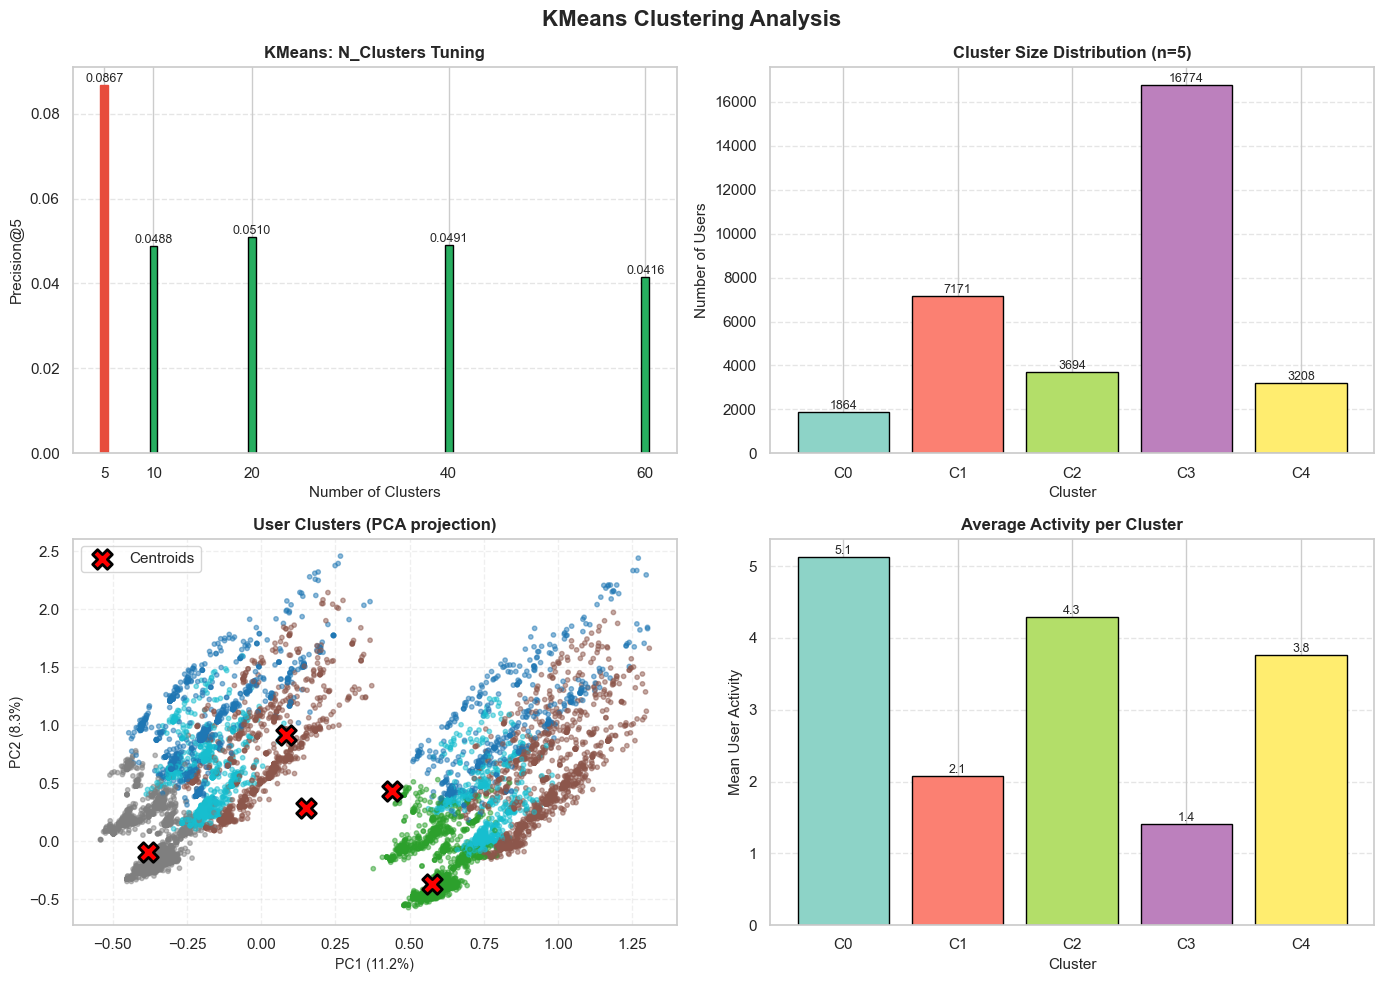

KMeans Best: n_clusters=5
Cluster sizes: {np.int32(0): np.int64(1864), np.int32(1): np.int64(7171), np.int32(2): np.int64(3694), np.int32(3): np.int64(16774), np.int32(4): np.int64(3208)}


In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('KMeans Clustering Analysis', fontsize=16, fontweight='bold')

# Plot 1: N_Clusters Tuning Results
ax1 = axes[0, 0]
n_clusters_tested = [5, 10, 20, 40, 60]
scores = []
for n in n_clusters_tested:
    if hasattr(kmeans_engine, 'tune_results') and n in kmeans_engine.tune_results:
        scores.append(kmeans_engine.tune_results[n])
    else:
        scores.append(0)

bars = ax1.bar(n_clusters_tested, scores, color='#27ae60', edgecolor='black')
ax1.set_xlabel('Number of Clusters', fontsize=11)
ax1.set_ylabel('Precision@5', fontsize=11)
ax1.set_title('KMeans: N_Clusters Tuning', fontweight='bold')
ax1.set_xticks(n_clusters_tested)

# Highlight best
if scores:
    best_idx = np.argmax(scores)
    bars[best_idx].set_color('#e74c3c')
    for bar, s in zip(bars, scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{s:.4f}', ha='center', va='bottom', fontsize=9)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 2: Cluster Size Distribution
ax2 = axes[0, 1]
# Fit KMeans with best params for visualization
best_n = best_params['n_clusters']
sample_data = split_train_matrix.values.astype('float32')
km = KMeans(n_clusters=best_n, random_state=42, n_init=10)
labels = km.fit_predict(sample_data)
unique, counts = np.unique(labels, return_counts=True)

colors_bar = plt.cm.Set3(np.linspace(0, 1, len(unique)))
bars2 = ax2.bar([f'C{i}' for i in unique], counts, color=colors_bar, edgecolor='black')
ax2.set_xlabel('Cluster', fontsize=11)
ax2.set_ylabel('Number of Users', fontsize=11)
ax2.set_title(f'Cluster Size Distribution (n={best_n})', fontweight='bold')
for bar, c in zip(bars2, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{c}', ha='center', va='bottom', fontsize=9)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 3: PCA 2D Cluster Visualization
ax3 = axes[1, 0]
pca = PCA(n_components=2, random_state=42)
data_2d = pca.fit_transform(sample_data)
scatter = ax3.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='tab10', alpha=0.5, s=10)
# Plot centroids
centroids_2d = pca.transform(km.cluster_centers_)
ax3.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='X', s=200, edgecolors='black', linewidth=2, label='Centroids')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
ax3.set_title('User Clusters (PCA projection)', fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, linestyle='--', alpha=0.3)

# Plot 4: Cluster Activity Comparison
ax4 = axes[1, 1]
cluster_activity = []
for c in unique:
    cluster_users = sample_data[labels == c]
    mean_activity = cluster_users.sum(axis=1).mean()
    cluster_activity.append(mean_activity)

bars4 = ax4.bar([f'C{i}' for i in unique], cluster_activity, color=colors_bar, edgecolor='black')
ax4.set_xlabel('Cluster', fontsize=11)
ax4.set_ylabel('Mean User Activity', fontsize=11)
ax4.set_title('Average Activity per Cluster', fontweight='bold')
for bar, a in zip(bars4, cluster_activity):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{a:.1f}', ha='center', va='bottom', fontsize=9)
ax4.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('kmeans_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"KMeans Best: n_clusters={best_n}")
print(f"Cluster sizes: {dict(zip(unique, counts))}")

### Train final KMeans model

In [60]:
# Fit (pre-computes all cluster recommendations)
kmeans_engine.fit( full_train_matrix, full_train_matrix, n_clusters=best_params['n_clusters'])
kmeans_recommendations = kmeans_engine.get_batch_recommend(ground_truth.keys(), k=5)

cf_recommendations["KMeans"] = kmeans_recommendations


--- Training Final KMeans Model ---
Pre-computing cluster recommendations...
Model trained: n_clusters=5
Cluster distribution: [ 9870 10116  2843  6138  3744]


###  Collaborative Filtering Evaluation


EVALUATING MODEL PERFORMANCE

Calculating metrics...

     Model  Precision@5  Recall@5  Hit_Rate@5  Catalog_Coverage  Personalization
User-based      0.14448  0.272654      0.5140         59.523810         0.794425
Item-based      0.13916  0.232244      0.4616         81.972789         0.740891
       ALS      0.10880  0.196018      0.3812         74.149660         0.867332
    KMeans      0.17456  0.298077      0.5674          4.081633         0.493240

USER SEGMENT ANALYSIS

Model                        ALS  Item-based    KMeans  User-based
Segment                                                           
High Activity (11+)     0.170213    0.117021  0.131915    0.148936
Low Activity (1-5)      0.101592    0.138131  0.175825    0.143391
Medium Activity (6-10)  0.153415    0.150613  0.171979    0.152014

GENERATING VISUALIZATIONS


C:\Users\Legion\AppData\Local\Temp\ipykernel_25464\334695478.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


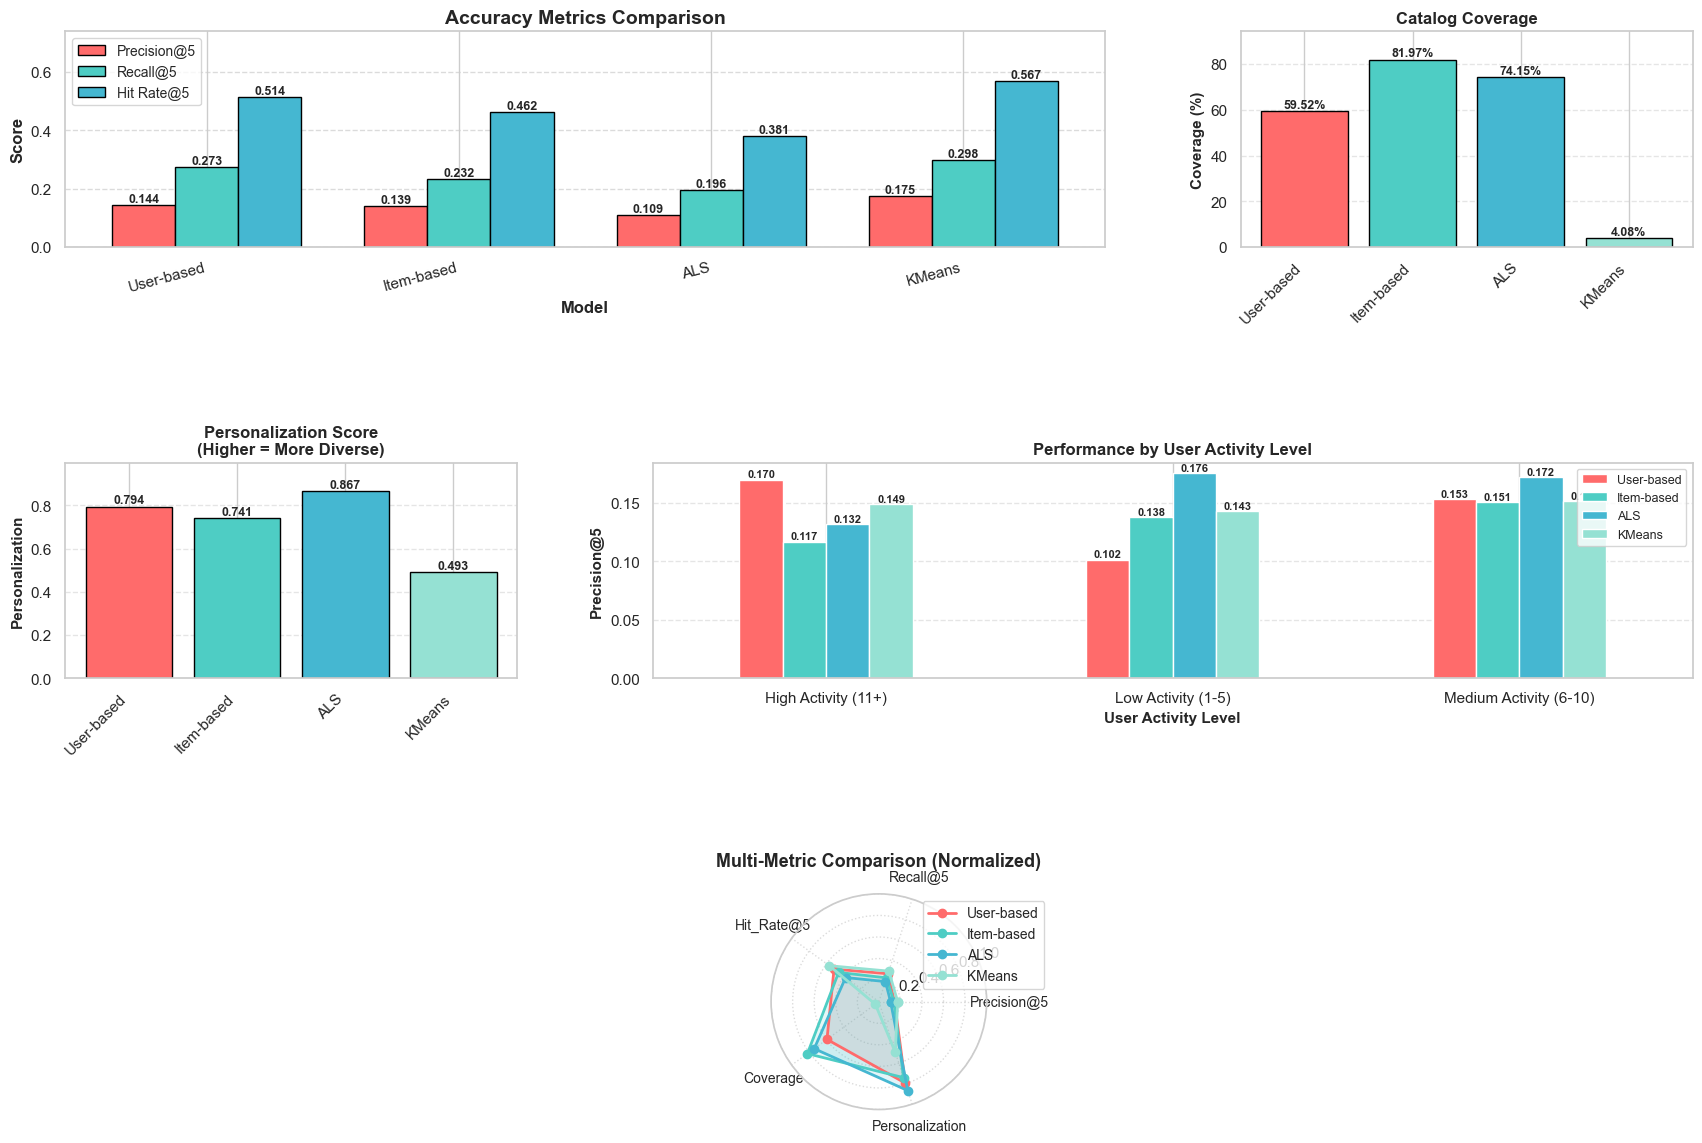


✓ Comprehensive visualization saved: model_evaluation_comparison.png


(        Model  Precision@5  Recall@5  Hit_Rate@5  Catalog_Coverage  \
 0  User-based      0.14448  0.272654      0.5140         59.523810   
 1  Item-based      0.13916  0.232244      0.4616         81.972789   
 2         ALS      0.10880  0.196018      0.3812         74.149660   
 3      KMeans      0.17456  0.298077      0.5674          4.081633   
 
    Personalization  
 0         0.794425  
 1         0.740891  
 2         0.867332  
 3         0.493240  ,
          Model                 Segment  N_Users  Precision
 0   User-based      Low Activity (1-5)     4335   0.143391
 1   User-based  Medium Activity (6-10)      571   0.152014
 2   User-based     High Activity (11+)       94   0.148936
 3   Item-based      Low Activity (1-5)     4335   0.138131
 4   Item-based  Medium Activity (6-10)      571   0.150613
 5   Item-based     High Activity (11+)       94   0.117021
 6          ALS      Low Activity (1-5)     4335   0.101592
 7          ALS  Medium Activity (6-10)      571   0

In [61]:
evaluate_models(cf_recommendations, ground_truth, full_train_matrix, catalog_size=len(df_attr)  )

---
## 5.5 Hybrid Stacking Ensemble Models

The hybrid stacking ensemble approach was selected as the modelling method for this recommendation task. The problem was framed as **binary classification**: predict whether a user will visit a given vroot (positive class) or not (negative class). This formulation is well-suited to implicit feedback datasets, where only positive interactions are observed and the majority of user-item pairs remain unknown (Hu et al., 2008).

The hybrid design combines multiple signals through diverse base learners and a meta-learner, allowing the model to address the dataset's:
- **Extreme sparsity** (99.994% of user-item pairs unobserved)
- **Cold-start challenges** for users with limited interaction history
- **Popularity bias** from highly skewed item visit distributions

Three complementary features were engineered for each user-item pair, selected based on the feature importance analysis conducted in Section 4:

| Feature | Definition | Rationale | 
|---------|------------|-----------|
| Normalised User Activity | Proportion of vroots visited by the user relative to total catalog | Captures personal engagement intensity and user type (casual vs. power user) | 
| Normalised Item Popularity | Proportion of users who visited the vroot relative to total users | Captures global item appeal independent of individual preferences | 
| Average Cosine Similarity | Mean cosine similarity between candidate vroot and user's historical visits | Captures collaborative patterns and content alignment |

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats
import time
from math import pi
import warnings
warnings.filterwarnings('ignore')

In [63]:

# 1. DATA PREPARATION


print("\n" + "="*80)
print("Step 1: DATA PREPARATION")
print("="*80)

# Load data
X_train_tfidf = pd.read_csv('train_tfidf_features.csv', index_col='user_id')
train_binary  = pd.read_csv('train_binary_matrix.csv', index_col='user_id')
item_popularity_series = pd.read_csv('item_popularity.csv', index_col=0).squeeze(True)
item_sim_df = pd.read_csv('item_similarity_matrix.csv', index_col=0)
df_test = pd.read_csv('cleaned_test.csv')

# Convert IDs to strings
X_train_tfidf.index = X_train_tfidf.index.astype(str)
X_train_tfidf.columns = X_train_tfidf.columns.astype(str)

train_binary.index = train_binary.index.astype(str)
train_binary.columns = train_binary.columns.astype(str)

item_sim_df.index = item_sim_df.index.astype(str)
item_sim_df.columns = item_sim_df.columns.astype(str)

df_test['user_id'] = df_test['user_id'].astype(str)
df_test['vroot_id'] = df_test['vroot_id'].astype(str)

item_popularity_series.index = item_popularity_series.index.astype(str)

# Check overlap with training
test_user_ids = df_test['user_id'].unique()
train_user_set = set(train_binary.index)
test_user_set = set(test_user_ids)

users_in_both = test_user_set & train_user_set
users_only_test = test_user_set - train_user_set

print(f"  Users in both train & test: {len(users_in_both)} ({len(users_in_both)/len(test_user_ids)*100:.1f}%)")
print(f"  New users (cold start): {len(users_only_test)} ({len(users_only_test)/len(test_user_ids)*100:.1f}%)")


# Build test features from training profiles
X_test_tfidf_rows = []

for user_id in test_user_ids:
    user_str = str(user_id)

    if user_str in X_train_tfidf.index:
        # User exists in training - use their TRAINING TF-IDF profile
        user_profile = X_train_tfidf.loc[user_str]
    else:
        # Cold start user - use ZERO profile
        user_profile = pd.Series(0, index=X_train_tfidf.columns)

    X_test_tfidf_rows.append(user_profile)

# Create DataFrame
X_test_tfidf = pd.DataFrame(
    X_test_tfidf_rows,
    index=[str(u) for u in test_user_ids],
    columns=X_train_tfidf.columns
)

item_popularity = item_popularity_series.to_dict()

print(f'Training users: {len(train_binary)}')
print(f'Test users: {len(X_test_tfidf)}')
print(f'Items: {len(X_train_tfidf.columns)}')


Step 1: DATA PREPARATION
  Users in both train & test: 5000 (100.0%)
  New users (cold start): 0 (0.0%)
Training users: 32711
Test users: 5000
Items: 183


### 5.5.1 Prepare Stacking data

To manage the severe class imbalance inherent in implicit feedback data (approximately 99.994% negative interactions), a **controlled negative sampling** strategy was applied:

**Sampling Approach:**
- All positive interactions (observed visits) were retained in the training set
- Negative samples (unobserved user-item pairs) were randomly sampled at a **3:1 ratio** (3 negatives per positive)

This balanced approach ensures the model learns to distinguish positive signals from the background noise while maintaining computational tractability.

In [64]:

# 2. PREPARE STACKING DATA
print("\n" + "="*80)
print("Step 2: PREPARE STACKING DATA")
print("="*80)

def prepare_stacking_data(train_binary, item_popularity, item_sim_df, neg_ratio=3):
    np.random.seed(42)
    stack_features = []
    stack_labels = []

    pos_users, pos_items = np.where(train_binary.values == 1)
    n_positives = len(pos_users)

    # Normalize popularity
    max_pop = max(item_popularity.values())
    max_items = train_binary.shape[1]

    # Positive samples
    for idx in range(n_positives):
        u_id = train_binary.index[pos_users[idx]]
        i_id = train_binary.columns[pos_items[idx]]

        f1 = train_binary.loc[u_id].sum() / max_items
        f2 = item_popularity[i_id] / max_pop

        user_history = train_binary.columns[train_binary.loc[u_id] > 0]
        other_items = [item for item in user_history if item != i_id]
        f3 = item_sim_df.loc[other_items, i_id].mean() if len(other_items) > 0 else 0

        stack_features.append([f1, f2, f3])
        stack_labels.append(1)

    # Negatives
    target_neg = n_positives * neg_ratio
    neg_count = 0
    positive_pairs = set(zip(pos_users, pos_items))

    while neg_count < target_neg:
        u_idx = np.random.randint(0, train_binary.shape[0])
        i_idx = np.random.randint(0, train_binary.shape[1])

        if (u_idx, i_idx) not in positive_pairs:
            u_id = train_binary.index[u_idx]
            i_id = train_binary.columns[i_idx]

            f1 = train_binary.loc[u_id].sum() / max_items
            f2 = item_popularity[i_id] / max_pop

            user_history = train_binary.columns[train_binary.loc[u_id] > 0]
            f3 = item_sim_df.loc[user_history, i_id].mean() if len(user_history) > 0 else 0

            stack_features.append([f1, f2, f3])
            stack_labels.append(0)
            neg_count += 1

    return np.array(stack_features), np.array(stack_labels)

X_stack, y_stack = prepare_stacking_data(train_binary, item_popularity, item_sim_df, neg_ratio=3)   
print(f"Dataset: {len(y_stack):,} samples ({sum(y_stack):,} positive, {len(y_stack)-sum(y_stack):,} negative)")


Step 2: PREPARE STACKING DATA
Dataset: 391,892 samples (97,973 positive, 293,919 negative)


### 5.5.2 Hyperparameter Tuning Methodology

Hyperparameter tuning was performed independently for each base model using `GridSearchCV` with **3-fold cross-validation**, optimising for **F1-score** to balance precision and recall in the imbalanced setting.

**Hyperparameter Search Ranges:**

| Model | Parameter | Search Range | Rationale |
|-------|-----------|--------------|-----------|
| RandomForest / GradientBoosting | `n_estimators` | [50, 100] | Moderate values providing sufficient capacity without excessive training time |
| Tree-based models | `max_depth` | [3, 5] | Shallow trees preferred to limit complexity and prevent overfitting in sparse, low-dimensional settings (Breiman, 2001) |
| KNeighborsClassifier | `n_neighbors` | [3, 5, 7] | Small neighbourhood sizes maintain local sensitivity while avoiding excessive noise |
| LogisticRegression | `C` | [0.1, 1, 10] | Standard range covering strong to weak regularisation |
| XGBoost | `learning_rate` | [0.1] | Conservative learning rate for stable convergence |

In [65]:

#TRAIN STACKING MODEL

print("TRAIN STACKING MODEL")



# Define parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'max_iter': [1000]
    }
}

def train_model(model, param_grid, X, y, name): 
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=0, return_train_score=True)
    grid_search.fit(X, y)

    # Overfitting check
    best_idx = grid_search.best_index_
    train_score = grid_search.cv_results_['mean_train_score'][best_idx]
    val_score = grid_search.cv_results_['mean_test_score'][best_idx]
    print(f"Train F1: {train_score:.4f}, Val F1: {val_score:.4f}, Gap: {train_score - val_score:.4f}")

    if train_score - val_score > 0.1:
        print(f"Significant overfitting detected for {name}.")
    elif train_score - val_score > 0.05:
        print(f"Moderate overfitting detected for {name}.")
    else: 
        print(f"Good generalization for {name}.")
    
    # Feature importance
    if hasattr(grid_search.best_estimator_, 'feature_importances_'):
        importances = grid_search.best_estimator_.feature_importances_
        print(f"Feature importance: User Activity={importances[0]:.4f}, Item Popularity={importances[1]:.4f}, Item Similarity={importances[2]:.4f}")

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    print(f"Best {name} with F1 score: {best_score:.4f} with params: {grid_search.best_params_}")
    return best_model

TRAIN STACKING MODEL


### 5.5.3 Model Training: Combination 1

**Architecture:** RandomForestClassifier + GradientBoostingClassifier with LogisticRegression meta-learner

**Expected Characteristics:**
- Strong baseline leveraging complementary ensemble strategies (bagging vs. boosting)
- Interpretable meta-combination through logistic regression
- Good generalisation due to variance-bias trade-off between base learners

In [66]:
# Combination 1: RandomForest + GradientBoosting / LogisticRegression
print("\n" + "="*70)
print("Combination 1: RandomForest + GradientBoosting / LogisticRegression")
print("="*70)

rf1 = train_model(RandomForestClassifier(random_state=42), param_grids['RandomForest'], X_stack, y_stack, 'RandomForest')
gb1 = train_model(GradientBoostingClassifier(random_state=42), param_grids['GradientBoosting'], X_stack, y_stack, 'GradientBoosting')
stacking1 = StackingClassifier(
    estimators=[('rf', rf1), ('gb', gb1)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1,
    cv=3
)
stacking1.fit(X_stack, y_stack)
print('Combination 1 trained')


Combination 1: RandomForest + GradientBoosting / LogisticRegression

Training RandomForest...
Train F1: 0.8565, Val F1: 0.8516, Gap: 0.0049
Good generalization for RandomForest.
Feature importance: User Activity=0.1338, Item Popularity=0.4134, Item Similarity=0.4527
Best RandomForest with F1 score: 0.8516 with params: {'max_depth': 10, 'n_estimators': 100}

Training GradientBoosting...
Train F1: 0.8518, Val F1: 0.8499, Gap: 0.0019
Good generalization for GradientBoosting.
Feature importance: User Activity=0.1636, Item Popularity=0.1832, Item Similarity=0.6532
Best GradientBoosting with F1 score: 0.8499 with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Combination 1 trained


### 5.5.4 Model Training: Combination 2

**Architecture:** KNeighborsClassifier + XGBClassifier + GradientBoostingClassifier with LogisticRegression meta-learner

**Expected Characteristics:**
- Maximum diversity through three distinct learning paradigms
- KNN captures local neighbourhood patterns often missed by global tree-based models
- XGBoost and GradientBoosting provide complementary boosting implementations
- Highest potential for capturing diverse user preference patterns (Alam et al., 2023)

In [67]:
# Combination 2: KNN + XGB + GB / LogisticRegression
print("\n" + "="*70)
print("Combination 2: KNN + XGB + GB / LogisticRegression")
print("="*70)

knn2 = train_model(KNeighborsClassifier(), param_grids['KNN'], X_stack, y_stack, 'KNN')
xgb2 = train_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grids['XGBoost'], X_stack, y_stack, 'XGBoost')
gb2 = train_model(GradientBoostingClassifier(random_state=42), param_grids['GradientBoosting'], X_stack, y_stack, 'GradientBoosting')
stacking2 = StackingClassifier(
    estimators=[('knn', knn2), ('xgb', xgb2), ('gb', gb2)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1,
    cv=3
)
stacking2.fit(X_stack, y_stack)
print('Combination 2 trained')


Combination 2: KNN + XGB + GB / LogisticRegression

Training KNN...
Train F1: 0.9703, Val F1: 0.8476, Gap: 0.1227
Significant overfitting detected for KNN.
Best KNN with F1 score: 0.8476 with params: {'n_neighbors': 7, 'weights': 'distance'}

Training XGBoost...
Train F1: 0.8477, Val F1: 0.8464, Gap: 0.0013
Good generalization for XGBoost.
Feature importance: User Activity=0.2176, Item Popularity=0.2281, Item Similarity=0.5542
Best XGBoost with F1 score: 0.8464 with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Training GradientBoosting...
Train F1: 0.8518, Val F1: 0.8499, Gap: 0.0019
Good generalization for GradientBoosting.
Feature importance: User Activity=0.1636, Item Popularity=0.1832, Item Similarity=0.6532
Best GradientBoosting with F1 score: 0.8499 with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Combination 2 trained


### 5.5.5 Model Training: Combination 3

**Architecture:** LogisticRegression + RandomForestClassifier + XGBClassifier with XGBClassifier meta-learner

**Expected Characteristics:**
- Non-linear meta-combination through XGBoost meta-learner
- More expressive integration of base model predictions
- LogisticRegression base learner provides linear decision boundary for contrast
- Potential for capturing complex interactions between base model outputs (Chen and Guestrin, 2016)

In [68]:
# Combination 3: LR + RF + XGB / XGB
print("\n" + "="*70)
print("Combination 3: LR + RF + XGB / XGB")
print("="*70)

lr3 = train_model(LogisticRegression(max_iter=1000, random_state=42), param_grids['LogisticRegression'], X_stack, y_stack, 'LogisticRegression')
rf3 = train_model(RandomForestClassifier(random_state=42), param_grids['RandomForest'], X_stack, y_stack, 'RandomForest')
xgb3 = train_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grids['XGBoost'], X_stack, y_stack, 'XGBoost')
stacking3 = StackingClassifier(
    estimators=[('lr', lr3), ('rf', rf3), ('xgb', xgb3)],
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    n_jobs=-1,
    cv=3
)
stacking3.fit(X_stack, y_stack)
print('Combination 3 trained')


Combination 3: LR + RF + XGB / XGB

Training LogisticRegression...
Train F1: 0.7568, Val F1: 0.7566, Gap: 0.0002
Good generalization for LogisticRegression.
Best LogisticRegression with F1 score: 0.7566 with params: {'C': 10, 'max_iter': 1000}

Training RandomForest...
Train F1: 0.8565, Val F1: 0.8516, Gap: 0.0049
Good generalization for RandomForest.
Feature importance: User Activity=0.1338, Item Popularity=0.4134, Item Similarity=0.4527
Best RandomForest with F1 score: 0.8516 with params: {'max_depth': 10, 'n_estimators': 100}

Training XGBoost...
Train F1: 0.8477, Val F1: 0.8464, Gap: 0.0013
Good generalization for XGBoost.
Feature importance: User Activity=0.2176, Item Popularity=0.2281, Item Similarity=0.5542
Best XGBoost with F1 score: 0.8464 with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Combination 3 trained


### 5.5.6 Recommendation Generation

For each user in the test set, recommendations are generated by:

1. **Candidate Generation:** Identify all vroots not visited by the user in training
2. **Feature Computation:** Calculate the three engineered features for each (user, candidate vroot) pair
3. **Probability Prediction:** Apply trained stacking classifier to predict visit probability
4. **Ranking:** Sort candidates by predicted probability in descending order
5. **Top-K Selection:** Return the top-5 candidates as recommendations

In [69]:
# 4. GENERATE RECOMMENDATIONS

print("\n" + "="*80)
print("Step 4: GENERATING RECOMMENDATIONS")
print("="*80)

def get_candidates(user_str, train_binary, item_sim_df, item_popularity, X_test_tfidf, n_candidates=100):
    scored_candidates = {}

    # Strategy 1: Collaborative (Weight 1.0)
    if user_str in train_binary.index:
        user_hist = train_binary.columns[train_binary.loc[user_str] > 0]
        if len(user_hist) > 0:
            sim_scores = item_sim_df.loc[:, user_hist].mean(axis=1).sort_values(ascending=False).head(40)
            for i, (idx, score) in enumerate(sim_scores.items()):
                scored_candidates[idx] = scored_candidates.get(idx, 0) + (1.0 - (i/40))

    # Strategy 2: Content-Based (Weight 1.0)
    if user_str in X_test_tfidf.index:
        content_scores = X_test_tfidf.loc[user_str].sort_values(ascending=False).head(40)
        for i, (idx, score) in enumerate(content_scores.items()):
            # Only add if score > 0 to avoid adding random 0-score items
            if score > 0:
                scored_candidates[idx] = scored_candidates.get(idx, 0) + (1.0 - (i/40))

    # Strategy 3: Popularity Fallback
    pop_items = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)[:40]
    for i, (idx, count) in enumerate(pop_items):
        scored_candidates[idx] = scored_candidates.get(idx, 0) + (0.5 - (i/80)) # Lower weight for pop

    # Sort by combined heuristic and take top N
    final_candidates = sorted(scored_candidates.items(), key=lambda x: x[1], reverse=True)
    return [item[0] for item in final_candidates[:n_candidates]]


def generate_recommendations(stacking_model, user_str, candidates, train_binary, item_popularity, item_sim_df, top_n=5):
    """
    Generate top-N recommendations using stacking model.
    """
    # Extract features for all candidates
    cand_features = []
    valid_candidates = []
    max_pop = max(item_popularity.values())
    max_items = train_binary.shape[1]

    for i_id in candidates:
        f1 = train_binary.loc[user_str].sum() / max_items if user_str in train_binary.index else 0
        f2 = item_popularity.get(i_id, 0) / max_pop

        if user_str in train_binary.index:
            user_history = train_binary.columns[train_binary.loc[user_str] > 0]
            other_items = [item for item in user_history if item != i_id]
            f3 = item_sim_df.loc[other_items, i_id].mean() if len(other_items) > 0 and i_id in item_sim_df.columns else 0
        else: 
            f3 = 0
        
        cand_features.append([f1, f2, f3])
        valid_candidates.append(i_id)

    if len(cand_features) == 0:
        return [item[0] for item in sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)[:top_n]]

    # Get predictions
    X_cand = np.array(cand_features)
    proba = stacking_model.predict_proba(X_cand)[:, 1]

    # Get top-N
    top_indices = np.argsort(proba)[-top_n:][::-1]
    recommendations = [valid_candidates[i] for i in top_indices]

    return recommendations


# Generate recommendations for all combinations
stack_recs_comb1 = {}
stack_recs_comb2 = {}
stack_recs_comb3 = {}
test_users = X_test_tfidf.index.tolist()
total_users = len(test_users)
for idx, user_id in enumerate(test_users):
    if idx % 500 == 0:
        print(f"  Progress: {idx}/{total_users} users ({idx/total_users*100:.1f}%)")

    user_str = str(user_id)

    # Get candidates
    candidates = get_candidates(
        user_str, train_binary, item_sim_df, item_popularity, X_test_tfidf
    )

    # Generate recommendations from all three combinations
    stack_recs_comb1[user_str] = generate_recommendations(
        stacking1, user_str, candidates, train_binary, item_popularity, item_sim_df
    )

    stack_recs_comb2[user_str] = generate_recommendations(
        stacking2, user_str, candidates, train_binary, item_popularity, item_sim_df
    )

    stack_recs_comb3[user_str] = generate_recommendations(
        stacking3, user_str, candidates, train_binary, item_popularity, item_sim_df
    )

print(f"\n Recommendations generated for {total_users} users")


Step 4: GENERATING RECOMMENDATIONS
  Progress: 0/5000 users (0.0%)
  Progress: 500/5000 users (10.0%)
  Progress: 1000/5000 users (20.0%)
  Progress: 1500/5000 users (30.0%)
  Progress: 2000/5000 users (40.0%)
  Progress: 2500/5000 users (50.0%)
  Progress: 3000/5000 users (60.0%)
  Progress: 3500/5000 users (70.0%)
  Progress: 4000/5000 users (80.0%)
  Progress: 4500/5000 users (90.0%)

 Recommendations generated for 5000 users



EVALUATING MODEL PERFORMANCE

Calculating metrics...

                        Model  Precision@5  Recall@5  Hit_Rate@5  Catalog_Coverage  Personalization
     Hybrid-Combo1 (RF+GB/LR)      0.15924  0.297879      0.5410         48.639456         0.761158
Hybrid-Combo2 (KNN+XGB+GB/LR)      0.17928  0.339495      0.5978         52.380952         0.732970
Hybrid-Combo3 (LR+RF+XGB/XGB)      0.15172  0.280130      0.5320         47.278912         0.792916

USER SEGMENT ANALYSIS

Model                   Hybrid-Combo1 (RF+GB/LR)  Hybrid-Combo2 (KNN+XGB+GB/LR)  Hybrid-Combo3 (LR+RF+XGB/XGB)
Segment                                                                                                       
High Activity (11+)                     0.169231                       0.147253                       0.140659
Low Activity (1-5)                      0.154983                       0.179747                       0.147986
Medium Activity (6-10)                  0.190426                       0.1808

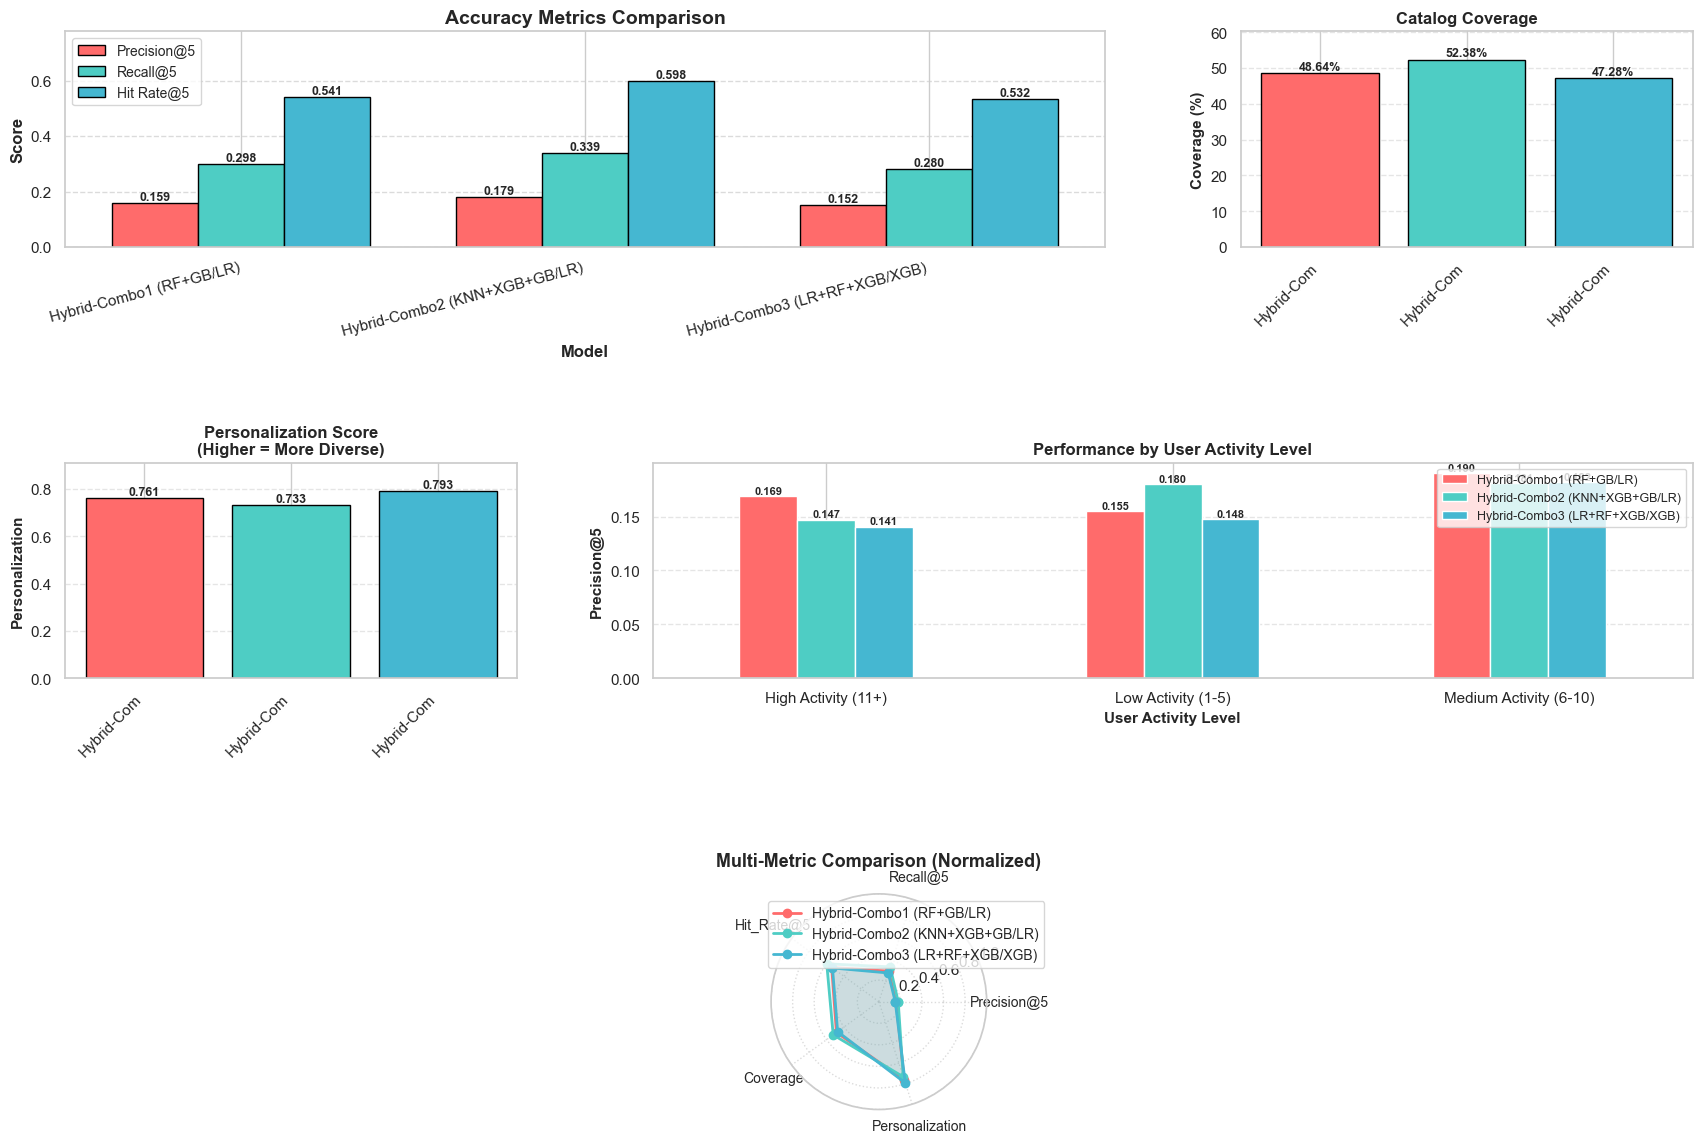


✓ Comprehensive visualization saved: model_evaluation_comparison.png


In [74]:
# Build hybrid recommendations dictionary
hybrid_recommendations = {
    'Hybrid-Combo1 (RF+GB/LR)': stack_recs_comb1,
    'Hybrid-Combo2 (KNN+XGB+GB/LR)': stack_recs_comb2,
    'Hybrid-Combo3 (LR+RF+XGB/XGB)': stack_recs_comb3
}

# Use the shared evaluate_models function for consistent evaluation
hybrid_results_df, hybrid_segment_df = evaluate_models(
    recommendations=hybrid_recommendations,
    ground_truth=ground_truth,
    train_binary=train_binary,
    catalog_size=len(df_attr)
)

---

##  Interactive Recommendation Viewer

Two utility functions to explore recommendations from all trained models:
- `show_sample_users()` - Display users with both training and test data
- `show_recommendations(user_id)` - Show all model recommendations for a user with color-coded accuracy

In [86]:

# INTERACTIVE RECOMMENDATION VIEWER


# ANSI colors for notebook output
class Colors:
    GREEN = '\033[92m'
    RED = '\033[91m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    YELLOW = '\033[93m'
    MAGENTA = '\033[95m'
    WHITE = '\033[97m'
    BOLD = '\033[1m'
    END = '\033[0m'


def get_page_title(vroot_id):
    """Get page title from attributes."""
    try:
        vid = int(vroot_id) if isinstance(vroot_id, str) else vroot_id
        match = df_attr[df_attr['vroot_id'] == vid]
        if len(match) > 0:
            return match.iloc[0]['title']
    except:
        pass
    return f"Page {vroot_id}"
def show_sample_users(min_interactions=1, max_interactions=100, n=10):
    """
    Show random sample of users with interactions in specified range.
    
    Args:
        min_interactions: Minimum number of training interactions (inclusive)
        max_interactions: Maximum number of training interactions (inclusive)
        n: Number of random users to show
    """
    import random
    
    # Get users with both training and test data
    common_users = set(full_train_matrix.index) & set(ground_truth.keys())
    
    # Filter by interaction count
    filtered_users = []
    for uid in common_users:
        train_count = (full_train_matrix.loc[uid] > 0).sum()
        if min_interactions <= train_count <= max_interactions:
            filtered_users.append(uid)
    # Random sample
    sample = random.sample(filtered_users, min(n, len(filtered_users)))
    
    print(f"\n{Colors.CYAN}{Colors.BOLD}Random Users with {min_interactions}-{max_interactions} Interactions{Colors.END}")
    print("=" * 60)
    print(f"  Found {len(filtered_users)} users in range, showing {len(sample)}:")
    print("-" * 60)
    for uid in sample:
        train_count = (full_train_matrix.loc[uid] > 0).sum()
        test_count = len(ground_truth[uid])
        print(f"   User {uid}: {train_count} training visits, {test_count} test visits")
    print(f"\n{Colors.YELLOW}Use: show_recommendations('user_id') to see recommendations{Colors.END}")
    return sample




def show_recommendations(user_id):
    """Show recommendations from all models for a given user."""
    user_str = str(user_id)
    user_int = int(user_id) if str(user_id).isdigit() else user_id
    
    print("\n" + "=" * 70)
    print(f"{Colors.CYAN}{Colors.BOLD}   RECOMMENDATIONS FOR USER: {user_id}{Colors.END}")
    print("=" * 70)
    
    # Get user's training history
    if user_str in full_train_matrix.index:
        user_row = full_train_matrix.loc[user_str]
        user_history = [str(col) for col in user_row.index[user_row > 0]]
    else:
        user_history = []
        print(f"{Colors.YELLOW} User not in training data{Colors.END}")
    
    # Get test items (ground truth)
    test_items = ground_truth.get(user_str, [])
    test_set = set(str(x) for x in test_items)
    
    # Display user info
    print(f"\n{Colors.BLUE}{Colors.BOLD} Training History ({len(user_history)} pages){Colors.END}")
    print("-" * 60)
    for i, pid in enumerate(user_history[:10], 1):
        print(f"  {i}. [{pid}] {get_page_title(pid)}")
    if len(user_history) > 10:
        print(f"  ... and {len(user_history) - 10} more")
    
    print(f"\n{Colors.BLUE}{Colors.BOLD} Test Pages to Predict ({len(test_items)} pages){Colors.END}")
    print("-" * 60)
    for i, pid in enumerate(test_items[:8], 1):
        print(f"  {i}. [{pid}] {get_page_title(pid)}")
        
    def display_recs(recs, model_name, color):
        """Display recommendations with color coding."""
        print(f"\n{color}{Colors.BOLD} {model_name}{Colors.END}")
        if not recs:
            print(f"  {Colors.YELLOW}(No recommendations){Colors.END}")
            return
        correct = 0
        for i, pid in enumerate(recs[:5], 1):
            title = get_page_title(pid)
            if str(pid) in test_set:
                print(f"  {Colors.GREEN}✓ {i}. [{pid}] {title}{Colors.END}")
                correct += 1
            else:
                print(f"  {Colors.RED}✗ {i}. [{pid}] {title}{Colors.END}")
        print(f"  {Colors.CYAN}Score: {correct}/5 correct ({correct/5*100:.1f}%){Colors.END}")
    
    # COLLABORATIVE FILTERING
    print(f"\n{Colors.BOLD}{'='*70}{Colors.END}")
    print(f"{Colors.MAGENTA}{Colors.BOLD}   COLLABORATIVE FILTERING MODELS{Colors.END}")
    print(f"{'='*70}")
    
    # KNN User-Based
    try:
        recs = knn_engine.get_k_recommend(user_id, k=5, mode='user')
        display_recs(recs, f"KNN User-Based (k={knn_engine.best_k['user']})", Colors.MAGENTA)
    except Exception as e:
        print(f"  {Colors.RED}KNN User-Based Error: {e}{Colors.END}")
    
    # KNN Item-Based
    try:
        recs = knn_engine.get_k_recommend(user_id, k=5, mode='item')
        display_recs(recs, f"KNN Item-Based (k={knn_engine.best_k['item']})", Colors.MAGENTA)
    except Exception as e:
        print(f"  {Colors.RED}KNN Item-Based Error: {e}{Colors.END}")
    
    # KMeans
    try:
        recs = kmeans_engine.get_k_recommend(user_id, k=5)
        display_recs(recs, f"KMeans (n_clusters={kmeans_engine.best_params['n_clusters']})", Colors.MAGENTA)
    except Exception as e:
        print(f"  {Colors.RED}Kmeans Error: {e}{Colors.END}")
        
    # CONTENT-BASED
    print(f"\n{Colors.BOLD}{'='*70}{Colors.END}")
    print(f"{Colors.YELLOW}{Colors.BOLD}  CONTENT-BASED MODELS{Colors.END}")
    print(f"{'='*70}")
    
    # Cosine
    try:
        recs = cosine_model.recommend(user_id, k=5)
        display_recs(recs, "Cosine Similarity", Colors.YELLOW)
    except Exception as e:
        print(f"  {Colors.RED}Cosine Error: {e}{Colors.END}")
    
    # KNN Content
    try:
        recs = knn_model.recommend(user_id, k=5)
        display_recs(recs, "KNN Content-Based", Colors.YELLOW)
    except Exception as e:
        print(f"  {Colors.YELLOW}KNN Content: Not available{Colors.END}")
    
    # SVD
    try:
        recs = svd_model.recommend(user_id, k=5)
        display_recs(recs, "SVD/LSA", Colors.YELLOW)
    except Exception as e:
        print(f"  {Colors.RED}SVD Error: {e}{Colors.END}")
        
    #HYBRID
    try:
        print(f"\n{Colors.BOLD}{'='*70}{Colors.END}")
        print(f"{Colors.WHITE}{Colors.BOLD}  HYBRID MODELS{Colors.END}")
        print(f"{'='*70}")
        
        # Get candidates
        candidates = get_candidates(user_str, train_binary, item_sim_df, item_popularity, X_test_tfidf)
        
        # Stacking 1
        try:
            recs = generate_recommendations(stacking1, user_str, candidates, train_binary, item_popularity, item_sim_df)
            display_recs(recs, "Hybrid Combo1 (RF+GB / LR)", Colors.WHITE)
        except:
            print(f"  {Colors.YELLOW}Hybrid Combo1: Not available{Colors.END}")
        
        # Stacking 2
        try:
            recs = generate_recommendations(stacking2, user_str, candidates, train_binary, item_popularity, item_sim_df)
            display_recs(recs, "Hybrid Combo2 (KNN+XGB+GB / LR)", Colors.WHITE)
        except:
            print(f"  {Colors.YELLOW}Hybrid Combo2: Not available{Colors.END}")
        
        # Stacking 3
        try:
            recs = generate_recommendations(stacking3, user_str, candidates, train_binary, item_popularity, item_sim_df)
            display_recs(recs, "Hybrid Combo3 (LR+RF+XGB / XGB)", Colors.WHITE)
        except:
            print(f"  {Colors.YELLOW}Hybrid Combo3: Not available{Colors.END}")
    except Exception as e:
        print(f"  {Colors.YELLOW}Hybrid models not available: {e}{Colors.END}")
    



In [84]:
show_sample_users(5,10,10)


Random Users with 5-10 Interactions
  Found 880 users in range, showing 10:
------------------------------------------------------------
   User 14307: 8 training visits, 1 test visits
   User 12327: 7 training visits, 1 test visits
   User 10037: 5 training visits, 7 test visits
   User 13467: 5 training visits, 1 test visits
   User 12142: 5 training visits, 4 test visits
   User 12145: 5 training visits, 3 test visits
   User 12840: 7 training visits, 5 test visits
   User 13492: 6 training visits, 4 test visits
   User 14468: 5 training visits, 5 test visits
   User 14380: 6 training visits, 6 test visits

Use: show_recommendations('user_id') to see recommendations


['14307',
 '12327',
 '10037',
 '13467',
 '12142',
 '12145',
 '12840',
 '13492',
 '14468',
 '14380']

In [87]:
show_recommendations('10037')


   RECOMMENDATIONS FOR USER: 10037

 Training History (5 pages)
------------------------------------------------------------
  1. [1008] Free Downloads
  2. [1017] Products 
  3. [1032] Games
  4. [1055] MSHome Kids Stuff
  5. [1056] sports

 Test Pages to Predict (7 pages)
------------------------------------------------------------
  1. [1008] Free Downloads
  2. [1016] MS Excel
  3. [1152] Russia
  4. [1052] MS Word News
  5. [1040] MS Office Info
  6. [1034] Internet Explorer
  7. [1014] Office Free Stuff

   COLLABORATIVE FILTERING MODELS

 KNN User-Based (k=200)
  ✗ 1. [1032] Games
  ✓ 2. [1008] Free Downloads
  ✗ 3. [1017] Products 
  ✗ 4. [1056] sports
  ✗ 5. [1055] MSHome Kids Stuff
  Score: 1/5 correct (20.0%)

 KNN Item-Based (k=5)
  ✗ 1. [1017] Products 
  ✓ 2. [1008] Free Downloads
  ✗ 3. [1009] Windows Family of OSs
  ✗ 4. [1018] isapi
  ✗ 5. [1090] Games Support
  Score: 1/5 correct (20.0%)

 KMeans (n_clusters=5)
  ✓ 1. [1034] Internet Explorer
  ✓ 2. [1008] Free Downl